In [1]:
import pandas as pd
import numpy as np

import _pickle as pickle
from collections import Counter
from pprint import pprint
from datetime import datetime
import shutil
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
ROOT_DIR = "../"

DATA_DIR = ROOT_DIR
RESULTS_DIR = ROOT_DIR + "results/"

# Train - 1168
# Validation - 292 videos 
# Test - 252 videos 

TRAINING_DATA_DIR = DATA_DIR + 'video_training_data/' # Directory storing videos as separate files
TRAINING_DATA_COUNT = 1168

TRAINING_DATA = DATA_DIR + "video_training_data.p" # each read gives labelled video [(segment, label), segment_2, ...]
VALIDATION_DATA = DATA_DIR + "video_validation_data.p" 
TEST_DATA = DATA_DIR + "video_testing_data.p" # each read gives video [(segment), segment_2, ...]

## Load data from file

In [3]:
def get_next_video_data(f):    
    is_end_reached = False
    
    try:
        video = pickle.load(f) # [(segment, label), ...]
    except (EOFError):
        is_end_reached = True
        return [], is_end_reached
    
    return video, is_end_reached

In [4]:
def get_video_data(idx): 
    train_video_f = open(TRAINING_DATA_DIR + str(idx) + '.p', 'rb') 
    video = pickle.load(train_video_f) # [(segment, label), ...]
    train_video_f.close()
    
    return video

## Model Architecture

**Temporal Model (RNN, LSTM, GRU):**
- [x] Add dropout
- [ ] Add stacking / another lstm
- [ ] No temporal pooling
- [x] Max pooling
- [x] Avg pooling
- [x] [Concat pooling](https://medium.com/@sonicboom8/sentiment-analysis-with-variable-length-sequences-in-pytorch-6241635ae130)
- [ ] CS4248 12-rnn slide 32: Use pooled hidden states (segment level) in another RNN, and predict for each resultatnt hidden state. 

**Try out models:**
- [ ] RNN
- [x] LSTM
- [x] GRU
- [ ] [QRNN](https://github.com/salesforce/pytorch-qrnn)
- [ ] Nested LSTM
- [ ] TCN


[LSTM vs GRU](https://blog.floydhub.com/gru-with-pytorch/) explanation and comparison article


**Training:**
- [x] Shuffle data
- [ ] Xavier normal initialisation
- [ ] Xavier uniform initialisation


Don't use the SIL frames

In [5]:
class ClassPredictor(nn.Module):
    def __init__(self, input_size, num_classes, drop_prob):
        super(ClassPredictor, self).__init__()
        
        self.input_dout = nn.Dropout(drop_prob) 
        
        
        hidden_1 = 200
        hidden_2 = 130
        hidden_3 = 90
        
        # https://pytorch.org/docs/stable/nn.html#torch.nn.Linear
        self.fc1 = nn.Linear(input_size, hidden_1)
        self.l_relu1 = nn.LeakyReLU()
        self.dout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.l_relu2 = nn.LeakyReLU()
        self.dout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.l_relu3 = nn.LeakyReLU()
        
        self.out = nn.Linear(hidden_3, num_classes)
        
        nn.init.orthogonal_(self.fc1.weight).requires_grad_().cuda()
        nn.init.orthogonal_(self.fc2.weight).requires_grad_().cuda()
        nn.init.orthogonal_(self.fc3.weight).requires_grad_().cuda()
        nn.init.orthogonal_(self.out.weight).requires_grad_().cuda()

#         with torch.no_grad():

#             nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('leaky_relu'))
#             nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('leaky_relu'))
#             nn.init.xavier_uniform_(self.out.weight)
            
    def forward(self, x):
        ## x: (input_size)

        # Manually use dropout for the RNN output
        x = self.input_dout(x)
        
        a1 = self.fc1(x)
        h1 = self.l_relu1(a1)
        dout1 = self.dout1(h1)
        
        a2 = self.fc2(dout1)
        h2 = self.l_relu2(a2)
        dout2 = self.dout2(h2)

        a3 = self.fc3(dout2)
        h3 = self.l_relu3(a3)
        
        # y: (num_classes)
        y = self.out(h3)

        return y

In [6]:
# Bidirectional recurrent neural network (many-to-one)
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, drop_prob):
        super(BiLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        
        ## https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, 
                            batch_first=True, bias=True, dropout=0)
        
        ## DNN for class prediction
        self.fc = ClassPredictor(hidden_size * 2 * 2, num_classes, drop_prob)  # * 4: bidirec, concat pooling
 

    ## https://pytorch.org/docs/stable/nn.init.html
    def init_hidden_state(self, batch_size):
        #h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)
        #c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)

        h0 = torch.empty(self.num_layers * 2, batch_size, self.hidden_size).double()
        h0 = nn.init.orthogonal_(h0) # orthogonal_, xavier_normal_, xavier_uniform_
        
        c0 = torch.empty(self.num_layers * 2, batch_size, self.hidden_size).double()
        c0 = nn.init.orthogonal_(c0) # orthogonal_, xavier_normal_, xavier_uniform_

        h0 = h0.requires_grad_().cuda()
        c0 = c0.requires_grad_().cuda()
        
        return h0, c0
 

    def forward(self, x, segment_indices):
        ## x: (batch_size, seq_len, feature_len)
        ## segment_indices: (num_segments, 2)
        
        batch_size = x.size(0)

        ## Set initial states
        ## h0, c0: (num_layers * num_directions, batch_size, hidden_size)
        h0, c0 = self.init_hidden_state(batch_size)
        
        ## Forward propagate LSTM
        ## out: tensor of shape (batch_size, seq_length, hidden_size * 2)
        out, _ = self.bilstm(x, (h0, c0))  
        
        ## Use hidden states of each segment to predict their labels
        segment_outputs = []
        for (start, end) in segment_indices:
            hidden_states = out[:, start:end, :]
            
            ## Compute the hidden state by doing temporal pooling over all time steps
            ## pool_out: (hidden_size * 2)
            max_pool_out = F.adaptive_max_pool1d(hidden_states.permute(0,2,1), 1).squeeze()
            avg_pool_out = torch.mean(hidden_states, dim=1).squeeze() # adaptive_avg_pool1d

            ## concat_pool_out: (hidden_size * 2 * 2)
            concat_pool_out = torch.cat([max_pool_out, avg_pool_out])

#             final_hidden_out = out[:, end - 1, :]
            
            ## output: (num_classes)
            output = self.fc(concat_pool_out)
            
            segment_outputs.append(output)

        
        ## segment_outputs: (num_segments, num_classes)
        segment_outputs = torch.stack(segment_outputs)
        
        return segment_outputs

In [7]:
class BiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, drop_prob):
        super(BiGRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        ## https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
        self.bigru =nn.GRU(input_size, hidden_size, num_layers, bidirectional=True, 
                            batch_first=True, bias=True) #, dropout=drop_prob) # dropout is only for stacked layers
        
        ## DNN for class prediction
        self.fc = ClassPredictor(hidden_size * 2 * 2, num_classes, drop_prob)
 

    ## https://pytorch.org/docs/stable/nn.init.html
    def init_hidden_state(self, batch_size):
        #h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)

        h0 = torch.empty(self.num_layers * 2, batch_size, self.hidden_size).double()
        h0 = nn.init.orthogonal_(h0) # orthogonal_, xavier_normal_, xavier_uniform_
        h0 = h0.requires_grad_().cuda()
        
        return h0
 

    def forward(self, x, segment_indices):
        ## x: (batch_size, seq_len, feature_len)
        ## segment_indices: (num_segments, 2)
        
        batch_size = x.size(0)

        ## Set initial states
        ## h0: (num_layers * num_directions, batch_size, hidden_size)
        h0 = self.init_hidden_state(batch_size)
        
        ## Forward propagate
        ## out: tensor of shape (batch_size, seq_length, hidden_size * 2)
        out, _ = self.bigru(x, h0)  
        
        ## Use hidden states of each segment to predict their labels
        segment_outputs = []
        for (start, end) in segment_indices:
            hidden_states = out[:, start:end, :]
            
            ## Compute the hidden state by doing temporal pooling over all time steps
            ## pool_out: (hidden_size * 2)
            max_pool_out = F.adaptive_max_pool1d(hidden_states.permute(0,2,1), 1).squeeze()
            avg_pool_out = torch.mean(hidden_states, dim=1).squeeze() # adaptive_avg_pool1d

            ## concat_pool_out: (hidden_size * 2 * 2)
            concat_pool_out = torch.cat([max_pool_out, avg_pool_out])

#             final_hidden_out = out[:, end - 1, :]
            
            ## output: (num_classes)
            output = self.fc(concat_pool_out)
            
            segment_outputs.append(output)

        
        ## segment_outputs: (num_segments, num_classes)
        segment_outputs = torch.stack(segment_outputs)
        
        return segment_outputs

## Train model on entire videos (sequence of segments which are sequence of frames)

In [8]:
def transform_to_inputs(video):
    segments = [] # segments (list of frames) in the video
    labels = [] # labels of each segment
    segment_indices = []
    offset = 0
    for segment_num in range(len(video)):
        segments.append(video[segment_num][0])
        labels.append(video[segment_num][1])
        segment_indices.append((offset, offset + video[segment_num][0].shape[0]))

        offset += video[segment_num][0].shape[0]
        
    # Load frames as tensors with gradient accumulation abilities
    input_frames = torch.cat(segments, 0).unsqueeze(0).requires_grad_().cuda() # unsqueeze to add batch dim
    labels = torch.Tensor(labels).long().cuda()
    segment_indices = torch.IntTensor(segment_indices).cuda()
    
    return input_frames, labels, segment_indices

In [9]:
def save_checkpoint(state, is_best, folder):
    filename = folder + 'model_checkpoint.pth'
    torch.save(state, filename)
    
    if is_best:
        shutil.copyfile(filename, folder + 'model_best.pth')

def train_model(model, num_epochs, should_shuffle, train_data_file=TRAINING_DATA, validation_data_file=VALIDATION_DATA):
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []
    best = float("inf")
    
    for epoch in range(num_epochs):
        start = time.time()
        print('======================================================================')
        print('Epoch: {}'.format(epoch))
        
        video_idxs = np.arange(TRAINING_DATA_COUNT)
        if should_shuffle:
            np.random.shuffle(video_idxs)
        
        correct = 0
        total = 0

        video_num = 0
        epoch_training_losses = []

        model.train()
        for idx in video_idxs:
            video = get_video_data(idx)
            
            inputs, labels, segment_indices = transform_to_inputs(video)

            outputs = model(inputs, segment_indices)
            loss = loss_criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_training_losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            video_num += 1
            if video_num % 250 == 0:
                print('      Video: {}/1168  Loss: {}'.format(video_num, np.mean(epoch_training_losses))) 

        train_accuracy = 100 * correct / total
        
        
        # Evaluate on validation set
        try:
            val_f.close()    
        except(NameError):
            pass  
            
        val_f = open(validation_data_file, 'rb')
        model.eval()
        
        correct = 0
        total = 0
        is_file_end = False

        epoch_validation_losses = []
        
        with torch.no_grad(): # Saves memory and faster computation
            while not is_file_end:
                video, is_file_end = get_next_video_data(val_f)
                if is_file_end:
                    break

                inputs, labels, segment_indices = transform_to_inputs(video)

                outputs = model(inputs, segment_indices)
                loss = loss_criterion(outputs, labels)
                epoch_validation_losses.append(loss.item())

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_f.close()
        
        val_accuracy = 100 * correct / total
        
        
        # Print loss and accuracy
        training_losses.append(np.mean(epoch_training_losses))
        validation_losses.append(np.mean(epoch_validation_losses))
        training_accuracies.append(train_accuracy)
        validation_accuracies.append(val_accuracy)
        

        scheduler.step(validation_losses[-1])

        end = time.time()

        print('   Training Loss: {:.5f}  Validation Loss: {:.5f}'.format(training_losses[-1], validation_losses[-1]))
        print('   Training Accuracy: {:.3f}%   Validation Accuracy: {:.3f}%'.format(train_accuracy, val_accuracy))        
        
        is_best = validation_losses[-1] < best
        best = min(validation_losses[-1], best)
        save_checkpoint({
            'next_epoch_idx': epoch + 1,
            'state_dict': model.state_dict(),
            'val_loss': validation_losses[-1],
            'optimizer' : optimizer.state_dict(),
        }, is_best, RESULTS_DIR + model_time + '/')

        print('Best Validation Loss: {:.5f}'.format(best))
        print('Epoch took {:.2f} minutes'.format((end - start) / 60))

    return training_losses, validation_losses, training_accuracies, validation_accuracies

In [10]:
model_time = str(datetime.now().strftime("%Y-%m-%d___%H-%M-%S"))
os.mkdir(RESULTS_DIR + model_time)
print(model_time)
shutil.copyfile('Bidirectional_video.ipynb', RESULTS_DIR + model_time + '/' + model_time + '_Bidirectional_video.ipynb')

## Model Architecture
input_dim = 400  # dimension of an i3D video frame
hidden_dim = 140 # dimension of hidden state
layer_dim = 1    # number of stacked layers
output_dim = 48  # number of sub-action labels

drop_prob = 0.25 # dropout prob of final RNN output

# model = BiLSTM(input_dim, hidden_dim, layer_dim, output_dim, drop_prob)
model = BiGRU(input_dim, hidden_dim, layer_dim, output_dim, drop_prob)

model = model.double().cuda() # transform the model parameters to double precision


## Loss function
loss_criterion = nn.CrossEntropyLoss()


## Optimizer
learning_rate = 0.008
weight_decay = 0.002
momentum = 0.9

# optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 


## Learning Rate Scheduler
patience = 2
decrease_factor = 0.7
min_learning_rate = 0.00005
scheduler = ReduceLROnPlateau(optimizer, mode='min', 
                              patience=patience, min_lr=min_learning_rate, factor=decrease_factor,
                              verbose=True)


num_epochs = 30
should_shuffle = True 

training_start_time = time.time()

training_losses, validation_losses, training_accuracies, validation_accuracies = train_model(model,num_epochs, should_shuffle)

training_end_time = time.time()

print('-----------------------------------------------------')
print('Finished training', num_epochs, 'epochs in {:.2f} minutes'.format((training_end_time - training_start_time) / 60))

path = RESULTS_DIR + model_time + "/bidirectional_video_model.pth"
torch.save(model.state_dict(), path)
print("\nSaved trained model to", path)

2020-04-07___14-36-44
Epoch: 0
            Video: 0/1168  Loss: 3.344784115917553
            Video: 1/1168  Loss: 4.498328199652048
            Video: 2/1168  Loss: 4.159752237502257
            Video: 3/1168  Loss: 4.752178773826547
            Video: 4/1168  Loss: 3.555425364611886
            Video: 5/1168  Loss: 4.100414419116063
            Video: 6/1168  Loss: 4.786391730747948
            Video: 7/1168  Loss: 3.4759191697817187
            Video: 8/1168  Loss: 2.9909388244664834
            Video: 9/1168  Loss: 4.295092191245532
            Video: 10/1168  Loss: 2.270316822338649
            Video: 11/1168  Loss: 4.680053209075262
            Video: 12/1168  Loss: 3.9738103403902283
            Video: 13/1168  Loss: 3.6157512351339167
            Video: 14/1168  Loss: 4.518581659934677
            Video: 15/1168  Loss: 3.6100916411757753
            Video: 16/1168  Loss: 3.468052269948982
            Video: 17/1168  Loss: 4.200696893252006
            Video: 18/1168  Loss: 3.39

            Video: 154/1168  Loss: 3.4785228183703447
            Video: 155/1168  Loss: 3.747639745549897
            Video: 156/1168  Loss: 2.3071203142651555
            Video: 157/1168  Loss: 2.802451416266129
            Video: 158/1168  Loss: 4.2004651028050315
            Video: 159/1168  Loss: 3.5236205774185034
            Video: 160/1168  Loss: 3.242542500025794
            Video: 161/1168  Loss: 3.7167927081426293
            Video: 162/1168  Loss: 3.790062832497835
            Video: 163/1168  Loss: 4.26482074174465
            Video: 164/1168  Loss: 3.4890449624560276
            Video: 165/1168  Loss: 3.4392140618371516
            Video: 166/1168  Loss: 3.981706893600002
            Video: 167/1168  Loss: 3.9208294399411594
            Video: 168/1168  Loss: 3.8909437703619365
            Video: 169/1168  Loss: 3.553013262854469
            Video: 170/1168  Loss: 3.6326970117572137
            Video: 171/1168  Loss: 4.048566702933252
            Video: 172/1168  Loss: 4.

            Video: 307/1168  Loss: 3.9337063487061315
            Video: 308/1168  Loss: 3.731042943565346
            Video: 309/1168  Loss: 3.8804166307825154
            Video: 310/1168  Loss: 3.611982795610084
            Video: 311/1168  Loss: 3.6414442216022223
            Video: 312/1168  Loss: 3.5236529679289865
            Video: 313/1168  Loss: 3.22810262191458
            Video: 314/1168  Loss: 3.680169344062187
            Video: 315/1168  Loss: 3.490097745047903
            Video: 316/1168  Loss: 3.335682978456455
            Video: 317/1168  Loss: 2.9542256890930267
            Video: 318/1168  Loss: 3.4186975775800055
            Video: 319/1168  Loss: 3.632251511869009
            Video: 320/1168  Loss: 3.771508856248929
            Video: 321/1168  Loss: 2.487137230989078
            Video: 322/1168  Loss: 2.601013239204002
            Video: 323/1168  Loss: 3.7966180246318166
            Video: 324/1168  Loss: 3.386734659639716
            Video: 325/1168  Loss: 3.833

            Video: 461/1168  Loss: 3.435495240132248
            Video: 462/1168  Loss: 3.7514806697546663
            Video: 463/1168  Loss: 2.749065970162145
            Video: 464/1168  Loss: 2.4851645422254656
            Video: 465/1168  Loss: 2.4555450430660093
            Video: 466/1168  Loss: 2.785742222700678
            Video: 467/1168  Loss: 3.1714271236224483
            Video: 468/1168  Loss: 3.608173777803075
            Video: 469/1168  Loss: 2.8252386713173503
            Video: 470/1168  Loss: 1.7373671842776335
            Video: 471/1168  Loss: 3.684373089650669
            Video: 472/1168  Loss: 3.936417014393755
            Video: 473/1168  Loss: 2.1837659936909892
            Video: 474/1168  Loss: 1.7577622615457493
            Video: 475/1168  Loss: 2.472940447914307
            Video: 476/1168  Loss: 3.9014724412609327
            Video: 477/1168  Loss: 2.8612535553077483
            Video: 478/1168  Loss: 2.884715658891909
            Video: 479/1168  Loss: 3

            Video: 614/1168  Loss: 3.716629831502025
            Video: 615/1168  Loss: 2.7823301959188824
            Video: 616/1168  Loss: 2.817307128135099
            Video: 617/1168  Loss: 3.2608093983512325
            Video: 618/1168  Loss: 2.9508425372086267
            Video: 619/1168  Loss: 4.152549890293895
            Video: 620/1168  Loss: 2.729628577030509
            Video: 621/1168  Loss: 2.762548346488778
            Video: 622/1168  Loss: 2.876644366678892
            Video: 623/1168  Loss: 3.1776750215480374
            Video: 624/1168  Loss: 3.003835762550534
            Video: 625/1168  Loss: 4.0695829046387395
            Video: 626/1168  Loss: 1.9743507868423107
            Video: 627/1168  Loss: 3.457506186539447
            Video: 628/1168  Loss: 3.1666330900648827
            Video: 629/1168  Loss: 2.634350753903742
            Video: 630/1168  Loss: 3.931232959153144
            Video: 631/1168  Loss: 2.1640485462508887
            Video: 632/1168  Loss: 3.0

            Video: 767/1168  Loss: 3.2576221139987767
            Video: 768/1168  Loss: 3.0144399383912606
            Video: 769/1168  Loss: 2.5435581437454537
            Video: 770/1168  Loss: 2.194200020647312
            Video: 771/1168  Loss: 3.042410710993576
            Video: 772/1168  Loss: 2.9240459881864167
            Video: 773/1168  Loss: 3.970122859322485
            Video: 774/1168  Loss: 3.876936662424905
            Video: 775/1168  Loss: 2.2092642233575925
            Video: 776/1168  Loss: 3.3329507128018085
            Video: 777/1168  Loss: 3.1373356050216192
            Video: 778/1168  Loss: 3.618068821742961
            Video: 779/1168  Loss: 2.7766800349978666
            Video: 780/1168  Loss: 1.9267393449531458
            Video: 781/1168  Loss: 3.771275375852254
            Video: 782/1168  Loss: 3.236964346859106
            Video: 783/1168  Loss: 3.5429506390973184
            Video: 784/1168  Loss: 1.7180806834144757
            Video: 785/1168  Loss: 

            Video: 921/1168  Loss: 2.8192789696859775
            Video: 922/1168  Loss: 2.8548485004625315
            Video: 923/1168  Loss: 2.8110843634165104
            Video: 924/1168  Loss: 4.657386970029863
            Video: 925/1168  Loss: 3.362838674912525
            Video: 926/1168  Loss: 2.4884710256200377
            Video: 927/1168  Loss: 3.577882082047945
            Video: 928/1168  Loss: 2.0929430027582754
            Video: 929/1168  Loss: 2.272380737337883
            Video: 930/1168  Loss: 3.5287332352877203
            Video: 931/1168  Loss: 2.0218840434313807
            Video: 932/1168  Loss: 3.5437687091211845
            Video: 933/1168  Loss: 2.4569033728021523
            Video: 934/1168  Loss: 3.110467198963209
            Video: 935/1168  Loss: 1.9722726913796869
            Video: 936/1168  Loss: 1.9802521671566256
            Video: 937/1168  Loss: 2.1750388278029393
            Video: 938/1168  Loss: 3.2632629826620154
            Video: 939/1168  Loss

            Video: 1072/1168  Loss: 1.8890975742858316
            Video: 1073/1168  Loss: 2.3675821728931616
            Video: 1074/1168  Loss: 3.8860602598294265
            Video: 1075/1168  Loss: 2.0275131392209804
            Video: 1076/1168  Loss: 3.053466775980101
            Video: 1077/1168  Loss: 3.961245537688092
            Video: 1078/1168  Loss: 1.7137513330173875
            Video: 1079/1168  Loss: 2.467952147527707
            Video: 1080/1168  Loss: 2.1571712531124354
            Video: 1081/1168  Loss: 3.486327548594188
            Video: 1082/1168  Loss: 3.6633925276197057
            Video: 1083/1168  Loss: 3.0307227556268637
            Video: 1084/1168  Loss: 1.8869032900809948
            Video: 1085/1168  Loss: 3.295392775257799
            Video: 1086/1168  Loss: 3.834883785359078
            Video: 1087/1168  Loss: 2.0552754900655907
            Video: 1088/1168  Loss: 3.2907091107695323
            Video: 1089/1168  Loss: 3.330838378622267
            Video

            Video: 53/1168  Loss: 2.874570961573191
            Video: 54/1168  Loss: 3.198931410509733
            Video: 55/1168  Loss: 2.202826440466565
            Video: 56/1168  Loss: 3.315272756362515
            Video: 57/1168  Loss: 3.320889338850774
            Video: 58/1168  Loss: 2.8916603930614286
            Video: 59/1168  Loss: 3.721116610792515
            Video: 60/1168  Loss: 2.789721069967308
            Video: 61/1168  Loss: 4.092162393472388
            Video: 62/1168  Loss: 1.733840885044616
            Video: 63/1168  Loss: 3.8261945172825467
            Video: 64/1168  Loss: 1.521884827667451
            Video: 65/1168  Loss: 3.4113657370243984
            Video: 66/1168  Loss: 3.0906249691017345
            Video: 67/1168  Loss: 3.6231514838957444
            Video: 68/1168  Loss: 3.2529731581407972
            Video: 69/1168  Loss: 2.013639161365139
            Video: 70/1168  Loss: 2.3791050681936885
            Video: 71/1168  Loss: 2.336727920579716
     

            Video: 207/1168  Loss: 2.503688669993154
            Video: 208/1168  Loss: 3.9962369989475217
            Video: 209/1168  Loss: 2.7890503176884165
            Video: 210/1168  Loss: 1.9608795911333008
            Video: 211/1168  Loss: 1.7434767341964286
            Video: 212/1168  Loss: 3.5180592389058014
            Video: 213/1168  Loss: 2.423119208060753
            Video: 214/1168  Loss: 1.8351791384137852
            Video: 215/1168  Loss: 2.1013320576080625
            Video: 216/1168  Loss: 3.5573650311415577
            Video: 217/1168  Loss: 2.391445296435487
            Video: 218/1168  Loss: 2.101681496891934
            Video: 219/1168  Loss: 2.1894374646036288
            Video: 220/1168  Loss: 2.8503017185199666
            Video: 221/1168  Loss: 2.5112464116212054
            Video: 222/1168  Loss: 3.1049762027249175
            Video: 223/1168  Loss: 1.9377494146956824
            Video: 224/1168  Loss: 2.650503228039406
            Video: 225/1168  Loss

            Video: 359/1168  Loss: 2.907112947156712
            Video: 360/1168  Loss: 3.9386627636680873
            Video: 361/1168  Loss: 3.100167315679493
            Video: 362/1168  Loss: 3.2070439151830707
            Video: 363/1168  Loss: 2.4167147657128387
            Video: 364/1168  Loss: 2.4155737014154774
            Video: 365/1168  Loss: 1.534438014605155
            Video: 366/1168  Loss: 1.5035908352130318
            Video: 367/1168  Loss: 3.004794523989645
            Video: 368/1168  Loss: 1.108144259175062
            Video: 369/1168  Loss: 2.524760996416764
            Video: 370/1168  Loss: 3.1459586625662177
            Video: 371/1168  Loss: 2.9335116909291417
            Video: 372/1168  Loss: 2.5710174257185496
            Video: 373/1168  Loss: 2.5080452875932515
            Video: 374/1168  Loss: 1.7490563014362202
            Video: 375/1168  Loss: 1.8229032059914432
            Video: 376/1168  Loss: 3.2090218290560224
            Video: 377/1168  Loss:

            Video: 513/1168  Loss: 2.9937191188788748
            Video: 514/1168  Loss: 1.7234533294957046
            Video: 515/1168  Loss: 2.6777745218166937
            Video: 516/1168  Loss: 2.10578415325258
            Video: 517/1168  Loss: 1.8009021643194005
            Video: 518/1168  Loss: 3.2755230999233724
            Video: 519/1168  Loss: 2.921198029609443
            Video: 520/1168  Loss: 3.6575867477698965
            Video: 521/1168  Loss: 1.2900106614500155
            Video: 522/1168  Loss: 1.5277927593526293
            Video: 523/1168  Loss: 2.0833105900231104
            Video: 524/1168  Loss: 1.6425457220009303
            Video: 525/1168  Loss: 2.605404733537059
            Video: 526/1168  Loss: 2.730520037901159
            Video: 527/1168  Loss: 1.8811173544234157
            Video: 528/1168  Loss: 1.9550981000553702
            Video: 529/1168  Loss: 1.7648345777566734
            Video: 530/1168  Loss: 2.510873090201075
            Video: 531/1168  Loss:

            Video: 667/1168  Loss: 2.0720037004001264
            Video: 668/1168  Loss: 2.380747139814997
            Video: 669/1168  Loss: 2.0665477518136433
            Video: 670/1168  Loss: 2.120616661233572
            Video: 671/1168  Loss: 2.157940052682712
            Video: 672/1168  Loss: 2.5345839913531782
            Video: 673/1168  Loss: 2.5737012790830986
            Video: 674/1168  Loss: 1.9108096207315954
            Video: 675/1168  Loss: 3.1036428974291637
            Video: 676/1168  Loss: 1.8003033892143263
            Video: 677/1168  Loss: 2.871723205026086
            Video: 678/1168  Loss: 2.6168144601544236
            Video: 679/1168  Loss: 2.240823700401279
            Video: 680/1168  Loss: 2.528977552603566
            Video: 681/1168  Loss: 2.3778483271540463
            Video: 682/1168  Loss: 2.169614573841086
            Video: 683/1168  Loss: 3.224754407371797
            Video: 684/1168  Loss: 3.2416606269684776
            Video: 685/1168  Loss: 2

            Video: 820/1168  Loss: 2.903611855880379
            Video: 821/1168  Loss: 2.5198477820790393
            Video: 822/1168  Loss: 1.5136549263531136
            Video: 823/1168  Loss: 2.6093180028768477
            Video: 824/1168  Loss: 2.2312148814018435
            Video: 825/1168  Loss: 2.760734686632834
            Video: 826/1168  Loss: 0.9024905586060354
            Video: 827/1168  Loss: 1.4617372405556504
            Video: 828/1168  Loss: 3.2953275733982133
            Video: 829/1168  Loss: 1.5788656919684
            Video: 830/1168  Loss: 1.8824634722028402
            Video: 831/1168  Loss: 1.6059509222472133
            Video: 832/1168  Loss: 3.409916178133913
            Video: 833/1168  Loss: 1.455187650536461
            Video: 834/1168  Loss: 1.6517964705072317
            Video: 835/1168  Loss: 1.518917488149966
            Video: 836/1168  Loss: 2.5974861348367795
            Video: 837/1168  Loss: 1.4670460951210977
            Video: 838/1168  Loss: 2

            Video: 973/1168  Loss: 1.4261558827959275
            Video: 974/1168  Loss: 0.4922443744343161
            Video: 975/1168  Loss: 1.082669243234126
            Video: 976/1168  Loss: 2.1735557815241844
            Video: 977/1168  Loss: 2.001516567077551
            Video: 978/1168  Loss: 1.6823485197293764
            Video: 979/1168  Loss: 0.6749990788985092
            Video: 980/1168  Loss: 1.4533791377554381
            Video: 981/1168  Loss: 2.312158063587263
            Video: 982/1168  Loss: 2.6334538973437693
            Video: 983/1168  Loss: 2.6660658471413097
            Video: 984/1168  Loss: 2.395484664064688
            Video: 985/1168  Loss: 2.8411665107282436
            Video: 986/1168  Loss: 1.0278097188672315
            Video: 987/1168  Loss: 1.8620212794623536
            Video: 988/1168  Loss: 2.5076288702685305
            Video: 989/1168  Loss: 2.49433996359398
            Video: 990/1168  Loss: 2.5063093823461373
            Video: 991/1168  Loss:

            Video: 1123/1168  Loss: 2.20398215341317
            Video: 1124/1168  Loss: 1.1776785515489174
            Video: 1125/1168  Loss: 3.3175292330695285
            Video: 1126/1168  Loss: 1.7835406527349544
            Video: 1127/1168  Loss: 2.2515711743990545
            Video: 1128/1168  Loss: 0.8985600841973048
            Video: 1129/1168  Loss: 1.7318244905918896
            Video: 1130/1168  Loss: 2.324666446922754
            Video: 1131/1168  Loss: 3.0270695811428916
            Video: 1132/1168  Loss: 1.793306802743856
            Video: 1133/1168  Loss: 1.4931023265101198
            Video: 1134/1168  Loss: 2.794744737242892
            Video: 1135/1168  Loss: 2.48080056006825
            Video: 1136/1168  Loss: 1.0603007497878747
            Video: 1137/1168  Loss: 2.2375155902322303
            Video: 1138/1168  Loss: 1.3619098283053352
            Video: 1139/1168  Loss: 3.1584023253180096
            Video: 1140/1168  Loss: 2.606040919102437
            Video:

            Video: 106/1168  Loss: 1.0732353788019409
            Video: 107/1168  Loss: 2.493378836757496
            Video: 108/1168  Loss: 1.3678580202554702
            Video: 109/1168  Loss: 2.1273600935897985
            Video: 110/1168  Loss: 2.373708938973008
            Video: 111/1168  Loss: 0.8117497980505215
            Video: 112/1168  Loss: 1.5739093080894246
            Video: 113/1168  Loss: 2.1230501420581667
            Video: 114/1168  Loss: 1.0641930131669632
            Video: 115/1168  Loss: 2.271525889832897
            Video: 116/1168  Loss: 2.588193070558012
            Video: 117/1168  Loss: 1.0367658456639215
            Video: 118/1168  Loss: 2.104878728746056
            Video: 119/1168  Loss: 2.4632507140080633
            Video: 120/1168  Loss: 2.6506775972906684
            Video: 121/1168  Loss: 0.9424611282167206
            Video: 122/1168  Loss: 2.8304906095325233
            Video: 123/1168  Loss: 2.3680731739550724
            Video: 124/1168  Loss

            Video: 258/1168  Loss: 0.9998054317293837
            Video: 259/1168  Loss: 1.2254606425785441
            Video: 260/1168  Loss: 2.061545574931956
            Video: 261/1168  Loss: 2.084999115413202
            Video: 262/1168  Loss: 0.5446044231562688
            Video: 263/1168  Loss: 1.5592203554217832
            Video: 264/1168  Loss: 1.0400898057958479
            Video: 265/1168  Loss: 2.0585866618422726
            Video: 266/1168  Loss: 3.0046664692477165
            Video: 267/1168  Loss: 1.2333820500224388
            Video: 268/1168  Loss: 1.883400379191384
            Video: 269/1168  Loss: 1.237351318641261
            Video: 270/1168  Loss: 1.8473819973156311
            Video: 271/1168  Loss: 1.2527999531133072
            Video: 272/1168  Loss: 1.7402493133681807
            Video: 273/1168  Loss: 1.9016571055404459
            Video: 274/1168  Loss: 2.66439583688118
            Video: 275/1168  Loss: 2.6517385452389535
            Video: 276/1168  Loss:

            Video: 412/1168  Loss: 3.3482497983183617
            Video: 413/1168  Loss: 2.1555579255509496
            Video: 414/1168  Loss: 2.3568295571966327
            Video: 415/1168  Loss: 1.5274199676704834
            Video: 416/1168  Loss: 1.9311168632953846
            Video: 417/1168  Loss: 2.461859227764668
            Video: 418/1168  Loss: 3.1497923588723906
            Video: 419/1168  Loss: 2.0445502806329108
            Video: 420/1168  Loss: 1.2293115855821775
            Video: 421/1168  Loss: 3.1207330121205814
            Video: 422/1168  Loss: 1.1567298351294428
            Video: 423/1168  Loss: 1.181460908406064
            Video: 424/1168  Loss: 1.7081797493817639
            Video: 425/1168  Loss: 1.7222763563672991
            Video: 426/1168  Loss: 2.39926005705232
            Video: 427/1168  Loss: 1.0528327889857345
            Video: 428/1168  Loss: 1.2804988412108982
            Video: 429/1168  Loss: 2.50824530659603
            Video: 430/1168  Loss:

            Video: 564/1168  Loss: 2.262751621377678
            Video: 565/1168  Loss: 2.909062377536335
            Video: 566/1168  Loss: 1.9882416784583767
            Video: 567/1168  Loss: 2.465091128097398
            Video: 568/1168  Loss: 2.016872395059869
            Video: 569/1168  Loss: 2.2450612608355303
            Video: 570/1168  Loss: 1.0023618312795608
            Video: 571/1168  Loss: 2.6257688410821576
            Video: 572/1168  Loss: 1.7249704608562693
            Video: 573/1168  Loss: 2.3210766841805723
            Video: 574/1168  Loss: 1.158722638800563
            Video: 575/1168  Loss: 2.1342593121198035
            Video: 576/1168  Loss: 1.9305101301461942
            Video: 577/1168  Loss: 1.61633994862713
            Video: 578/1168  Loss: 2.344112178109754
            Video: 579/1168  Loss: 1.7415847763614956
            Video: 580/1168  Loss: 3.096051194631508
            Video: 581/1168  Loss: 2.6455923520641202
            Video: 582/1168  Loss: 1.

            Video: 717/1168  Loss: 1.7761096821383036
            Video: 718/1168  Loss: 4.1568431422730505
            Video: 719/1168  Loss: 1.1060535786865346
            Video: 720/1168  Loss: 1.8372516995845913
            Video: 721/1168  Loss: 2.041706157534817
            Video: 722/1168  Loss: 1.7081712574104646
            Video: 723/1168  Loss: 1.2340243892291565
            Video: 724/1168  Loss: 1.9301811380873783
            Video: 725/1168  Loss: 1.5633405143628092
            Video: 726/1168  Loss: 0.7595265692402455
            Video: 727/1168  Loss: 2.676496343719379
            Video: 728/1168  Loss: 2.9611725993256424
            Video: 729/1168  Loss: 1.4795877087488842
            Video: 730/1168  Loss: 1.7019691262840198
            Video: 731/1168  Loss: 0.5597441637754035
            Video: 732/1168  Loss: 1.2356079419077326
            Video: 733/1168  Loss: 1.939318011381831
            Video: 734/1168  Loss: 1.1778581182059884
            Video: 735/1168  Lo

            Video: 870/1168  Loss: 2.3768369145418213
            Video: 871/1168  Loss: 1.8274820462794927
            Video: 872/1168  Loss: 2.4293796831724985
            Video: 873/1168  Loss: 1.5615674319343096
            Video: 874/1168  Loss: 1.390457243183221
            Video: 875/1168  Loss: 1.452854136764011
            Video: 876/1168  Loss: 1.760505707449869
            Video: 877/1168  Loss: 2.860087216680178
            Video: 878/1168  Loss: 0.9628934989295317
            Video: 879/1168  Loss: 1.2412536218795973
            Video: 880/1168  Loss: 2.1926390420928272
            Video: 881/1168  Loss: 2.925456663512192
            Video: 882/1168  Loss: 0.9647977032871367
            Video: 883/1168  Loss: 2.047611647520208
            Video: 884/1168  Loss: 2.1052040002965806
            Video: 885/1168  Loss: 0.7817218243615325
            Video: 886/1168  Loss: 1.2772618385115277
            Video: 887/1168  Loss: 0.5112831711810394
            Video: 888/1168  Loss:

            Video: 1022/1168  Loss: 1.6399385221916503
            Video: 1023/1168  Loss: 1.7104289089693538
            Video: 1024/1168  Loss: 1.9639064365779042
            Video: 1025/1168  Loss: 2.006624112989024
            Video: 1026/1168  Loss: 2.477966788188572
            Video: 1027/1168  Loss: 2.3327284453756456
            Video: 1028/1168  Loss: 0.9360902344204276
            Video: 1029/1168  Loss: 1.6057021510741654
            Video: 1030/1168  Loss: 1.3667565619691866
            Video: 1031/1168  Loss: 1.4696724058492006
            Video: 1032/1168  Loss: 3.5883702656877836
            Video: 1033/1168  Loss: 2.1302525937000136
            Video: 1034/1168  Loss: 1.3014133372588585
            Video: 1035/1168  Loss: 2.705950372985503
            Video: 1036/1168  Loss: 2.7205588074139206
            Video: 1037/1168  Loss: 2.3407191216941725
            Video: 1038/1168  Loss: 3.4854390360704497
            Video: 1039/1168  Loss: 2.1568230925685294
            V

            Video: 0/1168  Loss: 2.3117556532883636
            Video: 1/1168  Loss: 3.4889812780030223
            Video: 2/1168  Loss: 2.9450344670748425
            Video: 3/1168  Loss: 2.2384154022812615
            Video: 4/1168  Loss: 1.8350070320703704
            Video: 5/1168  Loss: 2.125330880481247
            Video: 6/1168  Loss: 1.4388777201297944
            Video: 7/1168  Loss: 1.6024027162509664
            Video: 8/1168  Loss: 1.9464000843492313
            Video: 9/1168  Loss: 0.8799455579487517
            Video: 10/1168  Loss: 0.43437879819735037
            Video: 11/1168  Loss: 1.5911392597033578
            Video: 12/1168  Loss: 1.9228486149228117
            Video: 13/1168  Loss: 0.8917424308977445
            Video: 14/1168  Loss: 0.8660854868255691
            Video: 15/1168  Loss: 3.100807986479301
            Video: 16/1168  Loss: 1.1228622174530765
            Video: 17/1168  Loss: 2.2072857261942898
            Video: 18/1168  Loss: 1.3234622394908053
    

            Video: 154/1168  Loss: 0.65379566090277
            Video: 155/1168  Loss: 1.2283304802314015
            Video: 156/1168  Loss: 1.3278732287872723
            Video: 157/1168  Loss: 1.8949607625627496
            Video: 158/1168  Loss: 2.2871933557158877
            Video: 159/1168  Loss: 0.9902612684966399
            Video: 160/1168  Loss: 2.150312887382477
            Video: 161/1168  Loss: 2.0565817793706245
            Video: 162/1168  Loss: 1.450057697136201
            Video: 163/1168  Loss: 1.147692596263535
            Video: 164/1168  Loss: 2.270736339082288
            Video: 165/1168  Loss: 1.5248971337493527
            Video: 166/1168  Loss: 0.8780968473497862
            Video: 167/1168  Loss: 1.2770672509246328
            Video: 168/1168  Loss: 2.0354886956221683
            Video: 169/1168  Loss: 2.592522871416324
            Video: 170/1168  Loss: 2.252878614642577
            Video: 171/1168  Loss: 0.6462081082685092
            Video: 172/1168  Loss: 1

            Video: 306/1168  Loss: 1.699040975640415
            Video: 307/1168  Loss: 1.0405314012967812
            Video: 308/1168  Loss: 1.0883979272861493
            Video: 309/1168  Loss: 0.43910630460654243
            Video: 310/1168  Loss: 1.757306618533568
            Video: 311/1168  Loss: 1.99589987515437
            Video: 312/1168  Loss: 1.5140539193151688
            Video: 313/1168  Loss: 0.8346540616915008
            Video: 314/1168  Loss: 2.677072960588589
            Video: 315/1168  Loss: 2.194994466500255
            Video: 316/1168  Loss: 2.9596170980785934
            Video: 317/1168  Loss: 2.278026106544911
            Video: 318/1168  Loss: 1.9829330459178638
            Video: 319/1168  Loss: 1.7934901860893124
            Video: 320/1168  Loss: 1.5544344500895868
            Video: 321/1168  Loss: 0.7451126504991007
            Video: 322/1168  Loss: 1.0644847252704308
            Video: 323/1168  Loss: 1.0740615201100319
            Video: 324/1168  Loss:

            Video: 459/1168  Loss: 3.0633151754677255
            Video: 460/1168  Loss: 1.5294043213120125
            Video: 461/1168  Loss: 0.17622109470030267
            Video: 462/1168  Loss: 1.6664388202749325
            Video: 463/1168  Loss: 1.5945818862416399
            Video: 464/1168  Loss: 2.8881571686145797
            Video: 465/1168  Loss: 1.7172082096521863
            Video: 466/1168  Loss: 2.2142596082391584
            Video: 467/1168  Loss: 1.1485363454469413
            Video: 468/1168  Loss: 2.0315796068212846
            Video: 469/1168  Loss: 1.0978899314653725
            Video: 470/1168  Loss: 1.406807688567035
            Video: 471/1168  Loss: 1.6598602254227373
            Video: 472/1168  Loss: 1.4125794014231738
            Video: 473/1168  Loss: 1.5946773330304866
            Video: 474/1168  Loss: 2.4155497544855624
            Video: 475/1168  Loss: 2.116783754699823
            Video: 476/1168  Loss: 1.4277691043498244
            Video: 477/1168  

            Video: 612/1168  Loss: 2.643990656070076
            Video: 613/1168  Loss: 1.3543185355291338
            Video: 614/1168  Loss: 1.8117608434244832
            Video: 615/1168  Loss: 0.43776565020532293
            Video: 616/1168  Loss: 2.811152491661967
            Video: 617/1168  Loss: 2.2226537202960412
            Video: 618/1168  Loss: 1.0179467392176618
            Video: 619/1168  Loss: 2.2104461415717647
            Video: 620/1168  Loss: 2.1639580870775164
            Video: 621/1168  Loss: 1.701730959479624
            Video: 622/1168  Loss: 1.8622674521603546
            Video: 623/1168  Loss: 1.9624963104667863
            Video: 624/1168  Loss: 2.3775526363119956
            Video: 625/1168  Loss: 0.4293828208169967
            Video: 626/1168  Loss: 1.673027691195672
            Video: 627/1168  Loss: 0.6412938684604341
            Video: 628/1168  Loss: 0.9013946579034303
            Video: 629/1168  Loss: 1.131676668012448
            Video: 630/1168  Los

            Video: 764/1168  Loss: 1.8962465136100992
            Video: 765/1168  Loss: 1.1320235361667148
            Video: 766/1168  Loss: 1.7389391624966066
            Video: 767/1168  Loss: 2.3195085404431683
            Video: 768/1168  Loss: 1.3970232993610874
            Video: 769/1168  Loss: 1.7288910781467353
            Video: 770/1168  Loss: 1.3142968086183293
            Video: 771/1168  Loss: 1.9455032603787303
            Video: 772/1168  Loss: 0.9911713869869595
            Video: 773/1168  Loss: 1.0537954070205173
            Video: 774/1168  Loss: 1.6665675088848542
            Video: 775/1168  Loss: 1.0314396330751283
            Video: 776/1168  Loss: 2.4206759020288606
            Video: 777/1168  Loss: 0.683123604398042
            Video: 778/1168  Loss: 0.8628262216291956
            Video: 779/1168  Loss: 2.093682348942462
            Video: 780/1168  Loss: 0.4457398059799591
            Video: 781/1168  Loss: 2.5393783050574656
            Video: 782/1168  L

            Video: 917/1168  Loss: 1.9443577453892391
            Video: 918/1168  Loss: 2.2087163687639477
            Video: 919/1168  Loss: 2.2718335180674103
            Video: 920/1168  Loss: 1.9832733972894812
            Video: 921/1168  Loss: 1.5845384453817715
            Video: 922/1168  Loss: 1.2786407857273625
            Video: 923/1168  Loss: 1.477493843521157
            Video: 924/1168  Loss: 3.9006615100983155
            Video: 925/1168  Loss: 1.6418254885244077
            Video: 926/1168  Loss: 1.7165883546451524
            Video: 927/1168  Loss: 3.7044143245574555
            Video: 928/1168  Loss: 1.2937609905733354
            Video: 929/1168  Loss: 2.5222336816918327
            Video: 930/1168  Loss: 1.9724797037271555
            Video: 931/1168  Loss: 0.6290842625960655
            Video: 932/1168  Loss: 1.4042191282499097
            Video: 933/1168  Loss: 2.448751876701756
            Video: 934/1168  Loss: 1.2855823897942327
            Video: 935/1168  L

            Video: 1068/1168  Loss: 2.7779354281611788
            Video: 1069/1168  Loss: 0.8921524821537729
            Video: 1070/1168  Loss: 2.0965285826153384
            Video: 1071/1168  Loss: 1.683819511907765
            Video: 1072/1168  Loss: 2.007015440229536
            Video: 1073/1168  Loss: 2.562504320002648
            Video: 1074/1168  Loss: 1.4586050677390947
            Video: 1075/1168  Loss: 1.702338279252379
            Video: 1076/1168  Loss: 2.254754518554816
            Video: 1077/1168  Loss: 2.2658024464793085
            Video: 1078/1168  Loss: 1.5357207980726064
            Video: 1079/1168  Loss: 1.3321800600386657
            Video: 1080/1168  Loss: 1.0049403095598823
            Video: 1081/1168  Loss: 1.2442871295210716
            Video: 1082/1168  Loss: 0.5772816851140833
            Video: 1083/1168  Loss: 1.0264284338348146
            Video: 1084/1168  Loss: 2.136602957582637
            Video: 1085/1168  Loss: 2.141835715112977
            Video

            Video: 49/1168  Loss: 1.7763164388922952
            Video: 50/1168  Loss: 1.8186630156287271
            Video: 51/1168  Loss: 2.029277336041518
            Video: 52/1168  Loss: 1.0398912714107351
            Video: 53/1168  Loss: 3.17854569877125
            Video: 54/1168  Loss: 2.3656699156912615
            Video: 55/1168  Loss: 0.8754930523575073
            Video: 56/1168  Loss: 1.6537699478927959
            Video: 57/1168  Loss: 1.596267148029543
            Video: 58/1168  Loss: 2.407864246563375
            Video: 59/1168  Loss: 2.50630352102177
            Video: 60/1168  Loss: 1.8827165392963494
            Video: 61/1168  Loss: 1.3852145181738527
            Video: 62/1168  Loss: 2.200817507961352
            Video: 63/1168  Loss: 1.0112774779011642
            Video: 64/1168  Loss: 1.5551356039577684
            Video: 65/1168  Loss: 1.2224394325167285
            Video: 66/1168  Loss: 2.101708325692559
            Video: 67/1168  Loss: 0.7566857308590023
  

            Video: 203/1168  Loss: 1.5327985629966716
            Video: 204/1168  Loss: 1.9757536009071512
            Video: 205/1168  Loss: 0.3956838593333014
            Video: 206/1168  Loss: 1.129067044748901
            Video: 207/1168  Loss: 1.1476964530012521
            Video: 208/1168  Loss: 0.8621702325420157
            Video: 209/1168  Loss: 0.5949512319752728
            Video: 210/1168  Loss: 1.5870371481530956
            Video: 211/1168  Loss: 1.213935082116268
            Video: 212/1168  Loss: 1.3589386712084353
            Video: 213/1168  Loss: 1.125599118468988
            Video: 214/1168  Loss: 1.1006777153539118
            Video: 215/1168  Loss: 0.8098325423336113
            Video: 216/1168  Loss: 1.8541619718947142
            Video: 217/1168  Loss: 1.9968853645699076
            Video: 218/1168  Loss: 2.425962486469583
            Video: 219/1168  Loss: 1.7059560443301716
            Video: 220/1168  Loss: 1.2501936661231585
            Video: 221/1168  Los

            Video: 355/1168  Loss: 1.0794387338600222
            Video: 356/1168  Loss: 1.1368808332328617
            Video: 357/1168  Loss: 1.2914137596617383
            Video: 358/1168  Loss: 1.2913050470503054
            Video: 359/1168  Loss: 2.0171546288510966
            Video: 360/1168  Loss: 1.4589073456684296
            Video: 361/1168  Loss: 2.0590433211188706
            Video: 362/1168  Loss: 1.6424906686409604
            Video: 363/1168  Loss: 1.0934757995693076
            Video: 364/1168  Loss: 2.088005482536717
            Video: 365/1168  Loss: 3.5574880144640524
            Video: 366/1168  Loss: 1.2055916820782362
            Video: 367/1168  Loss: 2.4871412188427917
            Video: 368/1168  Loss: 2.0243804520307456
            Video: 369/1168  Loss: 1.7136119446406457
            Video: 370/1168  Loss: 1.7699704269115226
            Video: 371/1168  Loss: 0.8836704726628937
            Video: 372/1168  Loss: 0.969634461049146
            Video: 373/1168  L

            Video: 507/1168  Loss: 0.7506406744415248
            Video: 508/1168  Loss: 0.4510604934495721
            Video: 509/1168  Loss: 1.2287635306114877
            Video: 510/1168  Loss: 2.2550619316028464
            Video: 511/1168  Loss: 0.5717104060359118
            Video: 512/1168  Loss: 1.498758795024752
            Video: 513/1168  Loss: 0.4477161358620707
            Video: 514/1168  Loss: 0.6250394955355716
            Video: 515/1168  Loss: 0.5541086159643256
            Video: 516/1168  Loss: 2.028309267159715
            Video: 517/1168  Loss: 0.8499972573331424
            Video: 518/1168  Loss: 1.8478509629716064
            Video: 519/1168  Loss: 1.238231096480773
            Video: 520/1168  Loss: 0.506252566354455
            Video: 521/1168  Loss: 0.24329856667086647
            Video: 522/1168  Loss: 1.1420491109220405
            Video: 523/1168  Loss: 3.6560594725727267
            Video: 524/1168  Loss: 2.0522106967012848
            Video: 525/1168  Lo

            Video: 660/1168  Loss: 2.055075004861162
            Video: 661/1168  Loss: 2.365587426619327
            Video: 662/1168  Loss: 1.1723654030375255
            Video: 663/1168  Loss: 1.8041331185362905
            Video: 664/1168  Loss: 1.9623217567067484
            Video: 665/1168  Loss: 0.998849130422879
            Video: 666/1168  Loss: 2.1997318019017165
            Video: 667/1168  Loss: 1.0161431678662711
            Video: 668/1168  Loss: 1.2375239156241806
            Video: 669/1168  Loss: 1.921212230692891
            Video: 670/1168  Loss: 1.7908577512913697
            Video: 671/1168  Loss: 1.2052547815518408
            Video: 672/1168  Loss: 0.29629795404775594
            Video: 673/1168  Loss: 0.5705869735575235
            Video: 674/1168  Loss: 1.0720666573063484
            Video: 675/1168  Loss: 0.7270286840711737
            Video: 676/1168  Loss: 1.5329468552246746
            Video: 677/1168  Loss: 1.8935788214960625
            Video: 678/1168  Lo

            Video: 812/1168  Loss: 0.8763726047343499
            Video: 813/1168  Loss: 0.8326918196675217
            Video: 814/1168  Loss: 2.6748425978065153
            Video: 815/1168  Loss: 1.578973750365787
            Video: 816/1168  Loss: 1.5476445395994594
            Video: 817/1168  Loss: 1.7288278002002493
            Video: 818/1168  Loss: 0.48427783600631336
            Video: 819/1168  Loss: 0.5498977743838193
            Video: 820/1168  Loss: 1.7687041303115534
            Video: 821/1168  Loss: 0.510054911625902
            Video: 822/1168  Loss: 1.5695474170186878
            Video: 823/1168  Loss: 0.36874935132701037
            Video: 824/1168  Loss: 0.4914081111864781
            Video: 825/1168  Loss: 2.047081425337726
            Video: 826/1168  Loss: 1.709117213992431
            Video: 827/1168  Loss: 2.383753906128466
            Video: 828/1168  Loss: 2.606546845401528
            Video: 829/1168  Loss: 0.3431878875932719
            Video: 830/1168  Los

            Video: 965/1168  Loss: 1.2884383417396024
            Video: 966/1168  Loss: 0.5675581314369914
            Video: 967/1168  Loss: 2.450987587307163
            Video: 968/1168  Loss: 1.8821736236909388
            Video: 969/1168  Loss: 0.5277870590163837
            Video: 970/1168  Loss: 1.143989853756907
            Video: 971/1168  Loss: 0.7921089662191436
            Video: 972/1168  Loss: 1.9975331647198449
            Video: 973/1168  Loss: 1.2039851493340041
            Video: 974/1168  Loss: 2.0971952643810106
            Video: 975/1168  Loss: 0.4649025701343701
            Video: 976/1168  Loss: 1.4843593436841338
            Video: 977/1168  Loss: 1.331816897948194
            Video: 978/1168  Loss: 2.906881181678963
            Video: 979/1168  Loss: 1.394203917477813
            Video: 980/1168  Loss: 1.781966454538429
            Video: 981/1168  Loss: 0.3975210896568375
            Video: 982/1168  Loss: 0.7938949470503982
            Video: 983/1168  Loss:

            Video: 1115/1168  Loss: 0.6340410676290752
            Video: 1116/1168  Loss: 2.2752684884539485
            Video: 1117/1168  Loss: 1.6526299236042903
            Video: 1118/1168  Loss: 1.69118775231616
            Video: 1119/1168  Loss: 0.3155176359594858
            Video: 1120/1168  Loss: 2.583297530049642
            Video: 1121/1168  Loss: 1.6112486708533806
            Video: 1122/1168  Loss: 1.9016099283823786
            Video: 1123/1168  Loss: 0.36243744122030525
            Video: 1124/1168  Loss: 1.5279584969122249
            Video: 1125/1168  Loss: 1.782827033170856
            Video: 1126/1168  Loss: 2.0814457694381137
            Video: 1127/1168  Loss: 1.5242223917437676
            Video: 1128/1168  Loss: 1.5394499676422269
            Video: 1129/1168  Loss: 0.8764609235448546
            Video: 1130/1168  Loss: 0.6318878160443994
            Video: 1131/1168  Loss: 0.8880646338928287
            Video: 1132/1168  Loss: 0.9322061050722794
            V

            Video: 95/1168  Loss: 2.125965403887924
            Video: 96/1168  Loss: 1.589090261627945
            Video: 97/1168  Loss: 0.9128366336411435
            Video: 98/1168  Loss: 1.4748542726850422
            Video: 99/1168  Loss: 4.237270054226372
            Video: 100/1168  Loss: 1.8944896254955184
            Video: 101/1168  Loss: 1.7807528542293753
            Video: 102/1168  Loss: 1.7552407690702545
            Video: 103/1168  Loss: 0.3564583422659249
            Video: 104/1168  Loss: 0.6383776722328816
            Video: 105/1168  Loss: 1.9123987110270981
            Video: 106/1168  Loss: 1.958777970559635
            Video: 107/1168  Loss: 0.23662886178943454
            Video: 108/1168  Loss: 0.5995847718160262
            Video: 109/1168  Loss: 2.1041075691445896
            Video: 110/1168  Loss: 0.41622191232676786
            Video: 111/1168  Loss: 0.8369675822697991
            Video: 112/1168  Loss: 1.4992394876708108
            Video: 113/1168  Loss: 

            Video: 248/1168  Loss: 0.8611086777268421
            Video: 249/1168  Loss: 2.126140423972839
      Video: 250/1168  Loss: 1.493515122836429
            Video: 250/1168  Loss: 2.853618174952102
            Video: 251/1168  Loss: 1.9812408474352534
            Video: 252/1168  Loss: 0.2340576907499766
            Video: 253/1168  Loss: 1.140506920244594
            Video: 254/1168  Loss: 0.8983842083567792
            Video: 255/1168  Loss: 1.3990667002194763
            Video: 256/1168  Loss: 1.3161396901505333
            Video: 257/1168  Loss: 2.2288214760251464
            Video: 258/1168  Loss: 2.355235484655387
            Video: 259/1168  Loss: 2.077805541472929
            Video: 260/1168  Loss: 1.2462629209202032
            Video: 261/1168  Loss: 1.1771407032063357
            Video: 262/1168  Loss: 1.733322614883008
            Video: 263/1168  Loss: 1.3157246117510208
            Video: 264/1168  Loss: 1.30929667523071
            Video: 265/1168  Loss: 0.256523

            Video: 400/1168  Loss: 1.306215078656669
            Video: 401/1168  Loss: 2.544951926532968
            Video: 402/1168  Loss: 0.9119986108865439
            Video: 403/1168  Loss: 0.6937509286850123
            Video: 404/1168  Loss: 1.654959701008196
            Video: 405/1168  Loss: 0.6089092908945157
            Video: 406/1168  Loss: 0.4389851414378587
            Video: 407/1168  Loss: 1.4642902525191197
            Video: 408/1168  Loss: 0.73844260513308
            Video: 409/1168  Loss: 2.3006135120622098
            Video: 410/1168  Loss: 1.746649528830499
            Video: 411/1168  Loss: 1.787363661796539
            Video: 412/1168  Loss: 1.4038237541382959
            Video: 413/1168  Loss: 2.534526657697346
            Video: 414/1168  Loss: 1.5264113363955316
            Video: 415/1168  Loss: 1.7110636976684916
            Video: 416/1168  Loss: 1.7865863826524508
            Video: 417/1168  Loss: 0.9602607782772971
            Video: 418/1168  Loss: 2

            Video: 552/1168  Loss: 2.3079521976152093
            Video: 553/1168  Loss: 0.9489383143739616
            Video: 554/1168  Loss: 1.252205052633395
            Video: 555/1168  Loss: 2.102101899791139
            Video: 556/1168  Loss: 2.7605014415432603
            Video: 557/1168  Loss: 0.8055634423544116
            Video: 558/1168  Loss: 1.5975413872402247
            Video: 559/1168  Loss: 0.6370948382770847
            Video: 560/1168  Loss: 0.7541466036864423
            Video: 561/1168  Loss: 1.270096714429775
            Video: 562/1168  Loss: 2.085141958525713
            Video: 563/1168  Loss: 1.967213566152503
            Video: 564/1168  Loss: 0.4029087354524892
            Video: 565/1168  Loss: 0.6088804191269356
            Video: 566/1168  Loss: 0.48157103659824435
            Video: 567/1168  Loss: 0.5318993628737241
            Video: 568/1168  Loss: 0.9393891113148196
            Video: 569/1168  Loss: 1.5291642906569074
            Video: 570/1168  Los

            Video: 705/1168  Loss: 1.075160716245988
            Video: 706/1168  Loss: 1.8879902979112435
            Video: 707/1168  Loss: 1.7878929722697052
            Video: 708/1168  Loss: 1.6059266499201195
            Video: 709/1168  Loss: 1.9434478726935915
            Video: 710/1168  Loss: 2.374734143094286
            Video: 711/1168  Loss: 1.3532397674406624
            Video: 712/1168  Loss: 1.329744200010738
            Video: 713/1168  Loss: 1.6992775927316661
            Video: 714/1168  Loss: 1.3868012166613992
            Video: 715/1168  Loss: 1.9078060231132823
            Video: 716/1168  Loss: 1.7531726484637384
            Video: 717/1168  Loss: 1.8024045119692893
            Video: 718/1168  Loss: 1.9221093747860958
            Video: 719/1168  Loss: 1.8882806750237435
            Video: 720/1168  Loss: 1.0276721751564206
            Video: 721/1168  Loss: 2.131809359606096
            Video: 722/1168  Loss: 2.195846689012673
            Video: 723/1168  Loss

            Video: 857/1168  Loss: 1.894912634554003
            Video: 858/1168  Loss: 2.186600223826942
            Video: 859/1168  Loss: 2.301333660533343
            Video: 860/1168  Loss: 1.72984240647993
            Video: 861/1168  Loss: 1.3642145913623032
            Video: 862/1168  Loss: 1.3960121748490972
            Video: 863/1168  Loss: 0.7949864985943355
            Video: 864/1168  Loss: 1.4352442513500885
            Video: 865/1168  Loss: 0.7366541471528905
            Video: 866/1168  Loss: 0.9342844622399467
            Video: 867/1168  Loss: 1.0152278178053087
            Video: 868/1168  Loss: 0.4074578735627199
            Video: 869/1168  Loss: 1.8059227901701185
            Video: 870/1168  Loss: 0.6000294777234627
            Video: 871/1168  Loss: 1.8315354305857492
            Video: 872/1168  Loss: 0.1243955990856378
            Video: 873/1168  Loss: 1.455263090588519
            Video: 874/1168  Loss: 1.408639556368233
            Video: 875/1168  Loss: 

            Video: 1009/1168  Loss: 2.0774667857936007
            Video: 1010/1168  Loss: 2.1175271351400764
            Video: 1011/1168  Loss: 1.7589023366058154
            Video: 1012/1168  Loss: 1.3356154947882444
            Video: 1013/1168  Loss: 0.6791015456392829
            Video: 1014/1168  Loss: 1.944003329477332
            Video: 1015/1168  Loss: 2.2380401311589577
            Video: 1016/1168  Loss: 1.9037387191953745
            Video: 1017/1168  Loss: 2.439506132295088
            Video: 1018/1168  Loss: 1.1479795073844852
            Video: 1019/1168  Loss: 0.8744246468539909
            Video: 1020/1168  Loss: 0.997822869263271
            Video: 1021/1168  Loss: 1.037580274730764
            Video: 1022/1168  Loss: 0.4772943137605736
            Video: 1023/1168  Loss: 1.155914121203093
            Video: 1024/1168  Loss: 1.524494268563246
            Video: 1025/1168  Loss: 1.5017181280003917
            Video: 1026/1168  Loss: 1.3801565939644025
            Vide

            Video: 1159/1168  Loss: 0.6348760344521351
            Video: 1160/1168  Loss: 1.4293622119397709
            Video: 1161/1168  Loss: 1.9265555171061417
            Video: 1162/1168  Loss: 0.8127028268381291
            Video: 1163/1168  Loss: 1.3208492125017326
            Video: 1164/1168  Loss: 1.0504362806269243
            Video: 1165/1168  Loss: 0.6590787258568425
            Video: 1166/1168  Loss: 2.447276111908534
            Video: 1167/1168  Loss: 2.0145935018187022
   Training Loss: 1.44026  Validation Loss: 1.27807
   Training Accuracy: 48.100%   Validation Accuracy: 53.667%
Best Validation Loss: 1.27807
Epoch took 11.33 minutes
Epoch: 6
            Video: 0/1168  Loss: 0.7317090426870809
            Video: 1/1168  Loss: 1.7714237748552841
            Video: 2/1168  Loss: 0.8762983149393406
            Video: 3/1168  Loss: 0.5958705653097298
            Video: 4/1168  Loss: 0.6647203601534074
            Video: 5/1168  Loss: 2.566418902785454
            Video:

            Video: 141/1168  Loss: 1.4386486889116463
            Video: 142/1168  Loss: 0.7202112073938727
            Video: 143/1168  Loss: 0.18913857760077724
            Video: 144/1168  Loss: 0.5751018305914264
            Video: 145/1168  Loss: 1.9245935273011998
            Video: 146/1168  Loss: 0.5025029135182828
            Video: 147/1168  Loss: 0.8988962552150835
            Video: 148/1168  Loss: 0.8103071524955762
            Video: 149/1168  Loss: 1.2849468489897273
            Video: 150/1168  Loss: 1.798937991695706
            Video: 151/1168  Loss: 1.9616204535924726
            Video: 152/1168  Loss: 2.0577631849656846
            Video: 153/1168  Loss: 2.251967582952538
            Video: 154/1168  Loss: 1.0816142435416285
            Video: 155/1168  Loss: 1.8105443200170026
            Video: 156/1168  Loss: 0.4938924754198757
            Video: 157/1168  Loss: 1.2206151085509287
            Video: 158/1168  Loss: 1.0857268105424873
            Video: 159/1168  

            Video: 293/1168  Loss: 1.1728649586649653
            Video: 294/1168  Loss: 1.8343683429258288
            Video: 295/1168  Loss: 1.356222483072738
            Video: 296/1168  Loss: 1.2475863641974312
            Video: 297/1168  Loss: 1.5712607306869697
            Video: 298/1168  Loss: 2.5566536003457623
            Video: 299/1168  Loss: 0.6309451074013177
            Video: 300/1168  Loss: 0.48878099102049744
            Video: 301/1168  Loss: 0.6834068079063323
            Video: 302/1168  Loss: 2.2223025058556605
            Video: 303/1168  Loss: 1.3249954857408688
            Video: 304/1168  Loss: 1.4786525420353385
            Video: 305/1168  Loss: 1.9756745312897597
            Video: 306/1168  Loss: 0.4900675924296418
            Video: 307/1168  Loss: 1.7634032961505188
            Video: 308/1168  Loss: 0.9062469181825255
            Video: 309/1168  Loss: 1.1271401854726335
            Video: 310/1168  Loss: 1.4569780216822428
            Video: 311/1168 

            Video: 447/1168  Loss: 1.250211646109379
            Video: 448/1168  Loss: 1.1704428100636886
            Video: 449/1168  Loss: 1.9032873899308773
            Video: 450/1168  Loss: 0.6639427121290702
            Video: 451/1168  Loss: 0.5447101498961513
            Video: 452/1168  Loss: 1.3753384067081238
            Video: 453/1168  Loss: 1.3339738618122021
            Video: 454/1168  Loss: 2.0594951354252586
            Video: 455/1168  Loss: 1.380326704967283
            Video: 456/1168  Loss: 1.549653757599094
            Video: 457/1168  Loss: 1.8928566756970053
            Video: 458/1168  Loss: 2.039934233039085
            Video: 459/1168  Loss: 0.43956444511255466
            Video: 460/1168  Loss: 0.619670916392686
            Video: 461/1168  Loss: 2.2720717072333154
            Video: 462/1168  Loss: 2.820752308110079
            Video: 463/1168  Loss: 2.9570186021632585
            Video: 464/1168  Loss: 2.044369812336364
            Video: 465/1168  Loss:

            Video: 599/1168  Loss: 1.554888959416461
            Video: 600/1168  Loss: 1.9485251409804216
            Video: 601/1168  Loss: 0.3915235458054065
            Video: 602/1168  Loss: 0.6815234438226696
            Video: 603/1168  Loss: 0.8690480456677713
            Video: 604/1168  Loss: 2.338985033580818
            Video: 605/1168  Loss: 1.3439200829463427
            Video: 606/1168  Loss: 1.9426079924408448
            Video: 607/1168  Loss: 2.3197726067653432
            Video: 608/1168  Loss: 1.158499352269233
            Video: 609/1168  Loss: 0.920381584181371
            Video: 610/1168  Loss: 0.6355791015816572
            Video: 611/1168  Loss: 0.7033016863955287
            Video: 612/1168  Loss: 2.5838052830235414
            Video: 613/1168  Loss: 0.9449750200624795
            Video: 614/1168  Loss: 2.1271982638418563
            Video: 615/1168  Loss: 0.3968987219968458
            Video: 616/1168  Loss: 1.9336431882712735
            Video: 617/1168  Los

            Video: 751/1168  Loss: 0.8340909976877781
            Video: 752/1168  Loss: 1.087377188378416
            Video: 753/1168  Loss: 0.3675264410627952
            Video: 754/1168  Loss: 1.034673580550892
            Video: 755/1168  Loss: 0.6561435302298954
            Video: 756/1168  Loss: 2.3497510982950374
            Video: 757/1168  Loss: 2.133189121344841
            Video: 758/1168  Loss: 1.3434359758031458
            Video: 759/1168  Loss: 1.2892436969930838
            Video: 760/1168  Loss: 0.7944010018086697
            Video: 761/1168  Loss: 2.075996395826729
            Video: 762/1168  Loss: 1.7952169831047142
            Video: 763/1168  Loss: 1.4915773280796885
            Video: 764/1168  Loss: 2.0084051236525253
            Video: 765/1168  Loss: 2.1481014906162335
            Video: 766/1168  Loss: 1.692004153815476
            Video: 767/1168  Loss: 1.4730930649500318
            Video: 768/1168  Loss: 2.1049942311608367
            Video: 769/1168  Loss

            Video: 903/1168  Loss: 2.1549798787148036
            Video: 904/1168  Loss: 1.278106273019409
            Video: 905/1168  Loss: 1.733241797562187
            Video: 906/1168  Loss: 1.7141522419096251
            Video: 907/1168  Loss: 0.07901982899338034
            Video: 908/1168  Loss: 0.6617602829297334
            Video: 909/1168  Loss: 1.1188894311267317
            Video: 910/1168  Loss: 0.9360478506389338
            Video: 911/1168  Loss: 1.9973024783027207
            Video: 912/1168  Loss: 1.1936878075375352
            Video: 913/1168  Loss: 0.6490072595837282
            Video: 914/1168  Loss: 1.5383041243375388
            Video: 915/1168  Loss: 0.3752967448441664
            Video: 916/1168  Loss: 1.007117570466259
            Video: 917/1168  Loss: 1.6155897770145369
            Video: 918/1168  Loss: 0.2835384769845275
            Video: 919/1168  Loss: 2.050333302754289
            Video: 920/1168  Loss: 0.819704348766364
            Video: 921/1168  Los

            Video: 1054/1168  Loss: 1.1748115893544566
            Video: 1055/1168  Loss: 2.1284613549409412
            Video: 1056/1168  Loss: 1.3078557169505312
            Video: 1057/1168  Loss: 1.0971933575792878
            Video: 1058/1168  Loss: 1.4971580307450691
            Video: 1059/1168  Loss: 3.062959811539935
            Video: 1060/1168  Loss: 0.8371812074667063
            Video: 1061/1168  Loss: 2.424989998316282
            Video: 1062/1168  Loss: 1.478108132399381
            Video: 1063/1168  Loss: 0.6314956990809393
            Video: 1064/1168  Loss: 1.100770978964134
            Video: 1065/1168  Loss: 1.1349482613555297
            Video: 1066/1168  Loss: 0.440960242791413
            Video: 1067/1168  Loss: 1.2837704281480464
            Video: 1068/1168  Loss: 1.37399109058362
            Video: 1069/1168  Loss: 2.2338534143169686
            Video: 1070/1168  Loss: 1.4779299297232456
            Video: 1071/1168  Loss: 1.4207857773323713
            Video

            Video: 32/1168  Loss: 0.6654819954621941
            Video: 33/1168  Loss: 0.9960508178210429
            Video: 34/1168  Loss: 0.8815236242236009
            Video: 35/1168  Loss: 1.9472281722249782
            Video: 36/1168  Loss: 2.280417507997874
            Video: 37/1168  Loss: 1.197149386851381
            Video: 38/1168  Loss: 0.6822972383208081
            Video: 39/1168  Loss: 1.4866330864854307
            Video: 40/1168  Loss: 1.9422940111649745
            Video: 41/1168  Loss: 0.6131092644480962
            Video: 42/1168  Loss: 1.47953224180867
            Video: 43/1168  Loss: 1.705284915144597
            Video: 44/1168  Loss: 1.6675486913057038
            Video: 45/1168  Loss: 1.3519802161354035
            Video: 46/1168  Loss: 1.1528872056946378
            Video: 47/1168  Loss: 2.263315514368735
            Video: 48/1168  Loss: 1.3294082647522454
            Video: 49/1168  Loss: 1.895968207799385
            Video: 50/1168  Loss: 0.5408800756142345


            Video: 185/1168  Loss: 0.7824670877823362
            Video: 186/1168  Loss: 1.4569197462670078
            Video: 187/1168  Loss: 1.4837593792222443
            Video: 188/1168  Loss: 1.534473188737104
            Video: 189/1168  Loss: 1.903848027983407
            Video: 190/1168  Loss: 0.6488447210602355
            Video: 191/1168  Loss: 1.520013036953758
            Video: 192/1168  Loss: 0.5627932458400126
            Video: 193/1168  Loss: 0.21211759687770293
            Video: 194/1168  Loss: 0.2982185233215997
            Video: 195/1168  Loss: 0.4667721453734288
            Video: 196/1168  Loss: 1.0548555898714385
            Video: 197/1168  Loss: 2.418362511896319
            Video: 198/1168  Loss: 2.2886800636770177
            Video: 199/1168  Loss: 1.8750536402810645
            Video: 200/1168  Loss: 0.6339502455620912
            Video: 201/1168  Loss: 1.2485632931707893
            Video: 202/1168  Loss: 0.09712052344953337
            Video: 203/1168  L

            Video: 337/1168  Loss: 1.7867240329817033
            Video: 338/1168  Loss: 2.114018127558799
            Video: 339/1168  Loss: 1.5557556268599946
            Video: 340/1168  Loss: 1.6575357551883183
            Video: 341/1168  Loss: 0.5936724371604802
            Video: 342/1168  Loss: 2.252125140667756
            Video: 343/1168  Loss: 0.7088198751229573
            Video: 344/1168  Loss: 0.87164067095592
            Video: 345/1168  Loss: 0.6966479335261313
            Video: 346/1168  Loss: 0.7366245719283098
            Video: 347/1168  Loss: 1.403649299983495
            Video: 348/1168  Loss: 1.8480685719720793
            Video: 349/1168  Loss: 3.085123074021895
            Video: 350/1168  Loss: 1.0770601546326304
            Video: 351/1168  Loss: 2.1740425920074893
            Video: 352/1168  Loss: 0.5356544648145046
            Video: 353/1168  Loss: 2.695041670167512
            Video: 354/1168  Loss: 1.1217803146059289
            Video: 355/1168  Loss: 

            Video: 491/1168  Loss: 2.065661965556153
            Video: 492/1168  Loss: 1.6321916755907455
            Video: 493/1168  Loss: 1.3856788323664073
            Video: 494/1168  Loss: 1.5821955083105497
            Video: 495/1168  Loss: 2.262378654043196
            Video: 496/1168  Loss: 1.6992590961725693
            Video: 497/1168  Loss: 0.7898554154938638
            Video: 498/1168  Loss: 1.9529403746237104
            Video: 499/1168  Loss: 2.2335728327676363
      Video: 500/1168  Loss: 1.2683805340252807
            Video: 500/1168  Loss: 1.5879530212934625
            Video: 501/1168  Loss: 0.8892101825138711
            Video: 502/1168  Loss: 0.1087237442678044
            Video: 503/1168  Loss: 1.3876321757660603
            Video: 504/1168  Loss: 1.2829751059027592
            Video: 505/1168  Loss: 0.7694562232141361
            Video: 506/1168  Loss: 2.212169864750718
            Video: 507/1168  Loss: 2.392427403830752
            Video: 508/1168  Loss: 1.2

            Video: 643/1168  Loss: 0.5980194608979064
            Video: 644/1168  Loss: 1.1266611008579825
            Video: 645/1168  Loss: 0.3970553861421542
            Video: 646/1168  Loss: 0.953404978955157
            Video: 647/1168  Loss: 0.26111458060912085
            Video: 648/1168  Loss: 1.7770117913835897
            Video: 649/1168  Loss: 0.5319725351545523
            Video: 650/1168  Loss: 0.37489953006843124
            Video: 651/1168  Loss: 2.8355985179905963
            Video: 652/1168  Loss: 2.4916688455653584
            Video: 653/1168  Loss: 0.8292882426900161
            Video: 654/1168  Loss: 0.4673064748700256
            Video: 655/1168  Loss: 1.6426067864247678
            Video: 656/1168  Loss: 1.9715235269585727
            Video: 657/1168  Loss: 1.127362570925957
            Video: 658/1168  Loss: 0.21953406237669415
            Video: 659/1168  Loss: 0.8712274323563329
            Video: 660/1168  Loss: 0.7710196339800262
            Video: 661/1168

            Video: 796/1168  Loss: 1.6156218250231842
            Video: 797/1168  Loss: 0.7831313403900093
            Video: 798/1168  Loss: 0.9010078821614074
            Video: 799/1168  Loss: 0.4422915950027104
            Video: 800/1168  Loss: 0.6594821140703611
            Video: 801/1168  Loss: 1.534707488869663
            Video: 802/1168  Loss: 0.40482041823192166
            Video: 803/1168  Loss: 0.902505795670705
            Video: 804/1168  Loss: 0.8861387612124794
            Video: 805/1168  Loss: 0.9241873802374638
            Video: 806/1168  Loss: 0.7556982130206732
            Video: 807/1168  Loss: 0.8479994452134397
            Video: 808/1168  Loss: 0.9756837856857534
            Video: 809/1168  Loss: 0.8898276061368591
            Video: 810/1168  Loss: 1.3115058322520257
            Video: 811/1168  Loss: 0.4065328067321388
            Video: 812/1168  Loss: 1.6627252972518076
            Video: 813/1168  Loss: 0.22439747693654621
            Video: 814/1168 

            Video: 949/1168  Loss: 0.3264890394013792
            Video: 950/1168  Loss: 1.4580861551681192
            Video: 951/1168  Loss: 2.0552968761504316
            Video: 952/1168  Loss: 1.2579515779052797
            Video: 953/1168  Loss: 1.0604424653645994
            Video: 954/1168  Loss: 2.113595521689972
            Video: 955/1168  Loss: 0.58012131855985
            Video: 956/1168  Loss: 3.6695688959852504
            Video: 957/1168  Loss: 0.8177925155958558
            Video: 958/1168  Loss: 1.2354427493705633
            Video: 959/1168  Loss: 1.2160530208692064
            Video: 960/1168  Loss: 0.7767869514909079
            Video: 961/1168  Loss: 0.7915723854425167
            Video: 962/1168  Loss: 0.7222195762013706
            Video: 963/1168  Loss: 1.179233830485933
            Video: 964/1168  Loss: 0.40213405441285666
            Video: 965/1168  Loss: 2.739548220371933
            Video: 966/1168  Loss: 0.4990682288764969
            Video: 967/1168  Los

            Video: 1099/1168  Loss: 1.3459187745725667
            Video: 1100/1168  Loss: 1.0101573452422516
            Video: 1101/1168  Loss: 1.9621577605159748
            Video: 1102/1168  Loss: 0.7194424148737515
            Video: 1103/1168  Loss: 1.5493082014348718
            Video: 1104/1168  Loss: 0.9365605268671415
            Video: 1105/1168  Loss: 1.3181058382955488
            Video: 1106/1168  Loss: 1.4766832116866295
            Video: 1107/1168  Loss: 0.9819206035551118
            Video: 1108/1168  Loss: 0.8458704174040591
            Video: 1109/1168  Loss: 0.8016548355771829
            Video: 1110/1168  Loss: 0.24379162353407724
            Video: 1111/1168  Loss: 1.7843913701725154
            Video: 1112/1168  Loss: 0.09716138144188591
            Video: 1113/1168  Loss: 1.1482557975695566
            Video: 1114/1168  Loss: 0.3189056057930954
            Video: 1115/1168  Loss: 2.434194371916653
            Video: 1116/1168  Loss: 0.6602235693143571
         

            Video: 79/1168  Loss: 1.0742225165399137
            Video: 80/1168  Loss: 0.9725437547745558
            Video: 81/1168  Loss: 1.9307957022836448
            Video: 82/1168  Loss: 1.4734673353870416
            Video: 83/1168  Loss: 0.6052747345569066
            Video: 84/1168  Loss: 1.6405900946532683
            Video: 85/1168  Loss: 1.0203113710967444
            Video: 86/1168  Loss: 1.2021611667487502
            Video: 87/1168  Loss: 2.014713989296058
            Video: 88/1168  Loss: 1.5093087340895763
            Video: 89/1168  Loss: 1.0867807448844384
            Video: 90/1168  Loss: 1.21101829894786
            Video: 91/1168  Loss: 1.008472884485142
            Video: 92/1168  Loss: 1.4347541475154155
            Video: 93/1168  Loss: 0.6503441023333575
            Video: 94/1168  Loss: 1.173700092189424
            Video: 95/1168  Loss: 0.6783101862053602
            Video: 96/1168  Loss: 1.3161108138644406
            Video: 97/1168  Loss: 0.293542808058638

            Video: 232/1168  Loss: 1.8991354061435533
            Video: 233/1168  Loss: 0.3236618995607714
            Video: 234/1168  Loss: 1.3416833693954175
            Video: 235/1168  Loss: 1.7879837580658664
            Video: 236/1168  Loss: 1.2770994378375817
            Video: 237/1168  Loss: 2.090078195087816
            Video: 238/1168  Loss: 2.125820297463584
            Video: 239/1168  Loss: 0.5703915056084178
            Video: 240/1168  Loss: 1.2996385209848649
            Video: 241/1168  Loss: 0.7973664217847896
            Video: 242/1168  Loss: 0.9934717993481414
            Video: 243/1168  Loss: 1.8823964055759685
            Video: 244/1168  Loss: 1.4939477305219835
            Video: 245/1168  Loss: 0.6792518941961617
            Video: 246/1168  Loss: 0.2880304786293286
            Video: 247/1168  Loss: 2.2707354513136355
            Video: 248/1168  Loss: 1.4795991603011172
            Video: 249/1168  Loss: 0.21902341733203623
      Video: 250/1168  Loss: 

            Video: 384/1168  Loss: 0.970323829135364
            Video: 385/1168  Loss: 1.7129180816177736
            Video: 386/1168  Loss: 0.8202583272379232
            Video: 387/1168  Loss: 1.3044005056748564
            Video: 388/1168  Loss: 1.1455997058253877
            Video: 389/1168  Loss: 2.097688466218074
            Video: 390/1168  Loss: 0.5897344433102373
            Video: 391/1168  Loss: 1.4848163498915448
            Video: 392/1168  Loss: 0.3209280721720831
            Video: 393/1168  Loss: 1.1014728897173314
            Video: 394/1168  Loss: 0.6690205078308527
            Video: 395/1168  Loss: 1.0097554537844116
            Video: 396/1168  Loss: 1.346368133300833
            Video: 397/1168  Loss: 1.3715039803888163
            Video: 398/1168  Loss: 0.5928217210619806
            Video: 399/1168  Loss: 0.7337350575340666
            Video: 400/1168  Loss: 2.2421339081773413
            Video: 401/1168  Loss: 2.1575022489396245
            Video: 402/1168  Lo

            Video: 536/1168  Loss: 0.3284011280907424
            Video: 537/1168  Loss: 0.8297868320915964
            Video: 538/1168  Loss: 1.5855882862689563
            Video: 539/1168  Loss: 0.3093684582372149
            Video: 540/1168  Loss: 0.39175212454314434
            Video: 541/1168  Loss: 0.743437868332362
            Video: 542/1168  Loss: 0.6567279866839164
            Video: 543/1168  Loss: 1.123528817485978
            Video: 544/1168  Loss: 1.8969072335427066
            Video: 545/1168  Loss: 1.0968240982157995
            Video: 546/1168  Loss: 1.930351219358063
            Video: 547/1168  Loss: 1.115332378661862
            Video: 548/1168  Loss: 0.5477245511950238
            Video: 549/1168  Loss: 1.2894101215107858
            Video: 550/1168  Loss: 0.951084373062237
            Video: 551/1168  Loss: 0.7405484669908482
            Video: 552/1168  Loss: 2.3468901687131902
            Video: 553/1168  Loss: 0.42580078675647126
            Video: 554/1168  Lo

            Video: 689/1168  Loss: 1.6766026159964944
            Video: 690/1168  Loss: 1.369035240382827
            Video: 691/1168  Loss: 0.45028894248494034
            Video: 692/1168  Loss: 0.6876730457642491
            Video: 693/1168  Loss: 0.9614453263483407
            Video: 694/1168  Loss: 0.5927377843967618
            Video: 695/1168  Loss: 0.895097711247231
            Video: 696/1168  Loss: 0.15225831016923275
            Video: 697/1168  Loss: 1.4470502687564
            Video: 698/1168  Loss: 0.13127370780720216
            Video: 699/1168  Loss: 1.9247931579093918
            Video: 700/1168  Loss: 0.9569106340702581
            Video: 701/1168  Loss: 1.5170989873056389
            Video: 702/1168  Loss: 0.6636062288801973
            Video: 703/1168  Loss: 1.8780361714761051
            Video: 704/1168  Loss: 0.18509197095245078
            Video: 705/1168  Loss: 0.8619520763928242
            Video: 706/1168  Loss: 1.3859717696053555
            Video: 707/1168  

            Video: 841/1168  Loss: 1.4926754177723538
            Video: 842/1168  Loss: 1.6015110257115914
            Video: 843/1168  Loss: 0.5720699966355846
            Video: 844/1168  Loss: 0.5141940948115031
            Video: 845/1168  Loss: 0.3462401316767614
            Video: 846/1168  Loss: 0.7018005898075166
            Video: 847/1168  Loss: 0.8924667896414779
            Video: 848/1168  Loss: 0.9869452840111785
            Video: 849/1168  Loss: 0.35886895521146267
            Video: 850/1168  Loss: 1.502988137407278
            Video: 851/1168  Loss: 1.3640825972652806
            Video: 852/1168  Loss: 0.8217710961123413
            Video: 853/1168  Loss: 1.8818753155680272
            Video: 854/1168  Loss: 1.7509643222907485
            Video: 855/1168  Loss: 1.1735874821897856
            Video: 856/1168  Loss: 1.6231261554588094
            Video: 857/1168  Loss: 0.17392951526553446
            Video: 858/1168  Loss: 0.7282518450601861
            Video: 859/1168

            Video: 993/1168  Loss: 1.6552799071140225
            Video: 994/1168  Loss: 3.0334333437738508
            Video: 995/1168  Loss: 0.9731744229279626
            Video: 996/1168  Loss: 1.86085531554972
            Video: 997/1168  Loss: 1.8689587314475258
            Video: 998/1168  Loss: 1.681461586066323
            Video: 999/1168  Loss: 1.8211314267191054
      Video: 1000/1168  Loss: 1.158538241043516
            Video: 1000/1168  Loss: 0.9177534286893877
            Video: 1001/1168  Loss: 0.6576661051223586
            Video: 1002/1168  Loss: 1.5786372813986373
            Video: 1003/1168  Loss: 0.6715029816131382
            Video: 1004/1168  Loss: 2.5299116077692787
            Video: 1005/1168  Loss: 1.6373770966245362
            Video: 1006/1168  Loss: 1.7061987113323398
            Video: 1007/1168  Loss: 0.688335159862308
            Video: 1008/1168  Loss: 1.6951738707748971
            Video: 1009/1168  Loss: 0.8694568498482113
            Video: 1010/1168

            Video: 1141/1168  Loss: 0.8565765221222716
            Video: 1142/1168  Loss: 0.9691969270742004
            Video: 1143/1168  Loss: 2.788152222754153
            Video: 1144/1168  Loss: 2.1514204098617453
            Video: 1145/1168  Loss: 0.8918665274137627
            Video: 1146/1168  Loss: 0.7043412217030921
            Video: 1147/1168  Loss: 0.07910610821948438
            Video: 1148/1168  Loss: 0.8291097735366896
            Video: 1149/1168  Loss: 1.1250030306026557
            Video: 1150/1168  Loss: 0.6404204149623977
            Video: 1151/1168  Loss: 0.8791267743611874
            Video: 1152/1168  Loss: 0.7855870440611854
            Video: 1153/1168  Loss: 0.9283448302955485
            Video: 1154/1168  Loss: 1.8865887188516433
            Video: 1155/1168  Loss: 0.5567198985033699
            Video: 1156/1168  Loss: 2.1116772065491656
            Video: 1157/1168  Loss: 0.7210591190270095
            Video: 1158/1168  Loss: 0.8039906857358338
          

            Video: 122/1168  Loss: 1.4788001018756947
            Video: 123/1168  Loss: 1.4738730584041038
            Video: 124/1168  Loss: 1.6987391963112541
            Video: 125/1168  Loss: 0.6823719101572385
            Video: 126/1168  Loss: 0.4461814151031983
            Video: 127/1168  Loss: 0.45293995486337446
            Video: 128/1168  Loss: 0.9966715162436678
            Video: 129/1168  Loss: 1.386608872681868
            Video: 130/1168  Loss: 1.0473990045385753
            Video: 131/1168  Loss: 0.5187088420837399
            Video: 132/1168  Loss: 1.6183433243202543
            Video: 133/1168  Loss: 1.9473125211004607
            Video: 134/1168  Loss: 1.954224503625533
            Video: 135/1168  Loss: 1.2692186003003687
            Video: 136/1168  Loss: 0.11822343996996731
            Video: 137/1168  Loss: 2.176531108118695
            Video: 138/1168  Loss: 0.297355201213423
            Video: 139/1168  Loss: 1.7168626435716332
            Video: 140/1168  L

            Video: 274/1168  Loss: 1.6645342924047353
            Video: 275/1168  Loss: 0.9902875747525913
            Video: 276/1168  Loss: 0.9421593825151323
            Video: 277/1168  Loss: 0.9632550789363453
            Video: 278/1168  Loss: 1.9751498175521989
            Video: 279/1168  Loss: 0.7169262354063177
            Video: 280/1168  Loss: 1.2834384206149265
            Video: 281/1168  Loss: 1.4380739615636156
            Video: 282/1168  Loss: 0.478294052020457
            Video: 283/1168  Loss: 2.068443722609243
            Video: 284/1168  Loss: 0.5042585364030905
            Video: 285/1168  Loss: 1.2836877846086718
            Video: 286/1168  Loss: 1.4329509411159236
            Video: 287/1168  Loss: 0.725303472930802
            Video: 288/1168  Loss: 0.8416892009090562
            Video: 289/1168  Loss: 1.6844006906833466
            Video: 290/1168  Loss: 2.3036063085419487
            Video: 291/1168  Loss: 0.62561845993258
            Video: 292/1168  Loss

            Video: 426/1168  Loss: 1.395828568650782
            Video: 427/1168  Loss: 2.0123502915930365
            Video: 428/1168  Loss: 1.2320371934322962
            Video: 429/1168  Loss: 1.1744149601162444
            Video: 430/1168  Loss: 0.512369271398978
            Video: 431/1168  Loss: 0.5913828806638687
            Video: 432/1168  Loss: 0.6727146638912406
            Video: 433/1168  Loss: 1.2528354795820815
            Video: 434/1168  Loss: 0.30034654566118
            Video: 435/1168  Loss: 0.6956049013925768
            Video: 436/1168  Loss: 0.10643446934148537
            Video: 437/1168  Loss: 1.3259872410634181
            Video: 438/1168  Loss: 1.0322498914480631
            Video: 439/1168  Loss: 1.670413410200548
            Video: 440/1168  Loss: 0.8551705896732014
            Video: 441/1168  Loss: 0.2831573859648797
            Video: 442/1168  Loss: 0.6445094949179304
            Video: 443/1168  Loss: 0.35365376954338645
            Video: 444/1168  Lo

            Video: 578/1168  Loss: 0.8977952365426617
            Video: 579/1168  Loss: 1.3944249529343886
            Video: 580/1168  Loss: 0.7533021640364708
            Video: 581/1168  Loss: 0.5904695574611035
            Video: 582/1168  Loss: 1.7910875501064147
            Video: 583/1168  Loss: 1.240177522293486
            Video: 584/1168  Loss: 1.9306540916047563
            Video: 585/1168  Loss: 0.15198102208637643
            Video: 586/1168  Loss: 1.755570040127097
            Video: 587/1168  Loss: 0.3770291745154914
            Video: 588/1168  Loss: 1.490124940846693
            Video: 589/1168  Loss: 0.9943009631513555
            Video: 590/1168  Loss: 0.5389032077904201
            Video: 591/1168  Loss: 0.45616284604698265
            Video: 592/1168  Loss: 1.8213373789470266
            Video: 593/1168  Loss: 1.2033579851856093
            Video: 594/1168  Loss: 2.10857590555139
            Video: 595/1168  Loss: 0.4231114773001893
            Video: 596/1168  Lo

            Video: 732/1168  Loss: 1.800476414708156
            Video: 733/1168  Loss: 1.938297483116756
            Video: 734/1168  Loss: 2.018658844735931
            Video: 735/1168  Loss: 1.2769329757385672
            Video: 736/1168  Loss: 1.431891471208852
            Video: 737/1168  Loss: 1.7947947862885298
            Video: 738/1168  Loss: 1.5507578093351067
            Video: 739/1168  Loss: 2.0212682082076183
            Video: 740/1168  Loss: 1.2146094161715097
            Video: 741/1168  Loss: 0.7696312272919607
            Video: 742/1168  Loss: 2.256754410150891
            Video: 743/1168  Loss: 1.1281490049459124
            Video: 744/1168  Loss: 1.1961779048269339
            Video: 745/1168  Loss: 0.8734149472748571
            Video: 746/1168  Loss: 1.286431263125068
            Video: 747/1168  Loss: 1.494395383893912
            Video: 748/1168  Loss: 0.35354784084116186
            Video: 749/1168  Loss: 0.5131386212973558
      Video: 750/1168  Loss: 1.090

            Video: 885/1168  Loss: 0.6912223718282284
            Video: 886/1168  Loss: 2.2077507608033518
            Video: 887/1168  Loss: 0.18681356895094656
            Video: 888/1168  Loss: 0.4493415362130322
            Video: 889/1168  Loss: 0.390189428676123
            Video: 890/1168  Loss: 0.20242299845184242
            Video: 891/1168  Loss: 1.3768988113117504
            Video: 892/1168  Loss: 0.5154001308126319
            Video: 893/1168  Loss: 0.5489543145380569
            Video: 894/1168  Loss: 0.4863163240179817
            Video: 895/1168  Loss: 1.8659596521439756
            Video: 896/1168  Loss: 1.8069169546776134
            Video: 897/1168  Loss: 1.6187024339373082
            Video: 898/1168  Loss: 1.1304705236096697
            Video: 899/1168  Loss: 2.320006789479914
            Video: 900/1168  Loss: 0.06653902801816791
            Video: 901/1168  Loss: 0.6086099299911477
            Video: 902/1168  Loss: 0.4360231445878426
            Video: 903/1168

            Video: 1036/1168  Loss: 0.8919702616423962
            Video: 1037/1168  Loss: 0.7221903713879112
            Video: 1038/1168  Loss: 1.9548619723103404
            Video: 1039/1168  Loss: 1.191668210107807
            Video: 1040/1168  Loss: 0.06992411328180914
            Video: 1041/1168  Loss: 1.3517351135619737
            Video: 1042/1168  Loss: 0.8481073083929711
            Video: 1043/1168  Loss: 0.16142105759220593
            Video: 1044/1168  Loss: 1.2430639990230294
            Video: 1045/1168  Loss: 1.5577499937776327
            Video: 1046/1168  Loss: 2.277444912416334
            Video: 1047/1168  Loss: 2.138151706803822
            Video: 1048/1168  Loss: 1.8446527131002
            Video: 1049/1168  Loss: 1.566816822322294
            Video: 1050/1168  Loss: 1.2457252752722425
            Video: 1051/1168  Loss: 1.307204495851222
            Video: 1052/1168  Loss: 0.9245057468980421
            Video: 1053/1168  Loss: 1.6324156596016617
            Vide

            Video: 14/1168  Loss: 1.5096207003697062
            Video: 15/1168  Loss: 2.20524430061474
            Video: 16/1168  Loss: 1.2555402521271641
            Video: 17/1168  Loss: 1.5857365454152814
            Video: 18/1168  Loss: 1.1282325945923166
            Video: 19/1168  Loss: 1.1532034717321553
            Video: 20/1168  Loss: 1.6106077596718098
            Video: 21/1168  Loss: 1.0253139618468716
            Video: 22/1168  Loss: 0.3560568450035353
            Video: 23/1168  Loss: 1.0062761448554578
            Video: 24/1168  Loss: 1.0001779401387585
            Video: 25/1168  Loss: 0.8473309534398406
            Video: 26/1168  Loss: 1.651637895965336
            Video: 27/1168  Loss: 1.4355386059946644
            Video: 28/1168  Loss: 1.2524345875887795
            Video: 29/1168  Loss: 1.8488807902797262
            Video: 30/1168  Loss: 1.0010198347993597
            Video: 31/1168  Loss: 1.537279983073386
            Video: 32/1168  Loss: 1.52274491629731

            Video: 168/1168  Loss: 1.1991972774222404
            Video: 169/1168  Loss: 2.065448728741299
            Video: 170/1168  Loss: 1.108154028875723
            Video: 171/1168  Loss: 1.6742321067850556
            Video: 172/1168  Loss: 0.7287803034554645
            Video: 173/1168  Loss: 0.28433898673632213
            Video: 174/1168  Loss: 0.18424747050614965
            Video: 175/1168  Loss: 1.1514666359639238
            Video: 176/1168  Loss: 0.9708043125400431
            Video: 177/1168  Loss: 1.2508399568810735
            Video: 178/1168  Loss: 2.2620847024919954
            Video: 179/1168  Loss: 0.9040996872251564
            Video: 180/1168  Loss: 0.15804794876194017
            Video: 181/1168  Loss: 2.261802333669812
            Video: 182/1168  Loss: 1.393140810125007
            Video: 183/1168  Loss: 2.3478920745608405
            Video: 184/1168  Loss: 1.6318664321734624
            Video: 185/1168  Loss: 1.218168663045889
            Video: 186/1168  L

            Video: 320/1168  Loss: 0.8814169408003699
            Video: 321/1168  Loss: 0.8672395522892978
            Video: 322/1168  Loss: 0.2572688587774424
            Video: 323/1168  Loss: 0.06801357063649593
            Video: 324/1168  Loss: 0.6755800890656696
            Video: 325/1168  Loss: 0.7518999079648753
            Video: 326/1168  Loss: 0.39572732387481574
            Video: 327/1168  Loss: 0.22787905435235534
            Video: 328/1168  Loss: 0.881343938907142
            Video: 329/1168  Loss: 1.0778108310958843
            Video: 330/1168  Loss: 0.6470760651621975
            Video: 331/1168  Loss: 1.437502234397931
            Video: 332/1168  Loss: 0.5840194440241584
            Video: 333/1168  Loss: 0.6976062475471112
            Video: 334/1168  Loss: 0.4612036701362324
            Video: 335/1168  Loss: 0.9695479116023391
            Video: 336/1168  Loss: 0.49056681934698076
            Video: 337/1168  Loss: 0.332955231871581
            Video: 338/1168

            Video: 472/1168  Loss: 1.0147484832954858
            Video: 473/1168  Loss: 1.138912307854043
            Video: 474/1168  Loss: 0.038297304819553846
            Video: 475/1168  Loss: 1.6050753772554558
            Video: 476/1168  Loss: 1.8977456591969042
            Video: 477/1168  Loss: 0.30448896114967045
            Video: 478/1168  Loss: 1.3255160619206643
            Video: 479/1168  Loss: 0.6538790399220379
            Video: 480/1168  Loss: 0.6576117644879121
            Video: 481/1168  Loss: 1.5488190640017054
            Video: 482/1168  Loss: 1.3264342225648167
            Video: 483/1168  Loss: 0.8396011806486916
            Video: 484/1168  Loss: 1.1767894648199126
            Video: 485/1168  Loss: 1.0590279128024551
            Video: 486/1168  Loss: 0.3502936470433742
            Video: 487/1168  Loss: 1.1252090711154707
            Video: 488/1168  Loss: 0.1200160545161908
            Video: 489/1168  Loss: 1.554639507746221
            Video: 490/1168

            Video: 623/1168  Loss: 1.1544857679225529
            Video: 624/1168  Loss: 0.12177883567671888
            Video: 625/1168  Loss: 1.1894612187480182
            Video: 626/1168  Loss: 1.714283571198046
            Video: 627/1168  Loss: 1.4490181470168635
            Video: 628/1168  Loss: 1.0198141911546192
            Video: 629/1168  Loss: 1.1109399657868875
            Video: 630/1168  Loss: 1.0771951606565258
            Video: 631/1168  Loss: 0.7770714549804089
            Video: 632/1168  Loss: 0.4120103148525566
            Video: 633/1168  Loss: 0.3930697449078382
            Video: 634/1168  Loss: 1.5103019689054666
            Video: 635/1168  Loss: 0.7200142140106562
            Video: 636/1168  Loss: 1.4895417488282594
            Video: 637/1168  Loss: 2.3565620786344863
            Video: 638/1168  Loss: 1.526123535882384
            Video: 639/1168  Loss: 1.046527133296293
            Video: 640/1168  Loss: 1.859572741910278
            Video: 641/1168  Lo

            Video: 774/1168  Loss: 1.350588729468971
            Video: 775/1168  Loss: 0.03652810782145721
            Video: 776/1168  Loss: 0.7409674750160519
            Video: 777/1168  Loss: 0.27157500110966426
            Video: 778/1168  Loss: 0.1449922997513009
            Video: 779/1168  Loss: 0.056675329026747434
            Video: 780/1168  Loss: 0.932631511003745
            Video: 781/1168  Loss: 1.4091614034672035
            Video: 782/1168  Loss: 0.9136380141210274
            Video: 783/1168  Loss: 0.728577777518883
            Video: 784/1168  Loss: 1.7919138970514008
            Video: 785/1168  Loss: 1.1646952661346635
            Video: 786/1168  Loss: 2.260219045886108
            Video: 787/1168  Loss: 0.19008362453257144
            Video: 788/1168  Loss: 0.36269567053791657
            Video: 789/1168  Loss: 1.694684767907559
            Video: 790/1168  Loss: 0.08735412460882541
            Video: 791/1168  Loss: 1.7310469208358112
            Video: 792/116

            Video: 926/1168  Loss: 0.8728822624472241
            Video: 927/1168  Loss: 2.006981504771935
            Video: 928/1168  Loss: 0.6228357921861893
            Video: 929/1168  Loss: 1.2151773009974371
            Video: 930/1168  Loss: 1.0168434758754452
            Video: 931/1168  Loss: 0.47292446456396503
            Video: 932/1168  Loss: 0.9330419737183201
            Video: 933/1168  Loss: 0.9930964334388132
            Video: 934/1168  Loss: 0.8885291793175735
            Video: 935/1168  Loss: 1.1732123552914586
            Video: 936/1168  Loss: 2.0836475385527735
            Video: 937/1168  Loss: 0.9266196807475078
            Video: 938/1168  Loss: 1.5690384876283108
            Video: 939/1168  Loss: 1.6720672677770527
            Video: 940/1168  Loss: 0.1994852889661285
            Video: 941/1168  Loss: 1.6435074528329259
            Video: 942/1168  Loss: 0.48941959709441374
            Video: 943/1168  Loss: 0.1280726157897115
            Video: 944/1168

            Video: 1076/1168  Loss: 1.9760701840803445
            Video: 1077/1168  Loss: 1.7151463575505452
            Video: 1078/1168  Loss: 1.7630160402738713
            Video: 1079/1168  Loss: 1.2188785700999258
            Video: 1080/1168  Loss: 1.7479105760766889
            Video: 1081/1168  Loss: 0.5848358771514454
            Video: 1082/1168  Loss: 0.15048422205307777
            Video: 1083/1168  Loss: 1.3418823813271576
            Video: 1084/1168  Loss: 0.04396569691310681
            Video: 1085/1168  Loss: 0.05019737117602219
            Video: 1086/1168  Loss: 1.3315221762497929
            Video: 1087/1168  Loss: 0.5946099878637797
            Video: 1088/1168  Loss: 0.1313470021239794
            Video: 1089/1168  Loss: 0.011912950193519123
            Video: 1090/1168  Loss: 1.3064022711039003
            Video: 1091/1168  Loss: 1.7396802242374474
            Video: 1092/1168  Loss: 1.4386869089178025
            Video: 1093/1168  Loss: 0.4841553926142431
     

            Video: 55/1168  Loss: 0.8355755047160702
            Video: 56/1168  Loss: 0.039891810836616415
            Video: 57/1168  Loss: 0.5280011272193769
            Video: 58/1168  Loss: 1.0978426885643353
            Video: 59/1168  Loss: 0.3295757064223422
            Video: 60/1168  Loss: 1.2103384639066175
            Video: 61/1168  Loss: 0.429554202809707
            Video: 62/1168  Loss: 0.15628319733238705
            Video: 63/1168  Loss: 1.0072991332317875
            Video: 64/1168  Loss: 0.5442489656192064
            Video: 65/1168  Loss: 0.3556620831036543
            Video: 66/1168  Loss: 0.6433640212733047
            Video: 67/1168  Loss: 1.5096803514268688
            Video: 68/1168  Loss: 1.0175776348371717
            Video: 69/1168  Loss: 0.6643814687876015
            Video: 70/1168  Loss: 0.2237293332010677
            Video: 71/1168  Loss: 0.3084592398839909
            Video: 72/1168  Loss: 1.3854832812699156
            Video: 73/1168  Loss: 1.18408094

            Video: 208/1168  Loss: 0.7516420662754066
            Video: 209/1168  Loss: 0.6548704687120172
            Video: 210/1168  Loss: 1.6204005653503615
            Video: 211/1168  Loss: 1.0015083602726398
            Video: 212/1168  Loss: 0.7794864456510807
            Video: 213/1168  Loss: 0.3322443036819365
            Video: 214/1168  Loss: 0.5356979630397888
            Video: 215/1168  Loss: 0.5424889698976656
            Video: 216/1168  Loss: 0.21652534446912997
            Video: 217/1168  Loss: 0.021894061118864272
            Video: 218/1168  Loss: 1.7247790691711513
            Video: 219/1168  Loss: 0.7878510078585855
            Video: 220/1168  Loss: 1.3629355533918228
            Video: 221/1168  Loss: 1.4043921662230217
            Video: 222/1168  Loss: 1.3289511890192707
            Video: 223/1168  Loss: 0.49985482457605995
            Video: 224/1168  Loss: 0.9381060034832808
            Video: 225/1168  Loss: 0.8047580140062287
            Video: 226/1

            Video: 359/1168  Loss: 0.663842520671828
            Video: 360/1168  Loss: 1.202319982275201
            Video: 361/1168  Loss: 0.5377222139689342
            Video: 362/1168  Loss: 2.1058278992431982
            Video: 363/1168  Loss: 1.3636997691503436
            Video: 364/1168  Loss: 1.6698185220231068
            Video: 365/1168  Loss: 0.05259344896625162
            Video: 366/1168  Loss: 0.048279680221718024
            Video: 367/1168  Loss: 1.2719720675795732
            Video: 368/1168  Loss: 2.5637714132985163
            Video: 369/1168  Loss: 0.3959229843943861
            Video: 370/1168  Loss: 1.0881784658212128
            Video: 371/1168  Loss: 1.5335604980077868
            Video: 372/1168  Loss: 1.8107623485418791
            Video: 373/1168  Loss: 1.431042249848003
            Video: 374/1168  Loss: 0.9415322383286863
            Video: 375/1168  Loss: 1.7443647708096712
            Video: 376/1168  Loss: 0.49788906168217334
            Video: 377/1168

            Video: 511/1168  Loss: 1.2695844535460405
            Video: 512/1168  Loss: 1.5065440252593263
            Video: 513/1168  Loss: 0.8900044073713755
            Video: 514/1168  Loss: 1.1151251784752547
            Video: 515/1168  Loss: 0.9004375730033646
            Video: 516/1168  Loss: 0.31537394806126123
            Video: 517/1168  Loss: 0.5837930426869257
            Video: 518/1168  Loss: 1.2970727346630784
            Video: 519/1168  Loss: 1.5486671622921295
            Video: 520/1168  Loss: 1.223106723760742
            Video: 521/1168  Loss: 1.2777890983561742
            Video: 522/1168  Loss: 1.2015817593268308
            Video: 523/1168  Loss: 1.2883527132478705
            Video: 524/1168  Loss: 1.7936892492713188
            Video: 525/1168  Loss: 1.0445656428921464
            Video: 526/1168  Loss: 1.5738700881470113
            Video: 527/1168  Loss: 1.0108678601846242
            Video: 528/1168  Loss: 1.2187185764481712
            Video: 529/1168 

            Video: 663/1168  Loss: 0.6113575369540328
            Video: 664/1168  Loss: 1.2103010541403678
            Video: 665/1168  Loss: 0.8573343209813356
            Video: 666/1168  Loss: 0.5382681675086141
            Video: 667/1168  Loss: 0.8741621121506936
            Video: 668/1168  Loss: 1.8880204057377434
            Video: 669/1168  Loss: 1.3089986768673971
            Video: 670/1168  Loss: 0.7824427533702657
            Video: 671/1168  Loss: 0.9241399961498055
            Video: 672/1168  Loss: 1.1993155687971353
            Video: 673/1168  Loss: 0.8998607960876241
            Video: 674/1168  Loss: 0.4158121277052456
            Video: 675/1168  Loss: 0.9612064236202339
            Video: 676/1168  Loss: 1.8466569309657017
            Video: 677/1168  Loss: 1.795172644713961
            Video: 678/1168  Loss: 1.0083597384779923
            Video: 679/1168  Loss: 1.4337639004370273
            Video: 680/1168  Loss: 0.5875552288286036
            Video: 681/1168  

            Video: 814/1168  Loss: 0.44242549967096345
            Video: 815/1168  Loss: 0.6405298602868247
            Video: 816/1168  Loss: 1.0098379080479658
            Video: 817/1168  Loss: 0.3672510591423482
            Video: 818/1168  Loss: 1.4937542412270362
            Video: 819/1168  Loss: 0.32300938097400494
            Video: 820/1168  Loss: 0.7487723292546983
            Video: 821/1168  Loss: 0.7291551312234203
            Video: 822/1168  Loss: 0.29325500636331703
            Video: 823/1168  Loss: 2.0397295461469764
            Video: 824/1168  Loss: 1.4550927209297653
            Video: 825/1168  Loss: 0.19846520467057882
            Video: 826/1168  Loss: 0.8527316330962457
            Video: 827/1168  Loss: 0.08860194119416587
            Video: 828/1168  Loss: 1.001136939352912
            Video: 829/1168  Loss: 1.7699891814196724
            Video: 830/1168  Loss: 0.4027010353735446
            Video: 831/1168  Loss: 0.9940058930786808
            Video: 832/1

            Video: 966/1168  Loss: 1.2971623722689265
            Video: 967/1168  Loss: 0.5464282097192161
            Video: 968/1168  Loss: 1.9902993077448163
            Video: 969/1168  Loss: 1.3248361307175067
            Video: 970/1168  Loss: 1.606146768030845
            Video: 971/1168  Loss: 0.8634691936601112
            Video: 972/1168  Loss: 0.24199498560094101
            Video: 973/1168  Loss: 0.23748053623979837
            Video: 974/1168  Loss: 0.18979512598435555
            Video: 975/1168  Loss: 0.16245242741661148
            Video: 976/1168  Loss: 0.8413864583072955
            Video: 977/1168  Loss: 1.144125050144272
            Video: 978/1168  Loss: 1.4913161611313992
            Video: 979/1168  Loss: 1.7140401889421724
            Video: 980/1168  Loss: 0.6076542744968281
            Video: 981/1168  Loss: 0.07319459871840106
            Video: 982/1168  Loss: 2.1727876486860644
            Video: 983/1168  Loss: 1.7490902964903778
            Video: 984/11

            Video: 1115/1168  Loss: 0.36892308489378833
            Video: 1116/1168  Loss: 0.11525807502042618
            Video: 1117/1168  Loss: 2.3440455557547946
            Video: 1118/1168  Loss: 0.061474459309808105
            Video: 1119/1168  Loss: 0.870234910748585
            Video: 1120/1168  Loss: 1.6574800680448893
            Video: 1121/1168  Loss: 1.2103039820798693
            Video: 1122/1168  Loss: 1.018719100089398
            Video: 1123/1168  Loss: 1.2861085433533974
            Video: 1124/1168  Loss: 1.4007121023980003
            Video: 1125/1168  Loss: 0.7889304985924857
            Video: 1126/1168  Loss: 0.2151570947057584
            Video: 1127/1168  Loss: 1.3023907917837179
            Video: 1128/1168  Loss: 0.5370531761853666
            Video: 1129/1168  Loss: 0.6842589934995468
            Video: 1130/1168  Loss: 1.6059262851218898
            Video: 1131/1168  Loss: 0.2506577631631579
            Video: 1132/1168  Loss: 1.1059400630124616
        

            Video: 95/1168  Loss: 0.7450888576228912
            Video: 96/1168  Loss: 0.5692776529055886
            Video: 97/1168  Loss: 0.5467626369956602
            Video: 98/1168  Loss: 0.5184539542180658
            Video: 99/1168  Loss: 0.035771672592529
            Video: 100/1168  Loss: 1.8878714971665111
            Video: 101/1168  Loss: 0.026361834277536467
            Video: 102/1168  Loss: 0.5828135215805124
            Video: 103/1168  Loss: 0.7814995570474503
            Video: 104/1168  Loss: 1.051729444040405
            Video: 105/1168  Loss: 1.1999009979925699
            Video: 106/1168  Loss: 0.5957091512243491
            Video: 107/1168  Loss: 0.5173109916940206
            Video: 108/1168  Loss: 0.08107350449614836
            Video: 109/1168  Loss: 0.9944933802180991
            Video: 110/1168  Loss: 0.6374753983348593
            Video: 111/1168  Loss: 1.3221682445957412
            Video: 112/1168  Loss: 0.028892226269095378
            Video: 113/1168  L

            Video: 247/1168  Loss: 0.9457757286002938
            Video: 248/1168  Loss: 1.7963686468828421
            Video: 249/1168  Loss: 0.3374606154041248
      Video: 250/1168  Loss: 0.9038502222463671
            Video: 250/1168  Loss: 1.339054530636921
            Video: 251/1168  Loss: 0.21772111484590784
            Video: 252/1168  Loss: 0.3497633958859843
            Video: 253/1168  Loss: 1.284245061587071
            Video: 254/1168  Loss: 0.556895307630501
            Video: 255/1168  Loss: 1.5279783723301965
            Video: 256/1168  Loss: 1.7001765196722658
            Video: 257/1168  Loss: 1.2496484812370106
            Video: 258/1168  Loss: 0.39771824871764133
            Video: 259/1168  Loss: 0.40776350766346153
            Video: 260/1168  Loss: 0.0759090626421628
            Video: 261/1168  Loss: 1.5707026998074343
            Video: 262/1168  Loss: 0.6992965920545292
            Video: 263/1168  Loss: 0.5902981682099613
            Video: 264/1168  Loss:

            Video: 398/1168  Loss: 0.38219823063937025
            Video: 399/1168  Loss: 0.061171370254591885
            Video: 400/1168  Loss: 1.964626706489728
            Video: 401/1168  Loss: 0.7257996484150341
            Video: 402/1168  Loss: 0.5466181897229875
            Video: 403/1168  Loss: 1.0755260376584261
            Video: 404/1168  Loss: 0.9775137300947662
            Video: 405/1168  Loss: 0.09107830408170203
            Video: 406/1168  Loss: 1.2396281965079847
            Video: 407/1168  Loss: 1.2816107844268425
            Video: 408/1168  Loss: 0.8713714368888413
            Video: 409/1168  Loss: 0.6019786340847891
            Video: 410/1168  Loss: 0.2550292839166385
            Video: 411/1168  Loss: 1.9268058595458952
            Video: 412/1168  Loss: 0.8811292604366014
            Video: 413/1168  Loss: 1.3965407629652953
            Video: 414/1168  Loss: 1.2018009954234796
            Video: 415/1168  Loss: 0.5306035198448257
            Video: 416/11

            Video: 549/1168  Loss: 1.0827982773554703
            Video: 550/1168  Loss: 1.7147867799712664
            Video: 551/1168  Loss: 0.22625664862297334
            Video: 552/1168  Loss: 0.27308029245835486
            Video: 553/1168  Loss: 1.6847748243158591
            Video: 554/1168  Loss: 1.015940402560476
            Video: 555/1168  Loss: 0.12703253746921916
            Video: 556/1168  Loss: 1.0121434966188836
            Video: 557/1168  Loss: 0.26239917100801674
            Video: 558/1168  Loss: 1.2348426512432407
            Video: 559/1168  Loss: 0.5509180241148589
            Video: 560/1168  Loss: 1.585605324940528
            Video: 561/1168  Loss: 0.7034273048390827
            Video: 562/1168  Loss: 1.3130872465365553
            Video: 563/1168  Loss: 0.628720881598165
            Video: 564/1168  Loss: 1.7650181132419451
            Video: 565/1168  Loss: 1.9102669591833945
            Video: 566/1168  Loss: 0.8494580007312343
            Video: 567/1168

            Video: 701/1168  Loss: 0.9486759855919511
            Video: 702/1168  Loss: 1.2322602417809052
            Video: 703/1168  Loss: 1.6256399609186833
            Video: 704/1168  Loss: 1.92900138085239
            Video: 705/1168  Loss: 0.3900106639565757
            Video: 706/1168  Loss: 0.26032250276657454
            Video: 707/1168  Loss: 1.287508430789329
            Video: 708/1168  Loss: 1.7361821899959582
            Video: 709/1168  Loss: 0.09631681514713297
            Video: 710/1168  Loss: 1.0297820911547442
            Video: 711/1168  Loss: 1.5062333818641334
            Video: 712/1168  Loss: 1.276745389155069
            Video: 713/1168  Loss: 1.7328161879847674
            Video: 714/1168  Loss: 1.1051038888803448
            Video: 715/1168  Loss: 0.884662575329962
            Video: 716/1168  Loss: 1.1446827596190319
            Video: 717/1168  Loss: 1.134483088698331
            Video: 718/1168  Loss: 2.0122293554258204
            Video: 719/1168  Los

            Video: 852/1168  Loss: 2.68362038853332
            Video: 853/1168  Loss: 2.61476437962548
            Video: 854/1168  Loss: 0.4547294396928683
            Video: 855/1168  Loss: 1.202201380924545
            Video: 856/1168  Loss: 0.5325169020525672
            Video: 857/1168  Loss: 0.06386212159521805
            Video: 858/1168  Loss: 1.6405091021344311
            Video: 859/1168  Loss: 0.038574665176116074
            Video: 860/1168  Loss: 0.4120255230786652
            Video: 861/1168  Loss: 0.9494134547920842
            Video: 862/1168  Loss: 1.0084580626510695
            Video: 863/1168  Loss: 0.6534895371531416
            Video: 864/1168  Loss: 1.3667882647746439
            Video: 865/1168  Loss: 1.6345434808129458
            Video: 866/1168  Loss: 1.1462231440533122
            Video: 867/1168  Loss: 1.2603624127371746
            Video: 868/1168  Loss: 1.149074449766509
            Video: 869/1168  Loss: 1.3959680738242022
            Video: 870/1168  Lo

            Video: 1004/1168  Loss: 0.6903509891592924
            Video: 1005/1168  Loss: 0.22752255119793988
            Video: 1006/1168  Loss: 0.9565147568838048
            Video: 1007/1168  Loss: 2.2406379744483242
            Video: 1008/1168  Loss: 1.9775814828487508
            Video: 1009/1168  Loss: 1.2825236979132755
            Video: 1010/1168  Loss: 1.2174528964786882
            Video: 1011/1168  Loss: 1.685534585921861
            Video: 1012/1168  Loss: 2.373562637228152
            Video: 1013/1168  Loss: 1.1332110908071802
            Video: 1014/1168  Loss: 0.08134616514124637
            Video: 1015/1168  Loss: 0.3659758051631976
            Video: 1016/1168  Loss: 0.14362359516458004
            Video: 1017/1168  Loss: 0.768525102953278
            Video: 1018/1168  Loss: 0.16705129744757774
            Video: 1019/1168  Loss: 0.9207628242641617
            Video: 1020/1168  Loss: 1.4388991392742965
            Video: 1021/1168  Loss: 1.0107146267984028
         

            Video: 1153/1168  Loss: 0.9378496357950434
            Video: 1154/1168  Loss: 1.2609775589725063
            Video: 1155/1168  Loss: 1.7953584965208027
            Video: 1156/1168  Loss: 0.6929015324716673
            Video: 1157/1168  Loss: 0.01302321932790207
            Video: 1158/1168  Loss: 1.8048186200963992
            Video: 1159/1168  Loss: 0.8968455482648048
            Video: 1160/1168  Loss: 1.4659505876926517
            Video: 1161/1168  Loss: 0.22407886676731525
            Video: 1162/1168  Loss: 0.8401143262001584
            Video: 1163/1168  Loss: 0.7394722382904826
            Video: 1164/1168  Loss: 1.8349768680781513
            Video: 1165/1168  Loss: 0.8993696335220189
            Video: 1166/1168  Loss: 0.3096855141605266
            Video: 1167/1168  Loss: 1.6189008605683513
   Training Loss: 0.90543  Validation Loss: 0.96598
   Training Accuracy: 63.214%   Validation Accuracy: 63.963%
Best Validation Loss: 0.96598
Epoch took 12.46 minutes
Epoch

            Video: 134/1168  Loss: 0.8597955678054354
            Video: 135/1168  Loss: 1.3590561898829174
            Video: 136/1168  Loss: 0.5833041114671383
            Video: 137/1168  Loss: 0.19964982368612624
            Video: 138/1168  Loss: 1.092288262281165
            Video: 139/1168  Loss: 0.5314462021805638
            Video: 140/1168  Loss: 1.8686885978987107
            Video: 141/1168  Loss: 0.2553728764290407
            Video: 142/1168  Loss: 1.5497758879982249
            Video: 143/1168  Loss: 0.9703123241106797
            Video: 144/1168  Loss: 1.2645888404053272
            Video: 145/1168  Loss: 0.2417955541165333
            Video: 146/1168  Loss: 0.4550343321844434
            Video: 147/1168  Loss: 0.13248949713127267
            Video: 148/1168  Loss: 0.4942141789879848
            Video: 149/1168  Loss: 0.25488169347423567
            Video: 150/1168  Loss: 0.05605182647021145
            Video: 151/1168  Loss: 0.38061358856612576
            Video: 152/1

            Video: 285/1168  Loss: 0.03986916171791144
            Video: 286/1168  Loss: 0.44057213531054384
            Video: 287/1168  Loss: 1.3922408486632802
            Video: 288/1168  Loss: 0.7613637037042758
            Video: 289/1168  Loss: 0.1778131744015631
            Video: 290/1168  Loss: 2.1273854418814353
            Video: 291/1168  Loss: 2.267278091270675
            Video: 292/1168  Loss: 2.4869251303967568
            Video: 293/1168  Loss: 0.7589478045128081
            Video: 294/1168  Loss: 0.07272925575441673
            Video: 295/1168  Loss: 0.30911315758104907
            Video: 296/1168  Loss: 1.4945756277634408
            Video: 297/1168  Loss: 0.8454111053364818
            Video: 298/1168  Loss: 0.5132519298780558
            Video: 299/1168  Loss: 1.24487329432186
            Video: 300/1168  Loss: 1.2508190575698417
            Video: 301/1168  Loss: 0.7307797602387993
            Video: 302/1168  Loss: 0.047754982260022207
            Video: 303/11

            Video: 437/1168  Loss: 0.3928735223308797
            Video: 438/1168  Loss: 0.5222735572605569
            Video: 439/1168  Loss: 0.07070323845938864
            Video: 440/1168  Loss: 1.1752242704450786
            Video: 441/1168  Loss: 1.4879096885975278
            Video: 442/1168  Loss: 0.284384321572651
            Video: 443/1168  Loss: 1.2699419448785383
            Video: 444/1168  Loss: 0.7534422598673831
            Video: 445/1168  Loss: 0.7432803518491173
            Video: 446/1168  Loss: 0.9772954668458377
            Video: 447/1168  Loss: 0.2741896936615951
            Video: 448/1168  Loss: 0.4160489311072286
            Video: 449/1168  Loss: 0.2532718868359871
            Video: 450/1168  Loss: 0.307919323986036
            Video: 451/1168  Loss: 1.279867872220745
            Video: 452/1168  Loss: 0.8436163942258652
            Video: 453/1168  Loss: 0.14587170219455592
            Video: 454/1168  Loss: 0.8526240024584258
            Video: 455/1168  

            Video: 588/1168  Loss: 1.0416477504407775
            Video: 589/1168  Loss: 0.8720723993527892
            Video: 590/1168  Loss: 0.8074458937685512
            Video: 591/1168  Loss: 0.5213021766873595
            Video: 592/1168  Loss: 0.7117567269952235
            Video: 593/1168  Loss: 0.6285020222042054
            Video: 594/1168  Loss: 0.265219646872142
            Video: 595/1168  Loss: 0.26258074914870005
            Video: 596/1168  Loss: 0.5169846236320579
            Video: 597/1168  Loss: 0.35457913883853487
            Video: 598/1168  Loss: 0.592106357151933
            Video: 599/1168  Loss: 1.3410135420545557
            Video: 600/1168  Loss: 0.3519956308362609
            Video: 601/1168  Loss: 1.5694391622645814
            Video: 602/1168  Loss: 0.06823391898016595
            Video: 603/1168  Loss: 0.10318890326948704
            Video: 604/1168  Loss: 0.29246546163823356
            Video: 605/1168  Loss: 1.1424671870781995
            Video: 606/11

            Video: 740/1168  Loss: 2.043033963679229
            Video: 741/1168  Loss: 1.5986747586713883
            Video: 742/1168  Loss: 0.31910704415083835
            Video: 743/1168  Loss: 0.12122103541886986
            Video: 744/1168  Loss: 1.3184412961838836
            Video: 745/1168  Loss: 0.33082921503195023
            Video: 746/1168  Loss: 0.2644758504103191
            Video: 747/1168  Loss: 0.324311571173975
            Video: 748/1168  Loss: 0.608791742345169
            Video: 749/1168  Loss: 1.5026718107281571
      Video: 750/1168  Loss: 0.8599287994698761
            Video: 750/1168  Loss: 0.6194405941957982
            Video: 751/1168  Loss: 0.4391395192113672
            Video: 752/1168  Loss: 1.5496024135945872
            Video: 753/1168  Loss: 1.8433249654985353
            Video: 754/1168  Loss: 0.15377853380322307
            Video: 755/1168  Loss: 0.38818228356557977
            Video: 756/1168  Loss: 0.6014073690365298
            Video: 757/1168  Los

            Video: 891/1168  Loss: 1.483415393619787
            Video: 892/1168  Loss: 0.7469609347972198
            Video: 893/1168  Loss: 0.7030060951735461
            Video: 894/1168  Loss: 0.3070883914168025
            Video: 895/1168  Loss: 1.8027114228832808
            Video: 896/1168  Loss: 0.38906391523905903
            Video: 897/1168  Loss: 0.8522824609536858
            Video: 898/1168  Loss: 0.2078017540568009
            Video: 899/1168  Loss: 1.815077755238755
            Video: 900/1168  Loss: 0.6205743484107148
            Video: 901/1168  Loss: 2.20828885724245
            Video: 902/1168  Loss: 0.6108316496276314
            Video: 903/1168  Loss: 1.8729488512655106
            Video: 904/1168  Loss: 0.8176472897936654
            Video: 905/1168  Loss: 1.1726967466583496
            Video: 906/1168  Loss: 0.4580007783004138
            Video: 907/1168  Loss: 2.016574787333983
            Video: 908/1168  Loss: 0.500978646509632
            Video: 909/1168  Loss

            Video: 1042/1168  Loss: 0.17074915394440726
            Video: 1043/1168  Loss: 1.4148897494559127
            Video: 1044/1168  Loss: 0.18332732005238916
            Video: 1045/1168  Loss: 1.7955723636891499
            Video: 1046/1168  Loss: 0.9335655744525021
            Video: 1047/1168  Loss: 1.0859398406145317
            Video: 1048/1168  Loss: 0.2826561377388437
            Video: 1049/1168  Loss: 1.9491476171172164
            Video: 1050/1168  Loss: 0.3186245696102681
            Video: 1051/1168  Loss: 0.5494813220841503
            Video: 1052/1168  Loss: 1.3313094263442287
            Video: 1053/1168  Loss: 0.3481426629921714
            Video: 1054/1168  Loss: 0.7663306638989686
            Video: 1055/1168  Loss: 0.5046127713114632
            Video: 1056/1168  Loss: 0.21135372136395528
            Video: 1057/1168  Loss: 1.865638222071586
            Video: 1058/1168  Loss: 0.3103773007527355
            Video: 1059/1168  Loss: 0.5050713360743749
        

            Video: 21/1168  Loss: 1.1481837998730715
            Video: 22/1168  Loss: 0.6579477486719248
            Video: 23/1168  Loss: 1.0290801155797336
            Video: 24/1168  Loss: 0.6616547386878974
            Video: 25/1168  Loss: 0.4726695313977385
            Video: 26/1168  Loss: 0.07650776559609129
            Video: 27/1168  Loss: 1.9703041392933724
            Video: 28/1168  Loss: 1.7525257256970719
            Video: 29/1168  Loss: 0.7171596107604842
            Video: 30/1168  Loss: 0.2874411688224012
            Video: 31/1168  Loss: 0.46313953332015373
            Video: 32/1168  Loss: 1.4218048499611733
            Video: 33/1168  Loss: 0.5985236199318728
            Video: 34/1168  Loss: 0.768903693159559
            Video: 35/1168  Loss: 0.6017793910926672
            Video: 36/1168  Loss: 1.7037219747342622
            Video: 37/1168  Loss: 0.7320693101991076
            Video: 38/1168  Loss: 1.081197235437297
            Video: 39/1168  Loss: 0.1998480389

            Video: 174/1168  Loss: 1.7191224931099667
            Video: 175/1168  Loss: 0.7504873647047908
            Video: 176/1168  Loss: 1.866690137966793
            Video: 177/1168  Loss: 1.1400768139681674
            Video: 178/1168  Loss: 1.3091455660410372
            Video: 179/1168  Loss: 1.1817860252411432
            Video: 180/1168  Loss: 0.07674389575605156
            Video: 181/1168  Loss: 0.3966544277932359
            Video: 182/1168  Loss: 1.8046128321506107
            Video: 183/1168  Loss: 0.2872740437575386
            Video: 184/1168  Loss: 0.6778256347410878
            Video: 185/1168  Loss: 0.038460222037207004
            Video: 186/1168  Loss: 1.5604790021640316
            Video: 187/1168  Loss: 0.0458318234471955
            Video: 188/1168  Loss: 0.29526647848115295
            Video: 189/1168  Loss: 0.8974594962934421
            Video: 190/1168  Loss: 0.9430993072944891
            Video: 191/1168  Loss: 0.23508589679701672
            Video: 192/1

            Video: 326/1168  Loss: 0.40610723289663814
            Video: 327/1168  Loss: 1.3290731420708284
            Video: 328/1168  Loss: 0.5718424073774359
            Video: 329/1168  Loss: 0.4509102356005357
            Video: 330/1168  Loss: 0.9425551410554006
            Video: 331/1168  Loss: 1.6320954559614287
            Video: 332/1168  Loss: 0.1167104992892572
            Video: 333/1168  Loss: 0.787287566008436
            Video: 334/1168  Loss: 0.1695086994880426
            Video: 335/1168  Loss: 0.058478714746180493
            Video: 336/1168  Loss: 0.4432654387934406
            Video: 337/1168  Loss: 0.7011276162664711
            Video: 338/1168  Loss: 0.4127783663534089
            Video: 339/1168  Loss: 2.693872625164283
            Video: 340/1168  Loss: 0.2728592114343166
            Video: 341/1168  Loss: 0.39845771953977466
            Video: 342/1168  Loss: 0.4708017792972656
            Video: 343/1168  Loss: 0.7285157774516686
            Video: 344/116

            Video: 478/1168  Loss: 0.8558717914117808
            Video: 479/1168  Loss: 0.2841671831571943
            Video: 480/1168  Loss: 0.17815154670705846
            Video: 481/1168  Loss: 0.4002484687548904
            Video: 482/1168  Loss: 0.9878349745501294
            Video: 483/1168  Loss: 0.49875736749778093
            Video: 484/1168  Loss: 0.0189182754167323
            Video: 485/1168  Loss: 1.8556586669896664
            Video: 486/1168  Loss: 0.7709043979588625
            Video: 487/1168  Loss: 0.6133901525294597
            Video: 488/1168  Loss: 0.12200905352255864
            Video: 489/1168  Loss: 0.3181363756383108
            Video: 490/1168  Loss: 1.3884486483778673
            Video: 491/1168  Loss: 0.5762736577241909
            Video: 492/1168  Loss: 1.2879552164887806
            Video: 493/1168  Loss: 0.05024967687851767
            Video: 494/1168  Loss: 0.3661329747636965
            Video: 495/1168  Loss: 1.0300007690029427
            Video: 496/1

            Video: 629/1168  Loss: 0.48031769165361127
            Video: 630/1168  Loss: 0.5340058931328437
            Video: 631/1168  Loss: 0.10753166750117178
            Video: 632/1168  Loss: 0.4221453245078721
            Video: 633/1168  Loss: 0.11180995150003732
            Video: 634/1168  Loss: 1.424031652063286
            Video: 635/1168  Loss: 1.0744382659515077
            Video: 636/1168  Loss: 1.1865320055948954
            Video: 637/1168  Loss: 0.5475954538826606
            Video: 638/1168  Loss: 0.8762442231583304
            Video: 639/1168  Loss: 0.6624240748499429
            Video: 640/1168  Loss: 0.2989566866994814
            Video: 641/1168  Loss: 1.1792575360020483
            Video: 642/1168  Loss: 0.8242701584853679
            Video: 643/1168  Loss: 0.4190159421335346
            Video: 644/1168  Loss: 0.11847768811369574
            Video: 645/1168  Loss: 0.30092904997054654
            Video: 646/1168  Loss: 1.0049228950792737
            Video: 647/1

            Video: 780/1168  Loss: 1.7033027836793646
            Video: 781/1168  Loss: 0.845005104128197
            Video: 782/1168  Loss: 0.7312673874373873
            Video: 783/1168  Loss: 0.2817839486912434
            Video: 784/1168  Loss: 1.5727389485324
            Video: 785/1168  Loss: 0.31393123376075877
            Video: 786/1168  Loss: 0.41097573714430213
            Video: 787/1168  Loss: 1.4841122850640673
            Video: 788/1168  Loss: 0.8916333364952528
            Video: 789/1168  Loss: 2.2456497713933303
            Video: 790/1168  Loss: 0.8978675564926563
            Video: 791/1168  Loss: 1.7557509419418458
            Video: 792/1168  Loss: 0.06754458590693613
            Video: 793/1168  Loss: 0.36552129571413094
            Video: 794/1168  Loss: 0.2335309554376248
            Video: 795/1168  Loss: 0.4586766779663517
            Video: 796/1168  Loss: 0.9873510483474996
            Video: 797/1168  Loss: 0.889833791770291
            Video: 798/1168  

            Video: 932/1168  Loss: 0.5232312503926733
            Video: 933/1168  Loss: 0.20583210857260803
            Video: 934/1168  Loss: 1.6828964361660996
            Video: 935/1168  Loss: 0.22158119058887404
            Video: 936/1168  Loss: 1.045113034147848
            Video: 937/1168  Loss: 0.15791386673808683
            Video: 938/1168  Loss: 0.6414096844461743
            Video: 939/1168  Loss: 0.6369122185587063
            Video: 940/1168  Loss: 0.15544140629685232
            Video: 941/1168  Loss: 0.10420509887978646
            Video: 942/1168  Loss: 0.2894504077676111
            Video: 943/1168  Loss: 0.42118214249126984
            Video: 944/1168  Loss: 1.8104313815029407
            Video: 945/1168  Loss: 0.7347152909718171
            Video: 946/1168  Loss: 1.0093537101051737
            Video: 947/1168  Loss: 0.0446617168241934
            Video: 948/1168  Loss: 0.9949531482670578
            Video: 949/1168  Loss: 0.5324752519202024
            Video: 950/

            Video: 1081/1168  Loss: 0.6326309901166385
            Video: 1082/1168  Loss: 1.6963942215202101
            Video: 1083/1168  Loss: 0.16584432136342434
            Video: 1084/1168  Loss: 1.1714551925783823
            Video: 1085/1168  Loss: 0.02570570608455469
            Video: 1086/1168  Loss: 1.115568315250345
            Video: 1087/1168  Loss: 0.7681469244029033
            Video: 1088/1168  Loss: 1.6153758380874375
            Video: 1089/1168  Loss: 1.882871561192528
            Video: 1090/1168  Loss: 0.908620688828032
            Video: 1091/1168  Loss: 0.31039228254026185
            Video: 1092/1168  Loss: 1.1127631197488803
            Video: 1093/1168  Loss: 0.4088003598015096
            Video: 1094/1168  Loss: 1.62126953554879
            Video: 1095/1168  Loss: 0.18708589861156522
            Video: 1096/1168  Loss: 0.30710440417502005
            Video: 1097/1168  Loss: 1.202988202671763
            Video: 1098/1168  Loss: 0.45997721003380515
          

            Video: 60/1168  Loss: 2.133972866371828
            Video: 61/1168  Loss: 1.164118818252174
            Video: 62/1168  Loss: 0.35641737867553225
            Video: 63/1168  Loss: 1.3749523010675695
            Video: 64/1168  Loss: 0.8353916898137139
            Video: 65/1168  Loss: 1.447849327535216
            Video: 66/1168  Loss: 0.49487621648396235
            Video: 67/1168  Loss: 0.0490457311609435
            Video: 68/1168  Loss: 1.9314003480890038
            Video: 69/1168  Loss: 2.187934089624672
            Video: 70/1168  Loss: 0.047045385560408715
            Video: 71/1168  Loss: 1.0055993971689898
            Video: 72/1168  Loss: 0.6503618221222255
            Video: 73/1168  Loss: 0.7819220604078796
            Video: 74/1168  Loss: 0.9528073748369644
            Video: 75/1168  Loss: 0.5084161278130748
            Video: 76/1168  Loss: 0.08067428692149914
            Video: 77/1168  Loss: 0.8640462305167522
            Video: 78/1168  Loss: 0.057734206

            Video: 212/1168  Loss: 0.516228976965822
            Video: 213/1168  Loss: 0.07330762523635892
            Video: 214/1168  Loss: 0.08545868255260884
            Video: 215/1168  Loss: 1.158161822125278
            Video: 216/1168  Loss: 0.5317038367022989
            Video: 217/1168  Loss: 0.2574521731567049
            Video: 218/1168  Loss: 1.3090224021660992
            Video: 219/1168  Loss: 0.3721159757483925
            Video: 220/1168  Loss: 0.8668437093508506
            Video: 221/1168  Loss: 0.6948611466264697
            Video: 222/1168  Loss: 0.08223617115511361
            Video: 223/1168  Loss: 0.5911282519728334
            Video: 224/1168  Loss: 0.21938596250335163
            Video: 225/1168  Loss: 1.302990122707161
            Video: 226/1168  Loss: 0.6951141964503625
            Video: 227/1168  Loss: 0.9644099129115279
            Video: 228/1168  Loss: 0.7638562941519966
            Video: 229/1168  Loss: 1.6189415081667977
            Video: 230/1168

            Video: 363/1168  Loss: 1.376655961790282
            Video: 364/1168  Loss: 0.18875332031003964
            Video: 365/1168  Loss: 0.9619065667704987
            Video: 366/1168  Loss: 0.06593033508715418
            Video: 367/1168  Loss: 0.7692623488828371
            Video: 368/1168  Loss: 1.0501290573526556
            Video: 369/1168  Loss: 0.16347432093939185
            Video: 370/1168  Loss: 0.4094544459988514
            Video: 371/1168  Loss: 0.4590692393233229
            Video: 372/1168  Loss: 0.3646326091698888
            Video: 373/1168  Loss: 0.6710580122348144
            Video: 374/1168  Loss: 0.016214512159047345
            Video: 375/1168  Loss: 0.41000236310942645
            Video: 376/1168  Loss: 1.3061150015908989
            Video: 377/1168  Loss: 0.0797918831580231
            Video: 378/1168  Loss: 0.3047602736247753
            Video: 379/1168  Loss: 0.6939558501757228
            Video: 380/1168  Loss: 1.9544107996672728
            Video: 381/

            Video: 514/1168  Loss: 0.7801308280989577
            Video: 515/1168  Loss: 1.3001372229801544
            Video: 516/1168  Loss: 0.7938890886102558
            Video: 517/1168  Loss: 0.23865999024696966
            Video: 518/1168  Loss: 0.0725245082816075
            Video: 519/1168  Loss: 0.44936814030770655
            Video: 520/1168  Loss: 1.3045887192400683
            Video: 521/1168  Loss: 0.27255721177527353
            Video: 522/1168  Loss: 1.4649124097187054
            Video: 523/1168  Loss: 2.4321712211419704
            Video: 524/1168  Loss: 1.3313960624902852
            Video: 525/1168  Loss: 0.48122728105909207
            Video: 526/1168  Loss: 1.5495166175619937
            Video: 527/1168  Loss: 0.24905188258915892
            Video: 528/1168  Loss: 1.68119443513696
            Video: 529/1168  Loss: 0.6752407119578393
            Video: 530/1168  Loss: 1.0905735860703394
            Video: 531/1168  Loss: 0.9867299051656602
            Video: 532/11

            Video: 666/1168  Loss: 1.5020192984385514
            Video: 667/1168  Loss: 1.0901779731040775
            Video: 668/1168  Loss: 0.5030899528731799
            Video: 669/1168  Loss: 0.22816039673943705
            Video: 670/1168  Loss: 0.7126864779970697
            Video: 671/1168  Loss: 0.8378707282173252
            Video: 672/1168  Loss: 0.2869408836756903
            Video: 673/1168  Loss: 1.222341569523361
            Video: 674/1168  Loss: 0.09628221237987167
            Video: 675/1168  Loss: 0.494388878425389
            Video: 676/1168  Loss: 0.15205376118369385
            Video: 677/1168  Loss: 1.3597668760986616
            Video: 678/1168  Loss: 0.24721343244028252
            Video: 679/1168  Loss: 0.7619412421626945
            Video: 680/1168  Loss: 0.605968748189844
            Video: 681/1168  Loss: 1.0608804595175547
            Video: 682/1168  Loss: 1.5342800045948792
            Video: 683/1168  Loss: 1.4578543832343605
            Video: 684/1168

            Video: 817/1168  Loss: 0.17977663438739078
            Video: 818/1168  Loss: 1.147834265131463
            Video: 819/1168  Loss: 0.6893832010698656
            Video: 820/1168  Loss: 0.24533146923277896
            Video: 821/1168  Loss: 0.7404480754507559
            Video: 822/1168  Loss: 0.8671465320760884
            Video: 823/1168  Loss: 0.6076472265703837
            Video: 824/1168  Loss: 0.5749941052222102
            Video: 825/1168  Loss: 0.1840755450946574
            Video: 826/1168  Loss: 0.5306404056868571
            Video: 827/1168  Loss: 0.9706232821428318
            Video: 828/1168  Loss: 0.2706503534478879
            Video: 829/1168  Loss: 0.11739188624254737
            Video: 830/1168  Loss: 0.8635115904648661
            Video: 831/1168  Loss: 0.4980592019058257
            Video: 832/1168  Loss: 1.2399541260190627
            Video: 833/1168  Loss: 1.711228007188695
            Video: 834/1168  Loss: 0.605847293555658
            Video: 835/1168 

            Video: 968/1168  Loss: 0.16030631570594833
            Video: 969/1168  Loss: 0.7357222105691017
            Video: 970/1168  Loss: 0.37550199512870047
            Video: 971/1168  Loss: 0.03678051465851917
            Video: 972/1168  Loss: 0.943699671239566
            Video: 973/1168  Loss: 0.0432495232427228
            Video: 974/1168  Loss: 0.1689817899174895
            Video: 975/1168  Loss: 1.3421684655874526
            Video: 976/1168  Loss: 0.14754091329327368
            Video: 977/1168  Loss: 0.7596794180637624
            Video: 978/1168  Loss: 0.2801306416009169
            Video: 979/1168  Loss: 2.5654189796146256
            Video: 980/1168  Loss: 0.8788334290858766
            Video: 981/1168  Loss: 0.17180096353364305
            Video: 982/1168  Loss: 1.6566531084437028
            Video: 983/1168  Loss: 1.0556117326137544
            Video: 984/1168  Loss: 0.44137896109407165
            Video: 985/1168  Loss: 1.8309590104643585
            Video: 986/

            Video: 1118/1168  Loss: 1.0369309472054247
            Video: 1119/1168  Loss: 0.134739816775459
            Video: 1120/1168  Loss: 0.44776282046355326
            Video: 1121/1168  Loss: 0.38283905815085517
            Video: 1122/1168  Loss: 0.7299898747560909
            Video: 1123/1168  Loss: 1.2545283641473755
            Video: 1124/1168  Loss: 0.16982757293363226
            Video: 1125/1168  Loss: 0.2283019879757724
            Video: 1126/1168  Loss: 0.6930125239964373
            Video: 1127/1168  Loss: 1.0199565796380878
            Video: 1128/1168  Loss: 0.7687596978036177
            Video: 1129/1168  Loss: 0.8102048682173126
            Video: 1130/1168  Loss: 1.5060752687317778
            Video: 1131/1168  Loss: 0.6001559251531153
            Video: 1132/1168  Loss: 0.10681445896415731
            Video: 1133/1168  Loss: 1.4238336353202456
            Video: 1134/1168  Loss: 0.3767871204212856
            Video: 1135/1168  Loss: 0.8592405343085384
       

            Video: 98/1168  Loss: 0.5233080790900249
            Video: 99/1168  Loss: 0.11473515784755639
            Video: 100/1168  Loss: 1.4503437557175245
            Video: 101/1168  Loss: 0.5528615031498257
            Video: 102/1168  Loss: 0.4673182227830679
            Video: 103/1168  Loss: 1.0122774066632434
            Video: 104/1168  Loss: 0.48990109103891405
            Video: 105/1168  Loss: 1.1880097391457247
            Video: 106/1168  Loss: 0.6158402147844186
            Video: 107/1168  Loss: 0.14283207176326873
            Video: 108/1168  Loss: 0.07080381081202569
            Video: 109/1168  Loss: 0.31736809877673905
            Video: 110/1168  Loss: 0.7241019723107517
            Video: 111/1168  Loss: 0.4373550987135994
            Video: 112/1168  Loss: 1.0421194552793203
            Video: 113/1168  Loss: 0.43923902103693735
            Video: 114/1168  Loss: 0.10295403971290769
            Video: 115/1168  Loss: 0.4131687772408735
            Video: 116/

            Video: 250/1168  Loss: 0.02142428011816211
            Video: 251/1168  Loss: 0.97138680576516
            Video: 252/1168  Loss: 0.8126811552038774
            Video: 253/1168  Loss: 0.7299722215395185
            Video: 254/1168  Loss: 0.03443936965305783
            Video: 255/1168  Loss: 0.3490126356481501
            Video: 256/1168  Loss: 1.011290749747847
            Video: 257/1168  Loss: 0.8931109825064205
            Video: 258/1168  Loss: 1.422110517703238
            Video: 259/1168  Loss: 1.658191495433588
            Video: 260/1168  Loss: 1.1653934118530118
            Video: 261/1168  Loss: 1.390962911364966
            Video: 262/1168  Loss: 0.03789269279588581
            Video: 263/1168  Loss: 1.9461918098096649
            Video: 264/1168  Loss: 1.2023053048206385
            Video: 265/1168  Loss: 0.6515108796478255
            Video: 266/1168  Loss: 0.7262981363533394
            Video: 267/1168  Loss: 0.37532026924730516
            Video: 268/1168  L

            Video: 402/1168  Loss: 0.4010682803391264
            Video: 403/1168  Loss: 0.7672671995997508
            Video: 404/1168  Loss: 0.47492484613165276
            Video: 405/1168  Loss: 0.43386417797680726
            Video: 406/1168  Loss: 1.1367515421855714
            Video: 407/1168  Loss: 1.1700869550256074
            Video: 408/1168  Loss: 0.017609800375086415
            Video: 409/1168  Loss: 0.9689135294397981
            Video: 410/1168  Loss: 0.47655216382161425
            Video: 411/1168  Loss: 1.1987066025390498
            Video: 412/1168  Loss: 2.121632177486467
            Video: 413/1168  Loss: 1.183657087536162
            Video: 414/1168  Loss: 0.8802826328754955
            Video: 415/1168  Loss: 0.9793978234841649
            Video: 416/1168  Loss: 0.8861252619646969
            Video: 417/1168  Loss: 0.402841377031152
            Video: 418/1168  Loss: 0.8470433883689759
            Video: 419/1168  Loss: 0.13623088210207848
            Video: 420/11

            Video: 553/1168  Loss: 0.16034299703386745
            Video: 554/1168  Loss: 1.5058874921872916
            Video: 555/1168  Loss: 0.9362921777468833
            Video: 556/1168  Loss: 1.7167133917288837
            Video: 557/1168  Loss: 0.5416448193806757
            Video: 558/1168  Loss: 0.3661268519743988
            Video: 559/1168  Loss: 1.499003039051235
            Video: 560/1168  Loss: 0.6059451660658937
            Video: 561/1168  Loss: 0.8738699259033723
            Video: 562/1168  Loss: 0.7623263712351593
            Video: 563/1168  Loss: 0.16786711033046053
            Video: 564/1168  Loss: 1.4403099524811234
            Video: 565/1168  Loss: 0.48049105111804274
            Video: 566/1168  Loss: 1.4882613100747277
            Video: 567/1168  Loss: 1.3758744000148444
            Video: 568/1168  Loss: 1.1680561776440266
            Video: 569/1168  Loss: 0.8777354646313746
            Video: 570/1168  Loss: 0.21026727010844345
            Video: 571/11

            Video: 705/1168  Loss: 0.8105257828222227
            Video: 706/1168  Loss: 0.3237330401899827
            Video: 707/1168  Loss: 0.043839897518011206
            Video: 708/1168  Loss: 0.31390659606577553
            Video: 709/1168  Loss: 1.0975369508403967
            Video: 710/1168  Loss: 0.48994576026430803
            Video: 711/1168  Loss: 0.9748533907347638
            Video: 712/1168  Loss: 1.0065539774608798
            Video: 713/1168  Loss: 0.12829522486831957
            Video: 714/1168  Loss: 0.5477419666553437
            Video: 715/1168  Loss: 1.446705134299051
            Video: 716/1168  Loss: 0.06465525935405303
            Video: 717/1168  Loss: 0.6677425687725221
            Video: 718/1168  Loss: 0.21876406807055043
            Video: 719/1168  Loss: 0.5091510360260041
            Video: 720/1168  Loss: 0.8372289612995468
            Video: 721/1168  Loss: 0.8079077245018108
            Video: 722/1168  Loss: 0.9943468030301803
            Video: 723

            Video: 856/1168  Loss: 0.636023694624167
            Video: 857/1168  Loss: 0.6792365023218825
            Video: 858/1168  Loss: 0.6632480525776618
            Video: 859/1168  Loss: 0.7147240151707756
            Video: 860/1168  Loss: 0.607736494961699
            Video: 861/1168  Loss: 1.0411571267033313
            Video: 862/1168  Loss: 0.5609495826246145
            Video: 863/1168  Loss: 0.29453724233889633
            Video: 864/1168  Loss: 0.40649027280625105
            Video: 865/1168  Loss: 0.03604219072221859
            Video: 866/1168  Loss: 0.20108293249416823
            Video: 867/1168  Loss: 0.5574334175638664
            Video: 868/1168  Loss: 0.0341552732327696
            Video: 869/1168  Loss: 0.22901490388172951
            Video: 870/1168  Loss: 0.7452153736859802
            Video: 871/1168  Loss: 0.11202971004160774
            Video: 872/1168  Loss: 0.6296732258800558
            Video: 873/1168  Loss: 0.761585588476624
            Video: 874/11

            Video: 1008/1168  Loss: 0.00426015046931294
            Video: 1009/1168  Loss: 1.0665482223133147
            Video: 1010/1168  Loss: 0.533382590735036
            Video: 1011/1168  Loss: 0.08520790032988046
            Video: 1012/1168  Loss: 1.1030684309685728
            Video: 1013/1168  Loss: 1.6152308632909012
            Video: 1014/1168  Loss: 0.6040725272236299
            Video: 1015/1168  Loss: 0.27146203415762526
            Video: 1016/1168  Loss: 1.209640987572424
            Video: 1017/1168  Loss: 0.3555162924487362
            Video: 1018/1168  Loss: 0.33835823439267565
            Video: 1019/1168  Loss: 0.6094517891192327
            Video: 1020/1168  Loss: 0.38143449728764356
            Video: 1021/1168  Loss: 0.7873643474012688
            Video: 1022/1168  Loss: 0.18511730810835725
            Video: 1023/1168  Loss: 0.50774356437194
            Video: 1024/1168  Loss: 0.4396901749030744
            Video: 1025/1168  Loss: 1.4102032437724137
        

            Video: 1158/1168  Loss: 0.4177718052572258
            Video: 1159/1168  Loss: 0.3759342036042635
            Video: 1160/1168  Loss: 0.2683823006658621
            Video: 1161/1168  Loss: 0.1148577688893817
            Video: 1162/1168  Loss: 0.5793922015775256
            Video: 1163/1168  Loss: 0.4932075289132345
            Video: 1164/1168  Loss: 1.223789352919583
            Video: 1165/1168  Loss: 0.35398172308408277
            Video: 1166/1168  Loss: 1.5737785927446666
            Video: 1167/1168  Loss: 0.17522091718067767
   Training Loss: 0.75138  Validation Loss: 0.88026
   Training Accuracy: 67.279%   Validation Accuracy: 67.137%
Best Validation Loss: 0.88026
Epoch took 11.36 minutes
Epoch: 17
            Video: 0/1168  Loss: 0.5185656025070048
            Video: 1/1168  Loss: 2.326253937085787
            Video: 2/1168  Loss: 0.07067040990793316
            Video: 3/1168  Loss: 0.88053875706853
            Video: 4/1168  Loss: 0.5495889086413218
            V

            Video: 140/1168  Loss: 0.5749410878144704
            Video: 141/1168  Loss: 2.0957293223614593
            Video: 142/1168  Loss: 1.3082379104764148
            Video: 143/1168  Loss: 0.5055828680253419
            Video: 144/1168  Loss: 0.20840952468256146
            Video: 145/1168  Loss: 1.5530113143994595
            Video: 146/1168  Loss: 0.39170794503343775
            Video: 147/1168  Loss: 0.9585480604905804
            Video: 148/1168  Loss: 0.5244011928378682
            Video: 149/1168  Loss: 0.005173917848745546
            Video: 150/1168  Loss: 0.035392666331203415
            Video: 151/1168  Loss: 1.120290789042192
            Video: 152/1168  Loss: 1.0970345521119844
            Video: 153/1168  Loss: 0.371654334778241
            Video: 154/1168  Loss: 1.2225059928438469
            Video: 155/1168  Loss: 0.10289790479526435
            Video: 156/1168  Loss: 0.02024118982256118
            Video: 157/1168  Loss: 0.22097317280560852
            Video: 15

            Video: 291/1168  Loss: 1.7331159309183573
            Video: 292/1168  Loss: 2.069179618515374
            Video: 293/1168  Loss: 0.2444873650869548
            Video: 294/1168  Loss: 0.511815400561659
            Video: 295/1168  Loss: 1.6292644585926404
            Video: 296/1168  Loss: 0.9915525301965904
            Video: 297/1168  Loss: 0.8814759879362796
            Video: 298/1168  Loss: 0.3396163625760506
            Video: 299/1168  Loss: 1.6564896929885973
            Video: 300/1168  Loss: 0.5222336574853161
            Video: 301/1168  Loss: 0.5510273295586883
            Video: 302/1168  Loss: 0.42895425749456895
            Video: 303/1168  Loss: 0.15564057641753526
            Video: 304/1168  Loss: 0.18489524723526327
            Video: 305/1168  Loss: 1.0595926507313072
            Video: 306/1168  Loss: 0.18709189329695874
            Video: 307/1168  Loss: 0.809177697912829
            Video: 308/1168  Loss: 0.039604762299481955
            Video: 309/11

            Video: 442/1168  Loss: 0.3989071252476138
            Video: 443/1168  Loss: 1.4018663327671925
            Video: 444/1168  Loss: 0.6208700838399006
            Video: 445/1168  Loss: 0.9766543589022824
            Video: 446/1168  Loss: 0.3143214287535958
            Video: 447/1168  Loss: 1.05288559022807
            Video: 448/1168  Loss: 0.988124805210244
            Video: 449/1168  Loss: 2.526760229682431
            Video: 450/1168  Loss: 0.835128634112948
            Video: 451/1168  Loss: 0.7839865403270824
            Video: 452/1168  Loss: 1.2121048631975668
            Video: 453/1168  Loss: 2.2736182655215136
            Video: 454/1168  Loss: 1.2259591459710977
            Video: 455/1168  Loss: 1.2661374404748449
            Video: 456/1168  Loss: 0.2500950215971365
            Video: 457/1168  Loss: 1.4752272738702148
            Video: 458/1168  Loss: 0.5347322954711986
            Video: 459/1168  Loss: 0.05287782446070347
            Video: 460/1168  Los

            Video: 593/1168  Loss: 0.09983629885302259
            Video: 594/1168  Loss: 0.9610042400108759
            Video: 595/1168  Loss: 0.3172754699422763
            Video: 596/1168  Loss: 0.8375159130728143
            Video: 597/1168  Loss: 1.1111120583939131
            Video: 598/1168  Loss: 0.12833444903146887
            Video: 599/1168  Loss: 0.8684119233802746
            Video: 600/1168  Loss: 0.07596001169176336
            Video: 601/1168  Loss: 0.21587383289584067
            Video: 602/1168  Loss: 1.2538605696099623
            Video: 603/1168  Loss: 0.0387034703015976
            Video: 604/1168  Loss: 0.0944638590941224
            Video: 605/1168  Loss: 0.8952447304909436
            Video: 606/1168  Loss: 0.9626929586619702
            Video: 607/1168  Loss: 0.8257934372269062
            Video: 608/1168  Loss: 0.6565452235876937
            Video: 609/1168  Loss: 0.1952490698532694
            Video: 610/1168  Loss: 0.8460359556103323
            Video: 611/1

            Video: 745/1168  Loss: 1.4943183548469356
            Video: 746/1168  Loss: 0.5877971066904485
            Video: 747/1168  Loss: 0.4945931190540335
            Video: 748/1168  Loss: 0.6197173229610966
            Video: 749/1168  Loss: 1.4583955053007596
      Video: 750/1168  Loss: 0.708397745026944
            Video: 750/1168  Loss: 0.1304417087455961
            Video: 751/1168  Loss: 0.9735303343611788
            Video: 752/1168  Loss: 1.4944979653746886
            Video: 753/1168  Loss: 0.30214458405872563
            Video: 754/1168  Loss: 0.31167322405416187
            Video: 755/1168  Loss: 0.12471606918019429
            Video: 756/1168  Loss: 1.5844826974442625
            Video: 757/1168  Loss: 1.3609140141571796
            Video: 758/1168  Loss: 1.3761011492219977
            Video: 759/1168  Loss: 0.9289878300347242
            Video: 760/1168  Loss: 0.4908453316217656
            Video: 761/1168  Loss: 0.556613395516982
            Video: 762/1168  Loss

            Video: 896/1168  Loss: 0.7520261056610564
            Video: 897/1168  Loss: 0.2629561895662892
            Video: 898/1168  Loss: 0.5257942296941892
            Video: 899/1168  Loss: 0.30858984584324156
            Video: 900/1168  Loss: 0.5911161988922922
            Video: 901/1168  Loss: 0.9440463786276341
            Video: 902/1168  Loss: 1.1529883325026682
            Video: 903/1168  Loss: 0.285063247920065
            Video: 904/1168  Loss: 0.10715836102617371
            Video: 905/1168  Loss: 0.6118633548308139
            Video: 906/1168  Loss: 1.228363808591509
            Video: 907/1168  Loss: 0.058788434229927855
            Video: 908/1168  Loss: 1.1460867407851731
            Video: 909/1168  Loss: 0.25170343553182345
            Video: 910/1168  Loss: 0.06195362645993807
            Video: 911/1168  Loss: 0.1952411208154972
            Video: 912/1168  Loss: 1.1227809808959637
            Video: 913/1168  Loss: 0.6976171295725123
            Video: 914/1

            Video: 1046/1168  Loss: 0.34396626068659225
            Video: 1047/1168  Loss: 0.6579677385181707
            Video: 1048/1168  Loss: 0.4292325698421445
            Video: 1049/1168  Loss: 0.7256948626796365
            Video: 1050/1168  Loss: 0.4265402289139122
            Video: 1051/1168  Loss: 0.6308676149119401
            Video: 1052/1168  Loss: 0.21941008452776506
            Video: 1053/1168  Loss: 2.224523766994405
            Video: 1054/1168  Loss: 0.8279447833495278
            Video: 1055/1168  Loss: 0.8726091406542021
            Video: 1056/1168  Loss: 0.35139283844831026
            Video: 1057/1168  Loss: 1.172206084259559
            Video: 1058/1168  Loss: 0.15062867936123517
            Video: 1059/1168  Loss: 1.2731036048145759
            Video: 1060/1168  Loss: 0.255174032264361
            Video: 1061/1168  Loss: 0.5799095086167941
            Video: 1062/1168  Loss: 0.9260620354692832
            Video: 1063/1168  Loss: 1.244114999282041
          

            Video: 23/1168  Loss: 0.5979196479455906
            Video: 24/1168  Loss: 0.8331808137969374
            Video: 25/1168  Loss: 0.06412852992741074
            Video: 26/1168  Loss: 0.310657173828725
            Video: 27/1168  Loss: 0.7256584100309832
            Video: 28/1168  Loss: 0.9849286981713086
            Video: 29/1168  Loss: 0.5934901504100886
            Video: 30/1168  Loss: 0.48704867891600684
            Video: 31/1168  Loss: 0.6371001533246865
            Video: 32/1168  Loss: 0.9573023474463829
            Video: 33/1168  Loss: 0.06198447027516396
            Video: 34/1168  Loss: 0.46870964106687507
            Video: 35/1168  Loss: 1.0143869838466808
            Video: 36/1168  Loss: 0.6164674209199087
            Video: 37/1168  Loss: 1.0466492373712302
            Video: 38/1168  Loss: 0.5180381327328447
            Video: 39/1168  Loss: 0.28283714019063655
            Video: 40/1168  Loss: 0.9617798354985628
            Video: 41/1168  Loss: 0.023591

            Video: 175/1168  Loss: 0.7602961712830981
            Video: 176/1168  Loss: 0.10933021474680012
            Video: 177/1168  Loss: 0.9899971436173702
            Video: 178/1168  Loss: 0.04916199055918943
            Video: 179/1168  Loss: 0.8243858388383819
            Video: 180/1168  Loss: 0.999627864461694
            Video: 181/1168  Loss: 1.2562153576612198
            Video: 182/1168  Loss: 0.25429745358760963
            Video: 183/1168  Loss: 1.3013750148351078
            Video: 184/1168  Loss: 0.40647599698221865
            Video: 185/1168  Loss: 1.0721760366249313
            Video: 186/1168  Loss: 1.4527610011146463
            Video: 187/1168  Loss: 1.0231615690114513
            Video: 188/1168  Loss: 0.47588677876832186
            Video: 189/1168  Loss: 0.2630341548590452
            Video: 190/1168  Loss: 0.745687362968799
            Video: 191/1168  Loss: 1.1857675385514546
            Video: 192/1168  Loss: 1.2003953236912388
            Video: 193/11

            Video: 327/1168  Loss: 0.16721724697095963
            Video: 328/1168  Loss: 1.1025870892618417
            Video: 329/1168  Loss: 1.2964645616178112
            Video: 330/1168  Loss: 0.4038427355552293
            Video: 331/1168  Loss: 0.5739856348964704
            Video: 332/1168  Loss: 0.1103360293622817
            Video: 333/1168  Loss: 0.2941063252587572
            Video: 334/1168  Loss: 0.33614450417066793
            Video: 335/1168  Loss: 0.08421673309056121
            Video: 336/1168  Loss: 0.13199743615868323
            Video: 337/1168  Loss: 2.1034231994446064
            Video: 338/1168  Loss: 0.3639381045117898
            Video: 339/1168  Loss: 1.1189424770082343
            Video: 340/1168  Loss: 0.8570206897018625
            Video: 341/1168  Loss: 0.48372573737386454
            Video: 342/1168  Loss: 0.261929443630764
            Video: 343/1168  Loss: 0.5604989817745519
            Video: 344/1168  Loss: 0.26353525897194147
            Video: 345/

            Video: 479/1168  Loss: 0.4830454624377438
            Video: 480/1168  Loss: 0.2296062264214697
            Video: 481/1168  Loss: 0.7364081939739132
            Video: 482/1168  Loss: 0.058288567172422034
            Video: 483/1168  Loss: 0.48022868095988697
            Video: 484/1168  Loss: 0.35799182433739746
            Video: 485/1168  Loss: 1.051967664033115
            Video: 486/1168  Loss: 0.1938079135252595
            Video: 487/1168  Loss: 1.0043402577145506
            Video: 488/1168  Loss: 0.546433204148225
            Video: 489/1168  Loss: 0.902748673144002
            Video: 490/1168  Loss: 0.9977295197429455
            Video: 491/1168  Loss: 0.43621321011460146
            Video: 492/1168  Loss: 1.0779187009691398
            Video: 493/1168  Loss: 0.23935733422399474
            Video: 494/1168  Loss: 0.9309849044040148
            Video: 495/1168  Loss: 1.0168694649365606
            Video: 496/1168  Loss: 0.9895778508417192
            Video: 497/11

            Video: 630/1168  Loss: 0.7906175403274154
            Video: 631/1168  Loss: 1.0221300960422381
            Video: 632/1168  Loss: 0.04909488723002564
            Video: 633/1168  Loss: 0.5688201784139981
            Video: 634/1168  Loss: 1.3663614458494155
            Video: 635/1168  Loss: 0.2724665769231301
            Video: 636/1168  Loss: 0.5169643033255173
            Video: 637/1168  Loss: 0.30231427494603424
            Video: 638/1168  Loss: 1.7055838154559624
            Video: 639/1168  Loss: 0.3108030600503257
            Video: 640/1168  Loss: 0.2398984131084827
            Video: 641/1168  Loss: 0.0011674278628390766
            Video: 642/1168  Loss: 1.0662403574152604
            Video: 643/1168  Loss: 1.102388179516291
            Video: 644/1168  Loss: 0.4720071703550445
            Video: 645/1168  Loss: 0.688860716368227
            Video: 646/1168  Loss: 0.2970575436020008
            Video: 647/1168  Loss: 0.5630198029566219
            Video: 648/11

            Video: 782/1168  Loss: 0.1677617678464603
            Video: 783/1168  Loss: 0.35006778877381817
            Video: 784/1168  Loss: 0.9446488665217961
            Video: 785/1168  Loss: 0.689904827897824
            Video: 786/1168  Loss: 1.0002884018756397
            Video: 787/1168  Loss: 0.396133283535538
            Video: 788/1168  Loss: 0.4891160270813225
            Video: 789/1168  Loss: 0.6693034797739523
            Video: 790/1168  Loss: 0.362781878029845
            Video: 791/1168  Loss: 0.1202962549979502
            Video: 792/1168  Loss: 1.35477946644274
            Video: 793/1168  Loss: 0.815064625502173
            Video: 794/1168  Loss: 0.0690989292203561
            Video: 795/1168  Loss: 0.5386333292370157
            Video: 796/1168  Loss: 0.8093856940882637
            Video: 797/1168  Loss: 0.3509733511312834
            Video: 798/1168  Loss: 0.1914975217204471
            Video: 799/1168  Loss: 0.3874541499075075
            Video: 800/1168  Loss

            Video: 934/1168  Loss: 0.6444305247019103
            Video: 935/1168  Loss: 0.0007535283284241245
            Video: 936/1168  Loss: 0.18658251914914326
            Video: 937/1168  Loss: 0.036569153305816116
            Video: 938/1168  Loss: 0.3359298768631812
            Video: 939/1168  Loss: 1.7627830794454906
            Video: 940/1168  Loss: 0.5602424258588531
            Video: 941/1168  Loss: 0.13795789900463284
            Video: 942/1168  Loss: 0.4783931627599782
            Video: 943/1168  Loss: 0.4253529622090686
            Video: 944/1168  Loss: 1.0265107099319435
            Video: 945/1168  Loss: 0.24133267350993093
            Video: 946/1168  Loss: 1.6711000184016163
            Video: 947/1168  Loss: 0.03064332375007961
            Video: 948/1168  Loss: 0.022818440134704687
            Video: 949/1168  Loss: 0.636115340410157
            Video: 950/1168  Loss: 0.7198786445075781
            Video: 951/1168  Loss: 0.36035760193782335
            Video

            Video: 1083/1168  Loss: 0.4567783504675002
            Video: 1084/1168  Loss: 1.2495872990360604
            Video: 1085/1168  Loss: 0.8116904775268591
            Video: 1086/1168  Loss: 0.6965139605585072
            Video: 1087/1168  Loss: 0.07365822592627946
            Video: 1088/1168  Loss: 0.1245312572571966
            Video: 1089/1168  Loss: 0.2155787268589604
            Video: 1090/1168  Loss: 0.6955491706442065
            Video: 1091/1168  Loss: 0.7605304815556494
            Video: 1092/1168  Loss: 0.33499631567872773
            Video: 1093/1168  Loss: 0.5362401272389723
            Video: 1094/1168  Loss: 0.802971633081943
            Video: 1095/1168  Loss: 1.4222329563662113
            Video: 1096/1168  Loss: 1.3640294399170914
            Video: 1097/1168  Loss: 0.865491712266669
            Video: 1098/1168  Loss: 0.5201833493563353
            Video: 1099/1168  Loss: 0.5253171935064241
            Video: 1100/1168  Loss: 1.012735419118268
           

            Video: 62/1168  Loss: 0.6131556096739892
            Video: 63/1168  Loss: 1.475834612120014
            Video: 64/1168  Loss: 0.6005504865421045
            Video: 65/1168  Loss: 0.6753331190011012
            Video: 66/1168  Loss: 0.13940020306325174
            Video: 67/1168  Loss: 0.1419111428843228
            Video: 68/1168  Loss: 1.363410035853159
            Video: 69/1168  Loss: 0.6613989436925332
            Video: 70/1168  Loss: 1.2552423438003946
            Video: 71/1168  Loss: 1.4431325554871592
            Video: 72/1168  Loss: 0.9977402660343897
            Video: 73/1168  Loss: 0.7151155130476171
            Video: 74/1168  Loss: 0.03753230338717284
            Video: 75/1168  Loss: 0.35029252753540296
            Video: 76/1168  Loss: 0.2897917191271145
            Video: 77/1168  Loss: 0.4661831735974814
            Video: 78/1168  Loss: 1.0264798807757554
            Video: 79/1168  Loss: 0.07944984286978363
            Video: 80/1168  Loss: 2.60767176

            Video: 214/1168  Loss: 0.5089449314999125
            Video: 215/1168  Loss: 0.8338985433122762
            Video: 216/1168  Loss: 0.5577762992719398
            Video: 217/1168  Loss: 0.4644672044935582
            Video: 218/1168  Loss: 0.5249829374568507
            Video: 219/1168  Loss: 1.0001387798152883
            Video: 220/1168  Loss: 1.5906736234833199
            Video: 221/1168  Loss: 0.5366415666624008
            Video: 222/1168  Loss: 0.0233738683921505
            Video: 223/1168  Loss: 0.5931104188142403
            Video: 224/1168  Loss: 0.7946769194897886
            Video: 225/1168  Loss: 0.35947797696414785
            Video: 226/1168  Loss: 0.07722973399707374
            Video: 227/1168  Loss: 0.031408322783138765
            Video: 228/1168  Loss: 0.012752649799678828
            Video: 229/1168  Loss: 1.3519407009618043
            Video: 230/1168  Loss: 0.08860997667754689
            Video: 231/1168  Loss: 0.12401694626424858
            Video: 2

            Video: 365/1168  Loss: 0.8359261678306611
            Video: 366/1168  Loss: 0.4741251644120039
            Video: 367/1168  Loss: 0.9549290453655294
            Video: 368/1168  Loss: 1.3293205153230223
            Video: 369/1168  Loss: 0.7599534400075997
            Video: 370/1168  Loss: 0.6184949942191998
            Video: 371/1168  Loss: 0.5638834786765279
            Video: 372/1168  Loss: 0.2597653936342783
            Video: 373/1168  Loss: 1.1290996351303435
            Video: 374/1168  Loss: 0.3796558329855137
            Video: 375/1168  Loss: 0.3689820156264566
            Video: 376/1168  Loss: 1.2025668608359896
            Video: 377/1168  Loss: 1.0051137371414978
            Video: 378/1168  Loss: 0.7347381258831168
            Video: 379/1168  Loss: 0.5046090474972388
            Video: 380/1168  Loss: 0.03705046161501313
            Video: 381/1168  Loss: 0.2736009829681482
            Video: 382/1168  Loss: 0.4347196071851263
            Video: 383/1168

            Video: 517/1168  Loss: 0.9895979598915443
            Video: 518/1168  Loss: 1.1877003028557827
            Video: 519/1168  Loss: 0.24203015568187314
            Video: 520/1168  Loss: 0.031484758035006756
            Video: 521/1168  Loss: 1.9269591770274068
            Video: 522/1168  Loss: 0.6619631869757904
            Video: 523/1168  Loss: 1.6544165921900558
            Video: 524/1168  Loss: 0.48311232819057315
            Video: 525/1168  Loss: 0.7070611861035183
            Video: 526/1168  Loss: 0.08815024505425084
            Video: 527/1168  Loss: 0.379983842294043
            Video: 528/1168  Loss: 0.997792758256818
            Video: 529/1168  Loss: 0.6892316223547656
            Video: 530/1168  Loss: 0.08031167344826606
            Video: 531/1168  Loss: 0.1843474785539637
            Video: 532/1168  Loss: 0.38631991719965836
            Video: 533/1168  Loss: 0.35481524909733625
            Video: 534/1168  Loss: 0.06418612259001459
            Video: 53

            Video: 669/1168  Loss: 1.4156100052954104
            Video: 670/1168  Loss: 2.054759338907138
            Video: 671/1168  Loss: 1.5566331061549967
            Video: 672/1168  Loss: 0.06141380763454466
            Video: 673/1168  Loss: 0.9229775476113129
            Video: 674/1168  Loss: 0.7668892789394822
            Video: 675/1168  Loss: 0.8295458345781951
            Video: 676/1168  Loss: 0.33375695951388423
            Video: 677/1168  Loss: 0.22785479805018571
            Video: 678/1168  Loss: 0.7039689665069495
            Video: 679/1168  Loss: 0.9195435474744281
            Video: 680/1168  Loss: 0.1240913277601113
            Video: 681/1168  Loss: 1.769062784088597
            Video: 682/1168  Loss: 0.9168266585377167
            Video: 683/1168  Loss: 0.017805812422794998
            Video: 684/1168  Loss: 0.06987454002816167
            Video: 685/1168  Loss: 1.1544148210228908
            Video: 686/1168  Loss: 1.4909334345860266
            Video: 687/1

            Video: 820/1168  Loss: 1.2658456997821916
            Video: 821/1168  Loss: 0.6596021989688244
            Video: 822/1168  Loss: 0.7221435750495188
            Video: 823/1168  Loss: 0.03275153784299345
            Video: 824/1168  Loss: 0.7269040468747678
            Video: 825/1168  Loss: 0.02836905711237314
            Video: 826/1168  Loss: 0.8580922526618688
            Video: 827/1168  Loss: 0.3910150988077313
            Video: 828/1168  Loss: 1.187486501760965
            Video: 829/1168  Loss: 0.2688043418639683
            Video: 830/1168  Loss: 0.2670350709087302
            Video: 831/1168  Loss: 0.9416350233693156
            Video: 832/1168  Loss: 1.0372929362070673
            Video: 833/1168  Loss: 0.654804053863582
            Video: 834/1168  Loss: 0.017053945580282576
            Video: 835/1168  Loss: 0.11973638334338776
            Video: 836/1168  Loss: 1.3569652595605646
            Video: 837/1168  Loss: 0.3823873476415001
            Video: 838/11

            Video: 972/1168  Loss: 0.5104183770481301
            Video: 973/1168  Loss: 0.7946808293230312
            Video: 974/1168  Loss: 0.6204243876021114
            Video: 975/1168  Loss: 0.6903227265344675
            Video: 976/1168  Loss: 0.9352924639320259
            Video: 977/1168  Loss: 0.25878057692039313
            Video: 978/1168  Loss: 0.3359027755753165
            Video: 979/1168  Loss: 0.08648306805262769
            Video: 980/1168  Loss: 0.8494184210171882
            Video: 981/1168  Loss: 0.2706862252264914
            Video: 982/1168  Loss: 1.4212285820519939
            Video: 983/1168  Loss: 0.9014230031667064
            Video: 984/1168  Loss: 0.10313730062836424
            Video: 985/1168  Loss: 0.016808424708724234
            Video: 986/1168  Loss: 0.5013488368376626
            Video: 987/1168  Loss: 0.011657704210521333
            Video: 988/1168  Loss: 0.08950556660767155
            Video: 989/1168  Loss: 0.10301162276466254
            Video: 

            Video: 1120/1168  Loss: 0.2282041702409543
            Video: 1121/1168  Loss: 0.13703213196673972
            Video: 1122/1168  Loss: 0.5356269870867454
            Video: 1123/1168  Loss: 1.610085728842742
            Video: 1124/1168  Loss: 0.19221875895944004
            Video: 1125/1168  Loss: 0.01841529866484537
            Video: 1126/1168  Loss: 0.8870408500261772
            Video: 1127/1168  Loss: 0.7189385700590505
            Video: 1128/1168  Loss: 0.09187855856567555
            Video: 1129/1168  Loss: 0.8491905237409973
            Video: 1130/1168  Loss: 0.8086873850992106
            Video: 1131/1168  Loss: 0.00437336860274673
            Video: 1132/1168  Loss: 1.6318777627903498
            Video: 1133/1168  Loss: 0.9431295367059005
            Video: 1134/1168  Loss: 0.5977185388417894
            Video: 1135/1168  Loss: 0.013045196625661504
            Video: 1136/1168  Loss: 1.3198513998874761
            Video: 1137/1168  Loss: 2.3567922396099266
    

            Video: 100/1168  Loss: 0.23027880562811354
            Video: 101/1168  Loss: 1.2519320681392911
            Video: 102/1168  Loss: 0.9481208453445681
            Video: 103/1168  Loss: 0.2740864376255357
            Video: 104/1168  Loss: 1.6201829586778647
            Video: 105/1168  Loss: 0.879758132580617
            Video: 106/1168  Loss: 0.22468965039927014
            Video: 107/1168  Loss: 0.06341181148637809
            Video: 108/1168  Loss: 1.4897885402558835
            Video: 109/1168  Loss: 0.09995878115055963
            Video: 110/1168  Loss: 0.47813640285983416
            Video: 111/1168  Loss: 0.08529559619585658
            Video: 112/1168  Loss: 0.7591259280089937
            Video: 113/1168  Loss: 0.5258046522781235
            Video: 114/1168  Loss: 0.014202194159048886
            Video: 115/1168  Loss: 0.2542536412852088
            Video: 116/1168  Loss: 0.16155985070951054
            Video: 117/1168  Loss: 0.7631635709450503
            Video: 1

            Video: 250/1168  Loss: 0.11458908585734136
            Video: 251/1168  Loss: 1.42624770483316
            Video: 252/1168  Loss: 0.2689293282547103
            Video: 253/1168  Loss: 0.5590804527209265
            Video: 254/1168  Loss: 0.3055461643299909
            Video: 255/1168  Loss: 0.7729533813920281
            Video: 256/1168  Loss: 1.628079755192416
            Video: 257/1168  Loss: 0.8084871986078911
            Video: 258/1168  Loss: 1.069230682912905
            Video: 259/1168  Loss: 0.22116804298486592
            Video: 260/1168  Loss: 1.0484620474596786
            Video: 261/1168  Loss: 0.7027819848227855
            Video: 262/1168  Loss: 0.054913170503372744
            Video: 263/1168  Loss: 0.523376949316676
            Video: 264/1168  Loss: 0.16102053265997718
            Video: 265/1168  Loss: 0.289605627586588
            Video: 266/1168  Loss: 0.3443696559143188
            Video: 267/1168  Loss: 1.1171043260495617
            Video: 268/1168  

            Video: 402/1168  Loss: 0.21637222043649673
            Video: 403/1168  Loss: 0.46740661656663685
            Video: 404/1168  Loss: 0.07974106269806613
            Video: 405/1168  Loss: 0.4927012876596544
            Video: 406/1168  Loss: 1.4015065005922973
            Video: 407/1168  Loss: 1.837784768052836
            Video: 408/1168  Loss: 0.33080012540972753
            Video: 409/1168  Loss: 0.25057668160639984
            Video: 410/1168  Loss: 0.030676212014315585
            Video: 411/1168  Loss: 1.2318268657579818
            Video: 412/1168  Loss: 0.9961436656365501
            Video: 413/1168  Loss: 0.8106614464178431
            Video: 414/1168  Loss: 0.21364568915891602
            Video: 415/1168  Loss: 0.050029930241569875
            Video: 416/1168  Loss: 0.21959256528145943
            Video: 417/1168  Loss: 1.3311159866757816
            Video: 418/1168  Loss: 1.6339353033652526
            Video: 419/1168  Loss: 0.30426738311546614
            Video

            Video: 552/1168  Loss: 1.2026034366777552
            Video: 553/1168  Loss: 1.1900214681862136
            Video: 554/1168  Loss: 1.5215890861680172
            Video: 555/1168  Loss: 0.6504628359472127
            Video: 556/1168  Loss: 0.3167513321402171
            Video: 557/1168  Loss: 0.8861898392544117
            Video: 558/1168  Loss: 0.9073057438444699
            Video: 559/1168  Loss: 0.611109316632095
            Video: 560/1168  Loss: 0.9202641352820697
            Video: 561/1168  Loss: 0.11409485564874682
            Video: 562/1168  Loss: 0.1601451590729801
            Video: 563/1168  Loss: 0.6603322493086813
            Video: 564/1168  Loss: 0.011941587295312583
            Video: 565/1168  Loss: 0.6516143157379912
            Video: 566/1168  Loss: 0.4292493598842685
            Video: 567/1168  Loss: 0.03786397759472641
            Video: 568/1168  Loss: 0.01481177591268823
            Video: 569/1168  Loss: 0.9011212832868951
            Video: 570/1

            Video: 703/1168  Loss: 0.7783541979403032
            Video: 704/1168  Loss: 1.3168359702083796
            Video: 705/1168  Loss: 0.7021543952903186
            Video: 706/1168  Loss: 1.956193495623247
            Video: 707/1168  Loss: 0.3324042038560986
            Video: 708/1168  Loss: 0.3116378939179906
            Video: 709/1168  Loss: 0.5754629835839937
            Video: 710/1168  Loss: 0.7091956516746092
            Video: 711/1168  Loss: 0.3417768048451227
            Video: 712/1168  Loss: 0.05716868676231979
            Video: 713/1168  Loss: 0.4937308699420872
            Video: 714/1168  Loss: 1.1188950968559186
            Video: 715/1168  Loss: 0.49388235829086913
            Video: 716/1168  Loss: 0.8287566564119119
            Video: 717/1168  Loss: 0.05210813843518144
            Video: 718/1168  Loss: 0.10394539141810322
            Video: 719/1168  Loss: 0.011227083758378109
            Video: 720/1168  Loss: 0.04203869231791746
            Video: 721

            Video: 854/1168  Loss: 0.5707637008688832
            Video: 855/1168  Loss: 0.01168611819181331
            Video: 856/1168  Loss: 0.32116880259429204
            Video: 857/1168  Loss: 1.3801765729469648
            Video: 858/1168  Loss: 1.6413491964507605
            Video: 859/1168  Loss: 0.4051594210472202
            Video: 860/1168  Loss: 1.3431624652084355
            Video: 861/1168  Loss: 1.5877380405527282
            Video: 862/1168  Loss: 0.1412976256085754
            Video: 863/1168  Loss: 0.16605333323852314
            Video: 864/1168  Loss: 0.2049295145762578
            Video: 865/1168  Loss: 0.98304465668825
            Video: 866/1168  Loss: 0.6668508825992537
            Video: 867/1168  Loss: 1.07019565109839
            Video: 868/1168  Loss: 0.05617197847429223
            Video: 869/1168  Loss: 0.24349782833907105
            Video: 870/1168  Loss: 1.4149360279956829
            Video: 871/1168  Loss: 0.16721476998814558
            Video: 872/116

            Video: 1004/1168  Loss: 0.8674522681570916
            Video: 1005/1168  Loss: 0.5187936934805105
            Video: 1006/1168  Loss: 0.1057779970313127
            Video: 1007/1168  Loss: 1.5537593115596824
            Video: 1008/1168  Loss: 1.5996269834246923
            Video: 1009/1168  Loss: 0.10231160001695871
            Video: 1010/1168  Loss: 0.8479711212706074
            Video: 1011/1168  Loss: 0.03167109936842971
            Video: 1012/1168  Loss: 0.5212585669101478
            Video: 1013/1168  Loss: 0.33969591963400597
            Video: 1014/1168  Loss: 0.815750649963886
            Video: 1015/1168  Loss: 0.5914550322148763
            Video: 1016/1168  Loss: 0.262047251993115
            Video: 1017/1168  Loss: 0.6866789814896592
            Video: 1018/1168  Loss: 1.678512121100578
            Video: 1019/1168  Loss: 0.6502462661939352
            Video: 1020/1168  Loss: 0.2845600396164609
            Video: 1021/1168  Loss: 1.2510185960770392
          

            Video: 1153/1168  Loss: 0.22662901935870133
            Video: 1154/1168  Loss: 1.2799209648911962
            Video: 1155/1168  Loss: 0.1727905844804011
            Video: 1156/1168  Loss: 0.4733901020500209
            Video: 1157/1168  Loss: 0.1743279976672795
            Video: 1158/1168  Loss: 0.6209311758758591
            Video: 1159/1168  Loss: 0.3413732979946082
            Video: 1160/1168  Loss: 0.2069850560054599
            Video: 1161/1168  Loss: 0.006292344006224582
            Video: 1162/1168  Loss: 0.24200114627952546
            Video: 1163/1168  Loss: 0.6945453763739597
            Video: 1164/1168  Loss: 0.9499903622126159
            Video: 1165/1168  Loss: 0.6606704578967987
            Video: 1166/1168  Loss: 0.9211805362335591
            Video: 1167/1168  Loss: 0.20011223148916674
   Training Loss: 0.61916  Validation Loss: 0.82797
   Training Accuracy: 72.459%   Validation Accuracy: 68.336%
Best Validation Loss: 0.82797
Epoch took 11.05 minutes
Ep

            Video: 133/1168  Loss: 0.4898212772027361
            Video: 134/1168  Loss: 0.11208914746560293
            Video: 135/1168  Loss: 0.8907254657614411
            Video: 136/1168  Loss: 0.909455673350538
            Video: 137/1168  Loss: 0.165949625332375
            Video: 138/1168  Loss: 0.7244951884236744
            Video: 139/1168  Loss: 0.010504707977486927
            Video: 140/1168  Loss: 0.11367037916894729
            Video: 141/1168  Loss: 0.3769530421671253
            Video: 142/1168  Loss: 0.06571782167619666
            Video: 143/1168  Loss: 0.0719226672058273
            Video: 144/1168  Loss: 0.3824317216048654
            Video: 145/1168  Loss: 0.8123242999733106
            Video: 146/1168  Loss: 0.11326534527815024
            Video: 147/1168  Loss: 2.081097056167168
            Video: 148/1168  Loss: 0.4620721602926365
            Video: 149/1168  Loss: 0.5006162313753532
            Video: 150/1168  Loss: 0.8263178099326232
            Video: 151/11

            Video: 285/1168  Loss: 1.0614701391477661
            Video: 286/1168  Loss: 0.2824521757508049
            Video: 287/1168  Loss: 0.337119056001554
            Video: 288/1168  Loss: 0.5779161515070729
            Video: 289/1168  Loss: 0.10958231582920197
            Video: 290/1168  Loss: 0.0452657369422124
            Video: 291/1168  Loss: 1.1319104867598997
            Video: 292/1168  Loss: 0.4903298379401816
            Video: 293/1168  Loss: 0.19345437116009287
            Video: 294/1168  Loss: 0.6557169955574244
            Video: 295/1168  Loss: 0.23813134396102367
            Video: 296/1168  Loss: 0.7735669271740023
            Video: 297/1168  Loss: 0.230575077983469
            Video: 298/1168  Loss: 0.06468309272676341
            Video: 299/1168  Loss: 0.710368030561463
            Video: 300/1168  Loss: 1.2044233136681675
            Video: 301/1168  Loss: 0.7232852049813154
            Video: 302/1168  Loss: 2.1411614772016785
            Video: 303/1168

            Video: 436/1168  Loss: 1.4315352786422053
            Video: 437/1168  Loss: 1.1811932202667317
            Video: 438/1168  Loss: 0.31245748590433997
            Video: 439/1168  Loss: 1.7987514788498136
            Video: 440/1168  Loss: 1.6860843703205426
            Video: 441/1168  Loss: 1.3456003862500368
            Video: 442/1168  Loss: 0.31998205902636423
            Video: 443/1168  Loss: 0.5501559191628114
            Video: 444/1168  Loss: 1.018244641155041
            Video: 445/1168  Loss: 0.35941300735269166
            Video: 446/1168  Loss: 0.023924908482533258
            Video: 447/1168  Loss: 0.04827425760641102
            Video: 448/1168  Loss: 0.29537132653571
            Video: 449/1168  Loss: 2.053730901960429
            Video: 450/1168  Loss: 0.6253825415075307
            Video: 451/1168  Loss: 1.1378943129646255
            Video: 452/1168  Loss: 0.20834290684642034
            Video: 453/1168  Loss: 0.6503823447096437
            Video: 454/11

            Video: 587/1168  Loss: 0.1707852998136081
            Video: 588/1168  Loss: 1.3642237786902933
            Video: 589/1168  Loss: 1.6249831900134895
            Video: 590/1168  Loss: 0.7299206643659887
            Video: 591/1168  Loss: 1.142798028562684
            Video: 592/1168  Loss: 1.1010519624800517
            Video: 593/1168  Loss: 0.3440112273772069
            Video: 594/1168  Loss: 0.7510750452814845
            Video: 595/1168  Loss: 1.4486896912695102
            Video: 596/1168  Loss: 0.038422802052875404
            Video: 597/1168  Loss: 0.12324125030141264
            Video: 598/1168  Loss: 0.9240702117174231
            Video: 599/1168  Loss: 2.408830732629
            Video: 600/1168  Loss: 0.8132187605413435
            Video: 601/1168  Loss: 0.3775101446988134
            Video: 602/1168  Loss: 0.9366055297412994
            Video: 603/1168  Loss: 1.6748814977779596
            Video: 604/1168  Loss: 0.5540701041855001
            Video: 605/1168  L

            Video: 739/1168  Loss: 1.5864100748104004
            Video: 740/1168  Loss: 1.0914322169247157
            Video: 741/1168  Loss: 0.08777065115003484
            Video: 742/1168  Loss: 0.34624722586326206
            Video: 743/1168  Loss: 1.4185472545113604
            Video: 744/1168  Loss: 0.8072017012857419
            Video: 745/1168  Loss: 1.1441954156287117
            Video: 746/1168  Loss: 0.7782991144935475
            Video: 747/1168  Loss: 1.0489200530887541
            Video: 748/1168  Loss: 1.0536344441065095
            Video: 749/1168  Loss: 0.003692783313633541
      Video: 750/1168  Loss: 0.59804736255747
            Video: 750/1168  Loss: 1.343441181376365
            Video: 751/1168  Loss: 0.8953802988354148
            Video: 752/1168  Loss: 1.2363667932437725
            Video: 753/1168  Loss: 0.5232773411715655
            Video: 754/1168  Loss: 0.3951188509128512
            Video: 755/1168  Loss: 0.9152287933410331
            Video: 756/1168  Loss

            Video: 890/1168  Loss: 0.07892841235767245
            Video: 891/1168  Loss: 1.0774492394672441
            Video: 892/1168  Loss: 0.5050815564835421
            Video: 893/1168  Loss: 1.2423892843053457
            Video: 894/1168  Loss: 0.6566233235281689
            Video: 895/1168  Loss: 0.11732262632997886
            Video: 896/1168  Loss: 0.3547238025844123
            Video: 897/1168  Loss: 1.2584080170103553
            Video: 898/1168  Loss: 0.8211161619087572
            Video: 899/1168  Loss: 0.2486037016904564
            Video: 900/1168  Loss: 1.1781426058974984
            Video: 901/1168  Loss: 1.005048644527471
            Video: 902/1168  Loss: 0.02454631296616568
            Video: 903/1168  Loss: 0.080561826438519
            Video: 904/1168  Loss: 0.13499425790834585
            Video: 905/1168  Loss: 0.009188329998154998
            Video: 906/1168  Loss: 0.19649062435582998
            Video: 907/1168  Loss: 0.9325794020949555
            Video: 908/

            Video: 1040/1168  Loss: 0.9076437276431023
            Video: 1041/1168  Loss: 0.29342794280406714
            Video: 1042/1168  Loss: 1.4270127830134491
            Video: 1043/1168  Loss: 0.0383088892442518
            Video: 1044/1168  Loss: 0.9085807785689265
            Video: 1045/1168  Loss: 0.559904117009816
            Video: 1046/1168  Loss: 0.7592891533186625
            Video: 1047/1168  Loss: 0.14167957809624357
            Video: 1048/1168  Loss: 0.15487137286345387
            Video: 1049/1168  Loss: 0.001987347157862196
            Video: 1050/1168  Loss: 0.041681441190448254
            Video: 1051/1168  Loss: 1.1835642947855631
            Video: 1052/1168  Loss: 0.9443448528783858
            Video: 1053/1168  Loss: 0.04616772691325177
            Video: 1054/1168  Loss: 0.4599924843942065
            Video: 1055/1168  Loss: 0.037059604191858386
            Video: 1056/1168  Loss: 0.12455759950902923
            Video: 1057/1168  Loss: 1.7014330049504311


            Video: 17/1168  Loss: 0.6776757986380755
            Video: 18/1168  Loss: 0.6240077146441756
            Video: 19/1168  Loss: 1.7564465067657289
            Video: 20/1168  Loss: 0.0350339005392481
            Video: 21/1168  Loss: 0.2372420833095002
            Video: 22/1168  Loss: 1.3930113620023592
            Video: 23/1168  Loss: 0.029182632234958206
            Video: 24/1168  Loss: 0.6454930637563371
            Video: 25/1168  Loss: 0.00889854789489064
            Video: 26/1168  Loss: 0.7196961165442659
            Video: 27/1168  Loss: 0.3116588102857139
            Video: 28/1168  Loss: 0.13420747368145824
            Video: 29/1168  Loss: 0.7838426175782569
            Video: 30/1168  Loss: 0.44304483604874695
            Video: 31/1168  Loss: 0.9366475391590336
            Video: 32/1168  Loss: 1.4517212932173196
            Video: 33/1168  Loss: 0.6371365977582132
            Video: 34/1168  Loss: 0.5592647923446172
            Video: 35/1168  Loss: 0.04834

            Video: 171/1168  Loss: 1.7266390208431792
            Video: 172/1168  Loss: 0.7496545558229967
            Video: 173/1168  Loss: 0.3909542415431638
            Video: 174/1168  Loss: 0.24999710400899924
            Video: 175/1168  Loss: 0.02435435414017606
            Video: 176/1168  Loss: 0.36635104663543466
            Video: 177/1168  Loss: 0.4158629683433668
            Video: 178/1168  Loss: 0.266836344213864
            Video: 179/1168  Loss: 0.18805899758660857
            Video: 180/1168  Loss: 0.10392960417497776
            Video: 181/1168  Loss: 0.8780536208594488
            Video: 182/1168  Loss: 0.504922332524756
            Video: 183/1168  Loss: 0.2593935608529152
            Video: 184/1168  Loss: 0.009027240742618847
            Video: 185/1168  Loss: 0.10351508682780224
            Video: 186/1168  Loss: 0.37601878650304377
            Video: 187/1168  Loss: 0.042331052615711594
            Video: 188/1168  Loss: 0.006556662293974558
            Video

            Video: 321/1168  Loss: 0.9883806102777142
            Video: 322/1168  Loss: 0.7707662458696201
            Video: 323/1168  Loss: 0.5636669531628257
            Video: 324/1168  Loss: 0.7570842048535584
            Video: 325/1168  Loss: 0.6733691677841587
            Video: 326/1168  Loss: 0.24185805161978713
            Video: 327/1168  Loss: 0.009180913636675614
            Video: 328/1168  Loss: 0.9039969173127099
            Video: 329/1168  Loss: 0.4497505437088535
            Video: 330/1168  Loss: 0.3328217516341748
            Video: 331/1168  Loss: 0.052536407042788426
            Video: 332/1168  Loss: 0.421874176556324
            Video: 333/1168  Loss: 1.1236844797422718
            Video: 334/1168  Loss: 0.2629058631394978
            Video: 335/1168  Loss: 0.6628173592465436
            Video: 336/1168  Loss: 0.917300660340546
            Video: 337/1168  Loss: 1.028807346021447
            Video: 338/1168  Loss: 0.6483161167389966
            Video: 339/116

            Video: 472/1168  Loss: 1.1457122599927834
            Video: 473/1168  Loss: 1.3047049913261202
            Video: 474/1168  Loss: 1.9687096356487044
            Video: 475/1168  Loss: 2.0982559091504256
            Video: 476/1168  Loss: 0.47826797382537056
            Video: 477/1168  Loss: 0.029837785598421096
            Video: 478/1168  Loss: 0.42604260402266964
            Video: 479/1168  Loss: 0.4505006291652646
            Video: 480/1168  Loss: 1.1102875081249828
            Video: 481/1168  Loss: 0.6594873169871168
            Video: 482/1168  Loss: 0.31858662209306676
            Video: 483/1168  Loss: 0.020985727082425853
            Video: 484/1168  Loss: 1.3268119995988743
            Video: 485/1168  Loss: 0.3441502553617298
            Video: 486/1168  Loss: 0.48774549463299
            Video: 487/1168  Loss: 0.21815246283109335
            Video: 488/1168  Loss: 0.61423456778274
            Video: 489/1168  Loss: 0.9482872184700654
            Video: 490/1

            Video: 623/1168  Loss: 1.7097018456743298
            Video: 624/1168  Loss: 0.677240391665642
            Video: 625/1168  Loss: 1.1948411354554045
            Video: 626/1168  Loss: 0.9496617906925685
            Video: 627/1168  Loss: 0.6884198769304439
            Video: 628/1168  Loss: 0.42893765199694506
            Video: 629/1168  Loss: 1.4598519385459459
            Video: 630/1168  Loss: 0.011765666015175924
            Video: 631/1168  Loss: 1.0616203382812506
            Video: 632/1168  Loss: 0.7479262870412205
            Video: 633/1168  Loss: 0.47954180575837907
            Video: 634/1168  Loss: 0.31453638940342804
            Video: 635/1168  Loss: 0.05165300424191366
            Video: 636/1168  Loss: 0.4848967699858233
            Video: 637/1168  Loss: 0.1461634355336794
            Video: 638/1168  Loss: 0.6027866342781086
            Video: 639/1168  Loss: 1.254123636382424
            Video: 640/1168  Loss: 0.9818126835974231
            Video: 641/1

            Video: 774/1168  Loss: 0.14175273129241683
            Video: 775/1168  Loss: 0.29516515545517263
            Video: 776/1168  Loss: 0.8665067912123324
            Video: 777/1168  Loss: 1.2891131422159674
            Video: 778/1168  Loss: 0.5111884978246388
            Video: 779/1168  Loss: 0.20111965055365819
            Video: 780/1168  Loss: 0.404011819820267
            Video: 781/1168  Loss: 1.4931367840527756
            Video: 782/1168  Loss: 0.2165458758491154
            Video: 783/1168  Loss: 0.19918334261237536
            Video: 784/1168  Loss: 0.5122963402079693
            Video: 785/1168  Loss: 0.40507437438598776
            Video: 786/1168  Loss: 0.7964094342248194
            Video: 787/1168  Loss: 0.004255485098793699
            Video: 788/1168  Loss: 0.351204418663029
            Video: 789/1168  Loss: 0.10598951998633366
            Video: 790/1168  Loss: 0.06399763300314805
            Video: 791/1168  Loss: 0.4432631904146775
            Video: 79

            Video: 925/1168  Loss: 0.902863502592132
            Video: 926/1168  Loss: 1.4143872078569022
            Video: 927/1168  Loss: 0.705913911608529
            Video: 928/1168  Loss: 0.05812103524712479
            Video: 929/1168  Loss: 0.131897568406951
            Video: 930/1168  Loss: 1.186054074757373
            Video: 931/1168  Loss: 0.30493719791296575
            Video: 932/1168  Loss: 0.32420429866818806
            Video: 933/1168  Loss: 0.11579460350057309
            Video: 934/1168  Loss: 0.9753050803664287
            Video: 935/1168  Loss: 0.7715593886834204
            Video: 936/1168  Loss: 1.38620698692837
            Video: 937/1168  Loss: 1.1493768212582012
            Video: 938/1168  Loss: 0.6772396724052087
            Video: 939/1168  Loss: 0.4964767449547202
            Video: 940/1168  Loss: 0.9965874998370221
            Video: 941/1168  Loss: 0.22682587398691326
            Video: 942/1168  Loss: 0.6743531689747738
            Video: 943/1168  

            Video: 1074/1168  Loss: 0.18441112044827335
            Video: 1075/1168  Loss: 0.927325530371138
            Video: 1076/1168  Loss: 0.8140485258455269
            Video: 1077/1168  Loss: 0.6739080367779646
            Video: 1078/1168  Loss: 0.5083304767989009
            Video: 1079/1168  Loss: 0.005015772925471396
            Video: 1080/1168  Loss: 0.4989352756571321
            Video: 1081/1168  Loss: 1.2643510247146201
            Video: 1082/1168  Loss: 0.4869549430864694
            Video: 1083/1168  Loss: 1.1238055745833817
            Video: 1084/1168  Loss: 0.5661362340478853
            Video: 1085/1168  Loss: 0.09084387902233138
            Video: 1086/1168  Loss: 0.8081709883007245
            Video: 1087/1168  Loss: 0.35421034872863005
            Video: 1088/1168  Loss: 0.34955545903095675
            Video: 1089/1168  Loss: 0.5835062967941491
            Video: 1090/1168  Loss: 1.0433174692659903
            Video: 1091/1168  Loss: 0.20285327689549837
    

            Video: 52/1168  Loss: 1.2384911792102677
            Video: 53/1168  Loss: 0.4281388640957178
            Video: 54/1168  Loss: 0.012631230578603603
            Video: 55/1168  Loss: 0.6086068843062528
            Video: 56/1168  Loss: 0.8409321173102997
            Video: 57/1168  Loss: 0.07684206713699131
            Video: 58/1168  Loss: 0.008357616427957293
            Video: 59/1168  Loss: 0.013859239358818462
            Video: 60/1168  Loss: 1.61052562651754
            Video: 61/1168  Loss: 1.7419868284344548
            Video: 62/1168  Loss: 0.12109010497475192
            Video: 63/1168  Loss: 0.8858891607779912
            Video: 64/1168  Loss: 0.2223078186785804
            Video: 65/1168  Loss: 0.658475576036338
            Video: 66/1168  Loss: 0.5642574200073778
            Video: 67/1168  Loss: 0.5963854603175847
            Video: 68/1168  Loss: 0.45624257742565416
            Video: 69/1168  Loss: 0.018948354659547917
            Video: 70/1168  Loss: 0.77

            Video: 204/1168  Loss: 0.26510122939254266
            Video: 205/1168  Loss: 0.11725671042397057
            Video: 206/1168  Loss: 0.17393982327745405
            Video: 207/1168  Loss: 0.36304769902108475
            Video: 208/1168  Loss: 0.4344744227934211
            Video: 209/1168  Loss: 0.00023874442172910904
            Video: 210/1168  Loss: 1.2151047849842782
            Video: 211/1168  Loss: 1.2847526156606892
            Video: 212/1168  Loss: 1.5651674988191475
            Video: 213/1168  Loss: 0.5642475521858519
            Video: 214/1168  Loss: 0.9879316981165939
            Video: 215/1168  Loss: 0.5967314471510434
            Video: 216/1168  Loss: 0.3980872330206249
            Video: 217/1168  Loss: 0.5030769488234131
            Video: 218/1168  Loss: 0.7524980960253154
            Video: 219/1168  Loss: 1.3373070780714629
            Video: 220/1168  Loss: 0.48197709672530925
            Video: 221/1168  Loss: 0.7155036846513338
            Video: 

            Video: 355/1168  Loss: 0.13950328149870694
            Video: 356/1168  Loss: 0.4732769070928467
            Video: 357/1168  Loss: 0.8925384989405956
            Video: 358/1168  Loss: 1.3882958607457017
            Video: 359/1168  Loss: 0.9439443005765655
            Video: 360/1168  Loss: 1.6228008057858072
            Video: 361/1168  Loss: 0.36297260946184284
            Video: 362/1168  Loss: 0.2182727780113356
            Video: 363/1168  Loss: 0.3672203038008592
            Video: 364/1168  Loss: 0.4964620027321647
            Video: 365/1168  Loss: 0.0033828319073054836
            Video: 366/1168  Loss: 1.1218154731835281
            Video: 367/1168  Loss: 0.01751957261199255
            Video: 368/1168  Loss: 0.23101012975642465
            Video: 369/1168  Loss: 0.3720404921284419
            Video: 370/1168  Loss: 0.11230575379280205
            Video: 371/1168  Loss: 1.2959655822266225
            Video: 372/1168  Loss: 0.705589524242304
            Video: 37

            Video: 506/1168  Loss: 0.43754739682486454
            Video: 507/1168  Loss: 0.5831573720427701
            Video: 508/1168  Loss: 0.9938861696353859
            Video: 509/1168  Loss: 0.2756911366841624
            Video: 510/1168  Loss: 0.06351401291185405
            Video: 511/1168  Loss: 0.4303629921910172
            Video: 512/1168  Loss: 0.5852878997919756
            Video: 513/1168  Loss: 0.31272828950096043
            Video: 514/1168  Loss: 0.20533125279284548
            Video: 515/1168  Loss: 1.332357543543104
            Video: 516/1168  Loss: 0.043858595435314264
            Video: 517/1168  Loss: 0.37538360066784965
            Video: 518/1168  Loss: 0.0404760234771168
            Video: 519/1168  Loss: 1.2386577594029649
            Video: 520/1168  Loss: 0.5721356757277368
            Video: 521/1168  Loss: 0.6819194277452253
            Video: 522/1168  Loss: 0.19610971022702212
            Video: 523/1168  Loss: 0.7295367618216108
            Video: 52

            Video: 657/1168  Loss: 0.058296527322307945
            Video: 658/1168  Loss: 0.29539111113904726
            Video: 659/1168  Loss: 0.01020730190324004
            Video: 660/1168  Loss: 0.5060441607805233
            Video: 661/1168  Loss: 0.22041487688715344
            Video: 662/1168  Loss: 0.8397646004177617
            Video: 663/1168  Loss: 0.1896206987986292
            Video: 664/1168  Loss: 0.9846237547687594
            Video: 665/1168  Loss: 1.5164658160985858
            Video: 666/1168  Loss: 0.6024607827593271
            Video: 667/1168  Loss: 0.8720472727337532
            Video: 668/1168  Loss: 0.32350408273203185
            Video: 669/1168  Loss: 0.7785653527111988
            Video: 670/1168  Loss: 0.05904496654913697
            Video: 671/1168  Loss: 0.9432675833014634
            Video: 672/1168  Loss: 0.014555076968779446
            Video: 673/1168  Loss: 0.758752716222909
            Video: 674/1168  Loss: 0.1995794220258666
            Video: 6

            Video: 807/1168  Loss: 1.7757891815411977
            Video: 808/1168  Loss: 0.060765516084026805
            Video: 809/1168  Loss: 0.11491021207996521
            Video: 810/1168  Loss: 0.7917518943385118
            Video: 811/1168  Loss: 0.37250214679801386
            Video: 812/1168  Loss: 1.2348254309300284
            Video: 813/1168  Loss: 0.2878753223606522
            Video: 814/1168  Loss: 0.4734620483378656
            Video: 815/1168  Loss: 0.6934922004380898
            Video: 816/1168  Loss: 0.3651486642180668
            Video: 817/1168  Loss: 0.4205406015396019
            Video: 818/1168  Loss: 0.09141241236151842
            Video: 819/1168  Loss: 0.03628508385410106
            Video: 820/1168  Loss: 0.9811345360685212
            Video: 821/1168  Loss: 0.11315506666057101
            Video: 822/1168  Loss: 1.0982128692929263
            Video: 823/1168  Loss: 0.44293722258669016
            Video: 824/1168  Loss: 0.6563792208759214
            Video: 8

            Video: 958/1168  Loss: 0.309312235257386
            Video: 959/1168  Loss: 0.1500308399750152
            Video: 960/1168  Loss: 0.03966633749008586
            Video: 961/1168  Loss: 0.472337767630028
            Video: 962/1168  Loss: 0.5080265844332942
            Video: 963/1168  Loss: 1.1023073035946465
            Video: 964/1168  Loss: 0.6442027475833789
            Video: 965/1168  Loss: 0.6270591495934585
            Video: 966/1168  Loss: 0.178215080244332
            Video: 967/1168  Loss: 0.007118086456304518
            Video: 968/1168  Loss: 0.0770680259884459
            Video: 969/1168  Loss: 0.20466608540674466
            Video: 970/1168  Loss: 0.8895515805270127
            Video: 971/1168  Loss: 0.08094388484666215
            Video: 972/1168  Loss: 1.2545117311154992
            Video: 973/1168  Loss: 1.4423013898566035
            Video: 974/1168  Loss: 1.010405104129999
            Video: 975/1168  Loss: 0.06122196826926318
            Video: 976/116

            Video: 1106/1168  Loss: 0.576737002693364
            Video: 1107/1168  Loss: 0.007176706515256222
            Video: 1108/1168  Loss: 0.4481960293633708
            Video: 1109/1168  Loss: 0.22241537892337626
            Video: 1110/1168  Loss: 0.7377072732340957
            Video: 1111/1168  Loss: 0.7636138269229322
            Video: 1112/1168  Loss: 0.3031648165067216
            Video: 1113/1168  Loss: 0.8688686427009776
            Video: 1114/1168  Loss: 1.1739628393196624
            Video: 1115/1168  Loss: 0.20156177173814482
            Video: 1116/1168  Loss: 0.2616034316416936
            Video: 1117/1168  Loss: 0.6744272591738655
            Video: 1118/1168  Loss: 0.8819922566627472
            Video: 1119/1168  Loss: 0.6996147688754544
            Video: 1120/1168  Loss: 0.8703429447986014
            Video: 1121/1168  Loss: 0.008023040422802996
            Video: 1122/1168  Loss: 0.38799654852858556
            Video: 1123/1168  Loss: 0.10328075330322006
   

            Video: 86/1168  Loss: 0.21795428919056545
            Video: 87/1168  Loss: 0.6521933154471958
            Video: 88/1168  Loss: 0.5566628515450024
            Video: 89/1168  Loss: 0.9345077740591221
            Video: 90/1168  Loss: 0.504115646526283
            Video: 91/1168  Loss: 0.04116626384993616
            Video: 92/1168  Loss: 1.1233242903637723
            Video: 93/1168  Loss: 0.3644069887542464
            Video: 94/1168  Loss: 0.011064371686025254
            Video: 95/1168  Loss: 0.002436820134122719
            Video: 96/1168  Loss: 0.468000976597172
            Video: 97/1168  Loss: 1.6326521671178529
            Video: 98/1168  Loss: 0.2727796035921622
            Video: 99/1168  Loss: 0.15406686196496158
            Video: 100/1168  Loss: 0.17009612847039768
            Video: 101/1168  Loss: 0.647615304348232
            Video: 102/1168  Loss: 0.09794262106001235
            Video: 103/1168  Loss: 0.9264743058223472
            Video: 104/1168  Loss: 1

            Video: 238/1168  Loss: 0.2030152729087938
            Video: 239/1168  Loss: 0.023096153536335134
            Video: 240/1168  Loss: 1.1486762178650458
            Video: 241/1168  Loss: 0.14037139645931695
            Video: 242/1168  Loss: 0.28469453672028766
            Video: 243/1168  Loss: 0.3702000768550004
            Video: 244/1168  Loss: 1.1697033740637195
            Video: 245/1168  Loss: 0.289716369091366
            Video: 246/1168  Loss: 1.4828908556684746
            Video: 247/1168  Loss: 0.22762066003560388
            Video: 248/1168  Loss: 0.3852279411336371
            Video: 249/1168  Loss: 0.05560924381403387
      Video: 250/1168  Loss: 0.5710018461234359
            Video: 250/1168  Loss: 1.0537068599224502
            Video: 251/1168  Loss: 0.8965220795706095
            Video: 252/1168  Loss: 0.005330503935361275
            Video: 253/1168  Loss: 0.18772771701178803
            Video: 254/1168  Loss: 0.7829494986508858
            Video: 255/116

            Video: 389/1168  Loss: 0.18206840038724414
            Video: 390/1168  Loss: 0.12670178168026625
            Video: 391/1168  Loss: 0.7493125729821906
            Video: 392/1168  Loss: 1.0191429420403644
            Video: 393/1168  Loss: 0.3432182965088606
            Video: 394/1168  Loss: 0.30908124238711004
            Video: 395/1168  Loss: 0.09151600511474145
            Video: 396/1168  Loss: 1.2344127101512694
            Video: 397/1168  Loss: 0.8148736411372852
            Video: 398/1168  Loss: 1.1081976799558086
            Video: 399/1168  Loss: 0.4509403470583524
            Video: 400/1168  Loss: 0.7972699857003265
            Video: 401/1168  Loss: 0.364479023402915
            Video: 402/1168  Loss: 0.13320352982549555
            Video: 403/1168  Loss: 0.18565555523011568
            Video: 404/1168  Loss: 0.6446740928919379
            Video: 405/1168  Loss: 0.04408157517632416
            Video: 406/1168  Loss: 0.2779266266327798
            Video: 407

            Video: 540/1168  Loss: 0.41726921423942026
            Video: 541/1168  Loss: 1.3298781037622793
            Video: 542/1168  Loss: 1.0158801710956777
            Video: 543/1168  Loss: 1.0344220323278754
            Video: 544/1168  Loss: 0.1630106274877492
            Video: 545/1168  Loss: 1.014183964449903
            Video: 546/1168  Loss: 0.08200669695252512
            Video: 547/1168  Loss: 0.21115034360298143
            Video: 548/1168  Loss: 0.31755396937091307
            Video: 549/1168  Loss: 1.2848345046897196
            Video: 550/1168  Loss: 0.010790095837546865
            Video: 551/1168  Loss: 0.47393920537489675
            Video: 552/1168  Loss: 0.07748644782578928
            Video: 553/1168  Loss: 0.7123140599023263
            Video: 554/1168  Loss: 0.34092807843387146
            Video: 555/1168  Loss: 0.8162113754173015
            Video: 556/1168  Loss: 0.5874568949002038
            Video: 557/1168  Loss: 0.2638377243709254
            Video: 5

            Video: 692/1168  Loss: 1.1930694065099041
            Video: 693/1168  Loss: 0.5623773711190385
            Video: 694/1168  Loss: 0.3681499433509709
            Video: 695/1168  Loss: 0.11846806448499958
            Video: 696/1168  Loss: 0.6275976853956466
            Video: 697/1168  Loss: 0.15495960713871737
            Video: 698/1168  Loss: 0.937433497201124
            Video: 699/1168  Loss: 1.0084882870543397
            Video: 700/1168  Loss: 0.15546916953179069
            Video: 701/1168  Loss: 1.0517294082238673
            Video: 702/1168  Loss: 0.9367444975501704
            Video: 703/1168  Loss: 1.275794588815579
            Video: 704/1168  Loss: 0.7324659654283654
            Video: 705/1168  Loss: 0.32303758094122187
            Video: 706/1168  Loss: 0.6387555397674841
            Video: 707/1168  Loss: 0.7999596047336189
            Video: 708/1168  Loss: 1.4643784095149335
            Video: 709/1168  Loss: 2.2194732170955174
            Video: 710/116

            Video: 842/1168  Loss: 0.369362214109352
            Video: 843/1168  Loss: 0.3498197629091685
            Video: 844/1168  Loss: 1.2226757346338764
            Video: 845/1168  Loss: 1.0812033167578678
            Video: 846/1168  Loss: 0.6880899902236978
            Video: 847/1168  Loss: 0.5326430357389602
            Video: 848/1168  Loss: 0.04820825652448827
            Video: 849/1168  Loss: 0.74825569588185
            Video: 850/1168  Loss: 1.5607990462823502
            Video: 851/1168  Loss: 0.5444899916287751
            Video: 852/1168  Loss: 1.0575960234309538
            Video: 853/1168  Loss: 0.0026663340132788704
            Video: 854/1168  Loss: 0.016120046887595052
            Video: 855/1168  Loss: 1.0010221861968263
            Video: 856/1168  Loss: 0.16145573826826443
            Video: 857/1168  Loss: 0.8401810251470927
            Video: 858/1168  Loss: 0.04973939291012286
            Video: 859/1168  Loss: 1.7607406949129945
            Video: 860/

            Video: 993/1168  Loss: 0.7569077491193785
            Video: 994/1168  Loss: 0.34200045984947075
            Video: 995/1168  Loss: 1.230311627304026
            Video: 996/1168  Loss: 0.5279575373598289
            Video: 997/1168  Loss: 0.46924301804626417
            Video: 998/1168  Loss: 0.3080614265059104
            Video: 999/1168  Loss: 0.6017216652559492
      Video: 1000/1168  Loss: 0.532792457404875
            Video: 1000/1168  Loss: 0.4970051625479961
            Video: 1001/1168  Loss: 0.0722782958220504
            Video: 1002/1168  Loss: 1.4741288870851201
            Video: 1003/1168  Loss: 0.015670368004779167
            Video: 1004/1168  Loss: 0.2982490245682904
            Video: 1005/1168  Loss: 0.1039288166888076
            Video: 1006/1168  Loss: 0.994084120522528
            Video: 1007/1168  Loss: 0.24185948527055823
            Video: 1008/1168  Loss: 0.22428318530482136
            Video: 1009/1168  Loss: 0.03123786377473481
            Video: 

            Video: 1141/1168  Loss: 0.21830785704363223
            Video: 1142/1168  Loss: 0.8551623491005675
            Video: 1143/1168  Loss: 1.027506622287774
            Video: 1144/1168  Loss: 0.9645726183941161
            Video: 1145/1168  Loss: 0.025203789503427537
            Video: 1146/1168  Loss: 1.0017004140121009
            Video: 1147/1168  Loss: 0.30632590054346565
            Video: 1148/1168  Loss: 0.03922846648690973
            Video: 1149/1168  Loss: 0.025101411400438423
            Video: 1150/1168  Loss: 0.3272469796868644
            Video: 1151/1168  Loss: 0.13890283030478334
            Video: 1152/1168  Loss: 1.2015954046495174
            Video: 1153/1168  Loss: 0.7901821042629287
            Video: 1154/1168  Loss: 0.3287876381495636
            Video: 1155/1168  Loss: 0.6630811832844158
            Video: 1156/1168  Loss: 0.9978103304420115
            Video: 1157/1168  Loss: 0.6877933841046298
            Video: 1158/1168  Loss: 0.3427964250881326
   

            Video: 121/1168  Loss: 0.21913247203711902
            Video: 122/1168  Loss: 0.7190196414236216
            Video: 123/1168  Loss: 0.17374327955695823
            Video: 124/1168  Loss: 0.008380997761889534
            Video: 125/1168  Loss: 0.11042808786212052
            Video: 126/1168  Loss: 1.1555413900969664
            Video: 127/1168  Loss: 0.0019999016741216735
            Video: 128/1168  Loss: 0.7243992129212529
            Video: 129/1168  Loss: 0.2834610190799831
            Video: 130/1168  Loss: 0.40947986802248204
            Video: 131/1168  Loss: 0.07813130773851751
            Video: 132/1168  Loss: 0.027462674230417594
            Video: 133/1168  Loss: 0.0336433283548457
            Video: 134/1168  Loss: 0.2657738003898891
            Video: 135/1168  Loss: 0.3282736970942478
            Video: 136/1168  Loss: 0.1115895854424583
            Video: 137/1168  Loss: 1.6994352062741664
            Video: 138/1168  Loss: 0.5729032459680793
            Vide

            Video: 271/1168  Loss: 0.787701174464955
            Video: 272/1168  Loss: 0.11432655070764502
            Video: 273/1168  Loss: 0.17937330828297948
            Video: 274/1168  Loss: 0.0008923328224645921
            Video: 275/1168  Loss: 0.0049320957031466035
            Video: 276/1168  Loss: 0.9345455876857262
            Video: 277/1168  Loss: 0.4506773865244442
            Video: 278/1168  Loss: 1.0920768877421547
            Video: 279/1168  Loss: 0.20851195458885216
            Video: 280/1168  Loss: 0.40278966264552446
            Video: 281/1168  Loss: 0.35413736637121673
            Video: 282/1168  Loss: 0.29207273960248303
            Video: 283/1168  Loss: 0.4502704915551294
            Video: 284/1168  Loss: 1.494959601040584
            Video: 285/1168  Loss: 0.7530115639943811
            Video: 286/1168  Loss: 0.24667335381021482
            Video: 287/1168  Loss: 0.22744600388228664
            Video: 288/1168  Loss: 0.28837959847067135
            Vid

            Video: 422/1168  Loss: 0.0030364027683633665
            Video: 423/1168  Loss: 0.33225769051376497
            Video: 424/1168  Loss: 0.12918178488825915
            Video: 425/1168  Loss: 0.6954668053201535
            Video: 426/1168  Loss: 0.47292423064706407
            Video: 427/1168  Loss: 0.08724548407410786
            Video: 428/1168  Loss: 0.2384057790513975
            Video: 429/1168  Loss: 0.24678613252962092
            Video: 430/1168  Loss: 0.7804220680240046
            Video: 431/1168  Loss: 0.2023464207881096
            Video: 432/1168  Loss: 0.07139231717508247
            Video: 433/1168  Loss: 0.28993069384310494
            Video: 434/1168  Loss: 1.0979807705995295
            Video: 435/1168  Loss: 0.4824438528658834
            Video: 436/1168  Loss: 0.5271483441818625
            Video: 437/1168  Loss: 0.39066653095932846
            Video: 438/1168  Loss: 0.0854915590436884
            Video: 439/1168  Loss: 0.7816583732858213
            Video

            Video: 571/1168  Loss: 0.23035795503213374
            Video: 572/1168  Loss: 0.14370494680611032
            Video: 573/1168  Loss: 1.6969692865282724
            Video: 574/1168  Loss: 0.007518464321028873
            Video: 575/1168  Loss: 0.24140032458014898
            Video: 576/1168  Loss: 0.21231321488185784
            Video: 577/1168  Loss: 0.023159561049538202
            Video: 578/1168  Loss: 0.7903033736104962
            Video: 579/1168  Loss: 0.10310707910837695
            Video: 580/1168  Loss: 0.03175354299664246
            Video: 581/1168  Loss: 0.6014405778474673
            Video: 582/1168  Loss: 0.6562747940229713
            Video: 583/1168  Loss: 1.1233433415538887
            Video: 584/1168  Loss: 0.37628767896395204
            Video: 585/1168  Loss: 0.007050781140505169
            Video: 586/1168  Loss: 0.6215997429179554
            Video: 587/1168  Loss: 0.0033679833857132024
            Video: 588/1168  Loss: 0.05887703882317108
           

            Video: 722/1168  Loss: 0.056944848383940205
            Video: 723/1168  Loss: 0.26963103012947115
            Video: 724/1168  Loss: 0.042820551617373526
            Video: 725/1168  Loss: 0.07911187003136
            Video: 726/1168  Loss: 1.2547199722331204
            Video: 727/1168  Loss: 0.5954701553847863
            Video: 728/1168  Loss: 0.45483214124901433
            Video: 729/1168  Loss: 0.721890447621768
            Video: 730/1168  Loss: 0.9920348133183927
            Video: 731/1168  Loss: 0.30192209511127144
            Video: 732/1168  Loss: 0.3692296781768129
            Video: 733/1168  Loss: 0.059111758350013144
            Video: 734/1168  Loss: 0.03488252444804507
            Video: 735/1168  Loss: 0.08645191853844565
            Video: 736/1168  Loss: 0.17188673039984378
            Video: 737/1168  Loss: 0.2271708398005615
            Video: 738/1168  Loss: 0.9747140068245017
            Video: 739/1168  Loss: 0.0650416235466551
            Video: 

            Video: 872/1168  Loss: 0.4515263885781288
            Video: 873/1168  Loss: 0.1638920255052314
            Video: 874/1168  Loss: 0.8327391126339894
            Video: 875/1168  Loss: 1.177914468289588
            Video: 876/1168  Loss: 0.8355904330849538
            Video: 877/1168  Loss: 0.4017439115060731
            Video: 878/1168  Loss: 0.37791056680076657
            Video: 879/1168  Loss: 0.1386339171011688
            Video: 880/1168  Loss: 0.3284832664073973
            Video: 881/1168  Loss: 0.041893981161698846
            Video: 882/1168  Loss: 0.31583223666276744
            Video: 883/1168  Loss: 0.21518878556463253
            Video: 884/1168  Loss: 0.5857234362835999
            Video: 885/1168  Loss: 0.018029354778445583
            Video: 886/1168  Loss: 0.9752380851955945
            Video: 887/1168  Loss: 0.08129165401822047
            Video: 888/1168  Loss: 0.2434617542869426
            Video: 889/1168  Loss: 0.4454128069640128
            Video: 89

            Video: 1023/1168  Loss: 0.04290862993080472
            Video: 1024/1168  Loss: 0.09873731642885897
            Video: 1025/1168  Loss: 0.2373819542896795
            Video: 1026/1168  Loss: 0.7844364261563125
            Video: 1027/1168  Loss: 0.048656137793920085
            Video: 1028/1168  Loss: 0.6570400217525434
            Video: 1029/1168  Loss: 0.7372248453885109
            Video: 1030/1168  Loss: 0.4833247697289121
            Video: 1031/1168  Loss: 0.025480636992291528
            Video: 1032/1168  Loss: 0.09374592259754226
            Video: 1033/1168  Loss: 0.22092348807505027
            Video: 1034/1168  Loss: 0.596224027956171
            Video: 1035/1168  Loss: 0.10262618870321116
            Video: 1036/1168  Loss: 0.8556305725710581
            Video: 1037/1168  Loss: 0.5222877202600456
            Video: 1038/1168  Loss: 1.0781741973915842
            Video: 1039/1168  Loss: 0.5374871061446147
            Video: 1040/1168  Loss: 0.488524564661083
   

            Video: 0/1168  Loss: 0.004556053284142547
            Video: 1/1168  Loss: 1.4685051106436042
            Video: 2/1168  Loss: 0.21967292918593376
            Video: 3/1168  Loss: 0.16442745416420623
            Video: 4/1168  Loss: 0.23128437890347678
            Video: 5/1168  Loss: 0.005936277767941256
            Video: 6/1168  Loss: 0.46427703902552553
            Video: 7/1168  Loss: 0.04572085998580411
            Video: 8/1168  Loss: 0.4961426578327983
            Video: 9/1168  Loss: 0.32768840557216183
            Video: 10/1168  Loss: 0.6607823138206349
            Video: 11/1168  Loss: 0.32732162335830406
            Video: 12/1168  Loss: 0.0023520771576155397
            Video: 13/1168  Loss: 1.549346183165617
            Video: 14/1168  Loss: 0.11691913219978112
            Video: 15/1168  Loss: 0.005756210822329133
            Video: 16/1168  Loss: 1.3851474270487598
            Video: 17/1168  Loss: 0.1679572876066333
            Video: 18/1168  Loss: 1.0005

            Video: 153/1168  Loss: 1.3802322566870024
            Video: 154/1168  Loss: 0.724739142797462
            Video: 155/1168  Loss: 0.027359248258757685
            Video: 156/1168  Loss: 0.018605750906008467
            Video: 157/1168  Loss: 0.5699741290665599
            Video: 158/1168  Loss: 1.2953305712946346
            Video: 159/1168  Loss: 0.29943673668148074
            Video: 160/1168  Loss: 0.023046126287418645
            Video: 161/1168  Loss: 0.5530446281113915
            Video: 162/1168  Loss: 1.3003137100000428
            Video: 163/1168  Loss: 0.6648031252605473
            Video: 164/1168  Loss: 1.305110540981225
            Video: 165/1168  Loss: 0.8629569310922914
            Video: 166/1168  Loss: 0.2794071657518889
            Video: 167/1168  Loss: 0.9945963952121021
            Video: 168/1168  Loss: 0.141853668453206
            Video: 169/1168  Loss: 0.36798956549024425
            Video: 170/1168  Loss: 0.30409222641099304
            Video: 171

            Video: 303/1168  Loss: 1.387817591467535
            Video: 304/1168  Loss: 0.011018815234633994
            Video: 305/1168  Loss: 0.08413551858106905
            Video: 306/1168  Loss: 0.7073786856185653
            Video: 307/1168  Loss: 0.4870052384028362
            Video: 308/1168  Loss: 0.37840700873713684
            Video: 309/1168  Loss: 0.4859118412990549
            Video: 310/1168  Loss: 0.36122616352955106
            Video: 311/1168  Loss: 0.042255703302459424
            Video: 312/1168  Loss: 0.36506762299906287
            Video: 313/1168  Loss: 1.813516737898685
            Video: 314/1168  Loss: 0.9887857639074048
            Video: 315/1168  Loss: 1.601891494092775
            Video: 316/1168  Loss: 0.0734055477246347
            Video: 317/1168  Loss: 1.5428219395697562
            Video: 318/1168  Loss: 0.653780439035577
            Video: 319/1168  Loss: 0.35729222288917706
            Video: 320/1168  Loss: 0.7283852104995482
            Video: 321/

            Video: 455/1168  Loss: 0.4534909309412619
            Video: 456/1168  Loss: 0.051095919449838156
            Video: 457/1168  Loss: 0.7246643868238148
            Video: 458/1168  Loss: 0.00018414059577054331
            Video: 459/1168  Loss: 0.40447374055005286
            Video: 460/1168  Loss: 0.6705494878182725
            Video: 461/1168  Loss: 0.5953190128311243
            Video: 462/1168  Loss: 0.3616865921407585
            Video: 463/1168  Loss: 1.7259720239055738
            Video: 464/1168  Loss: 0.03440358276953859
            Video: 465/1168  Loss: 0.16316226385243734
            Video: 466/1168  Loss: 0.2649538514711696
            Video: 467/1168  Loss: 0.7512550351460778
            Video: 468/1168  Loss: 1.596908967464133
            Video: 469/1168  Loss: 0.41211362365040066
            Video: 470/1168  Loss: 0.8927542644759108
            Video: 471/1168  Loss: 0.26391512569583275
            Video: 472/1168  Loss: 0.10641279006577949
            Video

            Video: 605/1168  Loss: 0.9760645775858734
            Video: 606/1168  Loss: 0.5301103008494228
            Video: 607/1168  Loss: 0.016707812060695975
            Video: 608/1168  Loss: 0.00841775247317278
            Video: 609/1168  Loss: 0.9016567053742542
            Video: 610/1168  Loss: 0.21095917515842846
            Video: 611/1168  Loss: 0.006279351949552314
            Video: 612/1168  Loss: 0.3149978010307972
            Video: 613/1168  Loss: 0.2368595121502438
            Video: 614/1168  Loss: 0.025427272628011366
            Video: 615/1168  Loss: 0.08104091632024131
            Video: 616/1168  Loss: 1.0083762389467537
            Video: 617/1168  Loss: 0.5758588390379842
            Video: 618/1168  Loss: 0.6771712754495383
            Video: 619/1168  Loss: 0.16322918311636003
            Video: 620/1168  Loss: 0.3926178579882649
            Video: 621/1168  Loss: 0.03797494110708044
            Video: 622/1168  Loss: 0.10541720572503858
            Vide

            Video: 755/1168  Loss: 0.4466076818758336
            Video: 756/1168  Loss: 0.4693685780263353
            Video: 757/1168  Loss: 0.7538894003083554
            Video: 758/1168  Loss: 0.7480001805802692
            Video: 759/1168  Loss: 0.17710305500082194
            Video: 760/1168  Loss: 1.8404581576283647
            Video: 761/1168  Loss: 0.0009555608165028318
            Video: 762/1168  Loss: 1.1700484215789115
            Video: 763/1168  Loss: 0.19321437904466313
            Video: 764/1168  Loss: 0.32304198258097944
            Video: 765/1168  Loss: 1.3178253470741237
            Video: 766/1168  Loss: 0.9642590950388263
            Video: 767/1168  Loss: 0.2391799505865829
            Video: 768/1168  Loss: 0.11118108409204241
            Video: 769/1168  Loss: 0.08395378177095565
            Video: 770/1168  Loss: 0.2698075961438722
            Video: 771/1168  Loss: 1.4356027861618417
            Video: 772/1168  Loss: 0.5625748596891933
            Video: 7

            Video: 907/1168  Loss: 0.3995169261853221
            Video: 908/1168  Loss: 0.07047937756881117
            Video: 909/1168  Loss: 0.15550605243614002
            Video: 910/1168  Loss: 0.4246731826545427
            Video: 911/1168  Loss: 0.2188775270223509
            Video: 912/1168  Loss: 0.2900790447113945
            Video: 913/1168  Loss: 0.054436527743478624
            Video: 914/1168  Loss: 0.1380609135926798
            Video: 915/1168  Loss: 0.6663108051098713
            Video: 916/1168  Loss: 0.6246705456091877
            Video: 917/1168  Loss: 0.6029113992723535
            Video: 918/1168  Loss: 0.8028625963549676
            Video: 919/1168  Loss: 1.4984758597131957
            Video: 920/1168  Loss: 0.7378244464988828
            Video: 921/1168  Loss: 0.06190162867952642
            Video: 922/1168  Loss: 1.3764528211481442
            Video: 923/1168  Loss: 0.5439127768040007
            Video: 924/1168  Loss: 0.2639701776572986
            Video: 925/

            Video: 1056/1168  Loss: 0.13755718370349435
            Video: 1057/1168  Loss: 0.43602534724952735
            Video: 1058/1168  Loss: 0.07476631259157207
            Video: 1059/1168  Loss: 0.03380738552146312
            Video: 1060/1168  Loss: 1.6850468079070262
            Video: 1061/1168  Loss: 0.15996171876699558
            Video: 1062/1168  Loss: 0.35777146521397185
            Video: 1063/1168  Loss: 0.12647899857572456
            Video: 1064/1168  Loss: 0.6787059715924927
            Video: 1065/1168  Loss: 0.030980242617722736
            Video: 1066/1168  Loss: 0.09380337089880737
            Video: 1067/1168  Loss: 0.025959222561737622
            Video: 1068/1168  Loss: 0.06921740154024392
            Video: 1069/1168  Loss: 0.5155475444917226
            Video: 1070/1168  Loss: 0.4482405821966019
            Video: 1071/1168  Loss: 0.3747882783381232
            Video: 1072/1168  Loss: 0.39407026966888536
            Video: 1073/1168  Loss: 0.0676574954794

            Video: 33/1168  Loss: 0.8958294170182108
            Video: 34/1168  Loss: 1.0804387281460595
            Video: 35/1168  Loss: 0.44439606600962117
            Video: 36/1168  Loss: 0.024269085492842013
            Video: 37/1168  Loss: 0.6802153247019003
            Video: 38/1168  Loss: 0.09894722031506831
            Video: 39/1168  Loss: 0.6966532209156372
            Video: 40/1168  Loss: 1.3402431740531524
            Video: 41/1168  Loss: 0.14753029169808407
            Video: 42/1168  Loss: 0.258862877997885
            Video: 43/1168  Loss: 1.5403897489565896
            Video: 44/1168  Loss: 0.040990724346473884
            Video: 45/1168  Loss: 0.5914845328385522
            Video: 46/1168  Loss: 1.6165236348322245
            Video: 47/1168  Loss: 0.21860110032374047
            Video: 48/1168  Loss: 0.046402935910391165
            Video: 49/1168  Loss: 0.0030135710433079055
            Video: 50/1168  Loss: 0.20217764438033684
            Video: 51/1168  Loss:

            Video: 185/1168  Loss: 0.5308011122488261
            Video: 186/1168  Loss: 0.28829092982640386
            Video: 187/1168  Loss: 1.4954964670591828
            Video: 188/1168  Loss: 0.0019178241776938165
            Video: 189/1168  Loss: 0.39467694618221794
            Video: 190/1168  Loss: 0.15231590417003357
            Video: 191/1168  Loss: 0.8682505648392524
            Video: 192/1168  Loss: 1.772028302362476
            Video: 193/1168  Loss: 0.3616923006360843
            Video: 194/1168  Loss: 0.7103564297224049
            Video: 195/1168  Loss: 0.7843046715355142
            Video: 196/1168  Loss: 1.08675211207676
            Video: 197/1168  Loss: 0.18981388936749966
            Video: 198/1168  Loss: 0.5467776288908524
            Video: 199/1168  Loss: 0.17840462970720386
            Video: 200/1168  Loss: 0.10337778788723573
            Video: 201/1168  Loss: 0.6052322871599364
            Video: 202/1168  Loss: 0.40983605704257725
            Video: 20

            Video: 335/1168  Loss: 1.2469263770997792
            Video: 336/1168  Loss: 0.0011131639062114118
            Video: 337/1168  Loss: 0.09224401224279605
            Video: 338/1168  Loss: 0.003009012570815095
            Video: 339/1168  Loss: 1.5836943610363723
            Video: 340/1168  Loss: 0.0032994219095003885
            Video: 341/1168  Loss: 0.8524922659505625
            Video: 342/1168  Loss: 0.22755552084416047
            Video: 343/1168  Loss: 0.977104446568219
            Video: 344/1168  Loss: 0.7280109084185891
            Video: 345/1168  Loss: 0.13225056747465644
            Video: 346/1168  Loss: 0.6889537197122632
            Video: 347/1168  Loss: 0.022529977425932213
            Video: 348/1168  Loss: 0.01617374121340953
            Video: 349/1168  Loss: 0.18874597171919114
            Video: 350/1168  Loss: 0.21704085454653343
            Video: 351/1168  Loss: 0.19407197879047144
            Video: 352/1168  Loss: 0.195370454901985
            V

            Video: 486/1168  Loss: 0.15858646893129333
            Video: 487/1168  Loss: 0.6743432146109452
            Video: 488/1168  Loss: 0.7986103236161802
            Video: 489/1168  Loss: 1.1260042832098007
            Video: 490/1168  Loss: 0.049472894338031814
            Video: 491/1168  Loss: 0.7495907432669765
            Video: 492/1168  Loss: 0.9843388865317264
            Video: 493/1168  Loss: 1.0729626010365885
            Video: 494/1168  Loss: 0.3211006106403898
            Video: 495/1168  Loss: 0.02818613637770791
            Video: 496/1168  Loss: 0.745894352821555
            Video: 497/1168  Loss: 0.5433833624098768
            Video: 498/1168  Loss: 0.8729107926182404
            Video: 499/1168  Loss: 0.021251127399020575
      Video: 500/1168  Loss: 0.47965346156773386
            Video: 500/1168  Loss: 0.09412305261570575
            Video: 501/1168  Loss: 1.0995792718456467
            Video: 502/1168  Loss: 1.127816982977499
            Video: 503/1168 

            Video: 636/1168  Loss: 0.0507124585458076
            Video: 637/1168  Loss: 0.8443373786678586
            Video: 638/1168  Loss: 0.3086590226955896
            Video: 639/1168  Loss: 0.13585769723646748
            Video: 640/1168  Loss: 0.005060759889361055
            Video: 641/1168  Loss: 0.21158097974080992
            Video: 642/1168  Loss: 0.11164533775953389
            Video: 643/1168  Loss: 0.017915701249037852
            Video: 644/1168  Loss: 0.003065469229054152
            Video: 645/1168  Loss: 0.802536088193317
            Video: 646/1168  Loss: 0.06753735163956875
            Video: 647/1168  Loss: 1.217238563307986
            Video: 648/1168  Loss: 0.6427103838084066
            Video: 649/1168  Loss: 0.41092995998138077
            Video: 650/1168  Loss: 1.3200077301980473
            Video: 651/1168  Loss: 0.292797233040041
            Video: 652/1168  Loss: 0.43183444951705385
            Video: 653/1168  Loss: 0.5109535226048147
            Video: 

            Video: 786/1168  Loss: 0.1091275695820812
            Video: 787/1168  Loss: 0.7684000888363852
            Video: 788/1168  Loss: 0.3468952119856256
            Video: 789/1168  Loss: 0.4504370461096311
            Video: 790/1168  Loss: 1.0344833008754057
            Video: 791/1168  Loss: 1.0323287235966072
            Video: 792/1168  Loss: 0.13291082713016023
            Video: 793/1168  Loss: 0.15175618107876848
            Video: 794/1168  Loss: 0.05056461507255949
            Video: 795/1168  Loss: 0.03293042984572322
            Video: 796/1168  Loss: 0.9222880586831913
            Video: 797/1168  Loss: 0.4989722216562577
            Video: 798/1168  Loss: 1.826881097059974
            Video: 799/1168  Loss: 0.5068363408557588
            Video: 800/1168  Loss: 0.31229282299965383
            Video: 801/1168  Loss: 0.6110323119859448
            Video: 802/1168  Loss: 0.0007950042733160245
            Video: 803/1168  Loss: 0.5845281741756415
            Video: 80

            Video: 937/1168  Loss: 0.0653508242532701
            Video: 938/1168  Loss: 1.552603632918193
            Video: 939/1168  Loss: 0.3383988718459988
            Video: 940/1168  Loss: 0.005866893916409932
            Video: 941/1168  Loss: 0.1984252773120228
            Video: 942/1168  Loss: 0.4878409157919147
            Video: 943/1168  Loss: 0.5272190476759441
            Video: 944/1168  Loss: 1.5026294744932969
            Video: 945/1168  Loss: 0.19305169385541598
            Video: 946/1168  Loss: 0.8130488096483811
            Video: 947/1168  Loss: 0.72508697829147
            Video: 948/1168  Loss: 0.7673806047797249
            Video: 949/1168  Loss: 0.07301617319765308
            Video: 950/1168  Loss: 0.20671402854316437
            Video: 951/1168  Loss: 0.0633011492070934
            Video: 952/1168  Loss: 0.16881288483895465
            Video: 953/1168  Loss: 0.6438782148260944
            Video: 954/1168  Loss: 0.501982908762937
            Video: 955/116

            Video: 1085/1168  Loss: 0.3759057763168818
            Video: 1086/1168  Loss: 0.009556576841475817
            Video: 1087/1168  Loss: 0.29093225955919133
            Video: 1088/1168  Loss: 0.011173786852809897
            Video: 1089/1168  Loss: 0.42126620271030796
            Video: 1090/1168  Loss: 0.2449028827001284
            Video: 1091/1168  Loss: 0.01785098726125156
            Video: 1092/1168  Loss: 0.29558097796086835
            Video: 1093/1168  Loss: 0.20138144032973118
            Video: 1094/1168  Loss: 0.04116539541938291
            Video: 1095/1168  Loss: 0.04958627096588539
            Video: 1096/1168  Loss: 0.36833907660241577
            Video: 1097/1168  Loss: 0.4268618513430272
            Video: 1098/1168  Loss: 0.4417105146657062
            Video: 1099/1168  Loss: 1.9076944192484988
            Video: 1100/1168  Loss: 0.8503846697864507
            Video: 1101/1168  Loss: 0.37236523457878373
            Video: 1102/1168  Loss: 0.03015485809959

            Video: 62/1168  Loss: 0.5856582637164983
            Video: 63/1168  Loss: 0.5617479310734096
            Video: 64/1168  Loss: 1.2916788447205663
            Video: 65/1168  Loss: 0.002953660488468124
            Video: 66/1168  Loss: 0.3768295578635812
            Video: 67/1168  Loss: 0.187873808664619
            Video: 68/1168  Loss: 0.25085655402583895
            Video: 69/1168  Loss: 1.425327519974501
            Video: 70/1168  Loss: 0.010949483115510064
            Video: 71/1168  Loss: 0.885112940733066
            Video: 72/1168  Loss: 0.6101863051769125
            Video: 73/1168  Loss: 1.0926891954121865
            Video: 74/1168  Loss: 0.1956240542905568
            Video: 75/1168  Loss: 0.007084875704721272
            Video: 76/1168  Loss: 0.9425424320220873
            Video: 77/1168  Loss: 0.003353082970821042
            Video: 78/1168  Loss: 0.028699169936300617
            Video: 79/1168  Loss: 0.11638489959594722
            Video: 80/1168  Loss: 0.5

            Video: 214/1168  Loss: 0.5615942029844451
            Video: 215/1168  Loss: 0.13822284524655823
            Video: 216/1168  Loss: 0.5387988707421646
            Video: 217/1168  Loss: 0.2629185495582889
            Video: 218/1168  Loss: 0.27685137596018017
            Video: 219/1168  Loss: 0.16767770744653432
            Video: 220/1168  Loss: 0.09264893929930007
            Video: 221/1168  Loss: 0.3632804383607257
            Video: 222/1168  Loss: 0.19091678282163752
            Video: 223/1168  Loss: 0.49130260060558606
            Video: 224/1168  Loss: 0.6618833033404369
            Video: 225/1168  Loss: 0.6856185738454003
            Video: 226/1168  Loss: 0.5535217127595861
            Video: 227/1168  Loss: 0.12197894850777675
            Video: 228/1168  Loss: 0.3558354949284438
            Video: 229/1168  Loss: 0.06963899220957688
            Video: 230/1168  Loss: 0.8556362168928049
            Video: 231/1168  Loss: 0.09764067488759369
            Video: 

            Video: 365/1168  Loss: 0.09541577390703966
            Video: 366/1168  Loss: 0.005324971908209353
            Video: 367/1168  Loss: 0.033791177880592826
            Video: 368/1168  Loss: 0.21348495319893138
            Video: 369/1168  Loss: 0.29175695856793726
            Video: 370/1168  Loss: 0.7004508292930615
            Video: 371/1168  Loss: 1.6206929644237396
            Video: 372/1168  Loss: 0.08666223314775079
            Video: 373/1168  Loss: 0.24740189009496594
            Video: 374/1168  Loss: 0.18460757442563716
            Video: 375/1168  Loss: 1.6216224983846816
            Video: 376/1168  Loss: 0.010617493744934148
            Video: 377/1168  Loss: 1.263577926635768
            Video: 378/1168  Loss: 1.2762772991215152
            Video: 379/1168  Loss: 0.38751831863946923
            Video: 380/1168  Loss: 0.2641349322227535
            Video: 381/1168  Loss: 0.05148465227079546
            Video: 382/1168  Loss: 0.03979296126463675
            Vi

            Video: 515/1168  Loss: 1.0953881297025534
            Video: 516/1168  Loss: 0.8023199203113599
            Video: 517/1168  Loss: 0.29727481633055747
            Video: 518/1168  Loss: 0.015219692064059043
            Video: 519/1168  Loss: 0.020009683912128356
            Video: 520/1168  Loss: 0.9280016457292545
            Video: 521/1168  Loss: 0.47576366278366256
            Video: 522/1168  Loss: 0.7343851228962377
            Video: 523/1168  Loss: 0.7701839560616506
            Video: 524/1168  Loss: 0.14670115782616433
            Video: 525/1168  Loss: 0.008095824583816746
            Video: 526/1168  Loss: 0.45187889927368746
            Video: 527/1168  Loss: 0.0023714851826817096
            Video: 528/1168  Loss: 1.1158832416751665
            Video: 529/1168  Loss: 0.28997940547615725
            Video: 530/1168  Loss: 0.08794285013987158
            Video: 531/1168  Loss: 1.1492870834858877
            Video: 532/1168  Loss: 0.8812381218200923
            V

            Video: 666/1168  Loss: 0.5024562485392347
            Video: 667/1168  Loss: 0.407951563724513
            Video: 668/1168  Loss: 0.06983031786403175
            Video: 669/1168  Loss: 1.472095216712325
            Video: 670/1168  Loss: 0.6772928700696769
            Video: 671/1168  Loss: 0.9773296932436407
            Video: 672/1168  Loss: 1.1736528732809943
            Video: 673/1168  Loss: 0.4783291872472875
            Video: 674/1168  Loss: 0.3259257779457366
            Video: 675/1168  Loss: 0.19578273163630178
            Video: 676/1168  Loss: 0.9600022743837424
            Video: 677/1168  Loss: 0.13699574291217922
            Video: 678/1168  Loss: 0.3166758391944794
            Video: 679/1168  Loss: 0.1450678361675541
            Video: 680/1168  Loss: 0.7071570029659391
            Video: 681/1168  Loss: 0.0030615830199138827
            Video: 682/1168  Loss: 0.26585961851498896
            Video: 683/1168  Loss: 0.06331591577107432
            Video: 684

            Video: 816/1168  Loss: 0.6605518875031582
            Video: 817/1168  Loss: 0.8508112202038729
            Video: 818/1168  Loss: 0.7633181681402424
            Video: 819/1168  Loss: 0.9216600138711306
            Video: 820/1168  Loss: 0.08352518147320398
            Video: 821/1168  Loss: 0.24973938188305786
            Video: 822/1168  Loss: 0.1304347666553589
            Video: 823/1168  Loss: 0.08621574745681004
            Video: 824/1168  Loss: 0.057929396353737284
            Video: 825/1168  Loss: 0.3010202290203027
            Video: 826/1168  Loss: 0.541009263537107
            Video: 827/1168  Loss: 0.10020671031871076
            Video: 828/1168  Loss: 0.4360473075116588
            Video: 829/1168  Loss: 0.29793676673017344
            Video: 830/1168  Loss: 0.29272131244691835
            Video: 831/1168  Loss: 0.09556766164417106
            Video: 832/1168  Loss: 0.18440553859271516
            Video: 833/1168  Loss: 0.2759846470108168
            Video: 

            Video: 967/1168  Loss: 0.456134380447933
            Video: 968/1168  Loss: 0.6815133133670288
            Video: 969/1168  Loss: 0.0023551523522216122
            Video: 970/1168  Loss: 0.18027464398520857
            Video: 971/1168  Loss: 0.3701689995693543
            Video: 972/1168  Loss: 0.9225390828932143
            Video: 973/1168  Loss: 0.22866608632245622
            Video: 974/1168  Loss: 0.38624122987963405
            Video: 975/1168  Loss: 0.3500336661615517
            Video: 976/1168  Loss: 0.2958913182719443
            Video: 977/1168  Loss: 0.25740859706129243
            Video: 978/1168  Loss: 0.1898701889805916
            Video: 979/1168  Loss: 0.017440496224623292
            Video: 980/1168  Loss: 0.5298556797929059
            Video: 981/1168  Loss: 0.03257663461569571
            Video: 982/1168  Loss: 0.3998522952160514
            Video: 983/1168  Loss: 0.10776642698713279
            Video: 984/1168  Loss: 0.03621300677918482
            Video

            Video: 1116/1168  Loss: 0.436924027162454
            Video: 1117/1168  Loss: 0.15799045276972
            Video: 1118/1168  Loss: 0.01647042569124757
            Video: 1119/1168  Loss: 0.0891603227351726
            Video: 1120/1168  Loss: 0.08002993293229377
            Video: 1121/1168  Loss: 0.12406431965422
            Video: 1122/1168  Loss: 0.47557613951852123
            Video: 1123/1168  Loss: 0.0980497434820788
            Video: 1124/1168  Loss: 0.17780288042972892
            Video: 1125/1168  Loss: 0.5122776395790825
            Video: 1126/1168  Loss: 0.4100772687703207
            Video: 1127/1168  Loss: 0.20991486973808252
            Video: 1128/1168  Loss: 0.2268392667801423
            Video: 1129/1168  Loss: 1.5313920540347492
            Video: 1130/1168  Loss: 0.5092276369261275
            Video: 1131/1168  Loss: 0.2137333601156679
            Video: 1132/1168  Loss: 0.2501572312008503
            Video: 1133/1168  Loss: 0.7885825944590605
          

            Video: 96/1168  Loss: 0.2598645289877597
            Video: 97/1168  Loss: 0.0028345753979828934
            Video: 98/1168  Loss: 0.19328833966563366
            Video: 99/1168  Loss: 0.14619278746439512
            Video: 100/1168  Loss: 0.02123536522196116
            Video: 101/1168  Loss: 0.06294114454537654
            Video: 102/1168  Loss: 0.0023437442574536504
            Video: 103/1168  Loss: 0.787871518284164
            Video: 104/1168  Loss: 0.08106542271160855
            Video: 105/1168  Loss: 0.11752916237013017
            Video: 106/1168  Loss: 1.8729711598722731
            Video: 107/1168  Loss: 1.5275606662083974
            Video: 108/1168  Loss: 0.07748752102498432
            Video: 109/1168  Loss: 0.03264979905036173
            Video: 110/1168  Loss: 0.04453742577448461
            Video: 111/1168  Loss: 0.2333141938386826
            Video: 112/1168  Loss: 1.5363206552046804
            Video: 113/1168  Loss: 0.002191361134415981
            Vide

            Video: 247/1168  Loss: 1.14584069157485
            Video: 248/1168  Loss: 0.10402156312441264
            Video: 249/1168  Loss: 1.4994707997056564
      Video: 250/1168  Loss: 0.4508088143974382
            Video: 250/1168  Loss: 0.6726237553110492
            Video: 251/1168  Loss: 0.5333329066188657
            Video: 252/1168  Loss: 0.6928601067916471
            Video: 253/1168  Loss: 0.03485945698677462
            Video: 254/1168  Loss: 0.5437592062701718
            Video: 255/1168  Loss: 0.8019542051762604
            Video: 256/1168  Loss: 0.8766106479305384
            Video: 257/1168  Loss: 0.7825894332737109
            Video: 258/1168  Loss: 0.34934283417661494
            Video: 259/1168  Loss: 0.20978983706213541
            Video: 260/1168  Loss: 0.07078927465681428
            Video: 261/1168  Loss: 0.8878497757825161
            Video: 262/1168  Loss: 0.0032457313501783602
            Video: 263/1168  Loss: 0.19986137596708997
            Video: 264/1168

            Video: 397/1168  Loss: 0.6088953290511466
            Video: 398/1168  Loss: 0.06250898798083382
            Video: 399/1168  Loss: 0.13231514465681263
            Video: 400/1168  Loss: 0.01593983456447512
            Video: 401/1168  Loss: 0.0683061335200746
            Video: 402/1168  Loss: 0.004504081672147109
            Video: 403/1168  Loss: 0.8050819939307325
            Video: 404/1168  Loss: 0.26542460000665347
            Video: 405/1168  Loss: 0.14569698640541207
            Video: 406/1168  Loss: 0.028614567300031646
            Video: 407/1168  Loss: 0.44402439546338834
            Video: 408/1168  Loss: 0.3874180431219093
            Video: 409/1168  Loss: 0.5073731943135356
            Video: 410/1168  Loss: 0.44674084295899547
            Video: 411/1168  Loss: 0.7571081623514255
            Video: 412/1168  Loss: 0.46717209134376597
            Video: 413/1168  Loss: 0.004091992612782036
            Video: 414/1168  Loss: 0.4876701427600297
            Vi

            Video: 547/1168  Loss: 0.08514984128569214
            Video: 548/1168  Loss: 0.12305654209579071
            Video: 549/1168  Loss: 0.8241347352764642
            Video: 550/1168  Loss: 1.033848262266652
            Video: 551/1168  Loss: 0.7307162778551853
            Video: 552/1168  Loss: 0.19603548868572238
            Video: 553/1168  Loss: 0.5580171982642057
            Video: 554/1168  Loss: 0.07884877795543876
            Video: 555/1168  Loss: 1.0201851813952862
            Video: 556/1168  Loss: 0.13899373895705602
            Video: 557/1168  Loss: 0.9690205408342147
            Video: 558/1168  Loss: 0.5746599405854546
            Video: 559/1168  Loss: 0.05613852725520324
            Video: 560/1168  Loss: 0.008962179204366816
            Video: 561/1168  Loss: 1.058447642572409
            Video: 562/1168  Loss: 0.04228989676307471
            Video: 563/1168  Loss: 0.7882687729714128
            Video: 564/1168  Loss: 0.5899601575161433
            Video: 56

            Video: 698/1168  Loss: 1.8910591807442674
            Video: 699/1168  Loss: 0.40426018455084006
            Video: 700/1168  Loss: 0.6735187600324528
            Video: 701/1168  Loss: 0.00915409398476541
            Video: 702/1168  Loss: 0.29081232039537325
            Video: 703/1168  Loss: 0.010392300042640912
            Video: 704/1168  Loss: 0.09995704532866423
            Video: 705/1168  Loss: 0.2661234044239251
            Video: 706/1168  Loss: 0.6425185257583915
            Video: 707/1168  Loss: 0.0029223910632625305
            Video: 708/1168  Loss: 0.034138760939181556
            Video: 709/1168  Loss: 0.28091903720387124
            Video: 710/1168  Loss: 0.4877017726048493
            Video: 711/1168  Loss: 0.23986970335436475
            Video: 712/1168  Loss: 1.1209652577591251
            Video: 713/1168  Loss: 0.026833590201099728
            Video: 714/1168  Loss: 0.6148045433448233
            Video: 715/1168  Loss: 0.006650502396404079
           

            Video: 848/1168  Loss: 0.8971141605826247
            Video: 849/1168  Loss: 0.6225598598036363
            Video: 850/1168  Loss: 1.05380180117475
            Video: 851/1168  Loss: 0.7046181579736253
            Video: 852/1168  Loss: 0.04800009278685202
            Video: 853/1168  Loss: 0.5717388362688908
            Video: 854/1168  Loss: 0.08032585976343776
            Video: 855/1168  Loss: 1.110133670505689
            Video: 856/1168  Loss: 0.015140330064872032
            Video: 857/1168  Loss: 0.3951797821921421
            Video: 858/1168  Loss: 0.4161834547213098
            Video: 859/1168  Loss: 0.20721345155038606
            Video: 860/1168  Loss: 0.02952698027771883
            Video: 861/1168  Loss: 1.849379606446161
            Video: 862/1168  Loss: 0.2622176392589433
            Video: 863/1168  Loss: 0.7500552284323287
            Video: 864/1168  Loss: 0.6627750062365665
            Video: 865/1168  Loss: 0.09666781289469495
            Video: 866/11

            Video: 999/1168  Loss: 0.603643274552511
      Video: 1000/1168  Loss: 0.4500173776760751
            Video: 1000/1168  Loss: 1.4371552113255865
            Video: 1001/1168  Loss: 0.32613471765760055
            Video: 1002/1168  Loss: 0.0029436413899666114
            Video: 1003/1168  Loss: 0.6064933366394344
            Video: 1004/1168  Loss: 0.0032683137251622676
            Video: 1005/1168  Loss: 0.20082122683854053
            Video: 1006/1168  Loss: 0.31747848185954075
            Video: 1007/1168  Loss: 0.04776983200119863
            Video: 1008/1168  Loss: 0.4028658888479467
            Video: 1009/1168  Loss: 1.0435990935555466
            Video: 1010/1168  Loss: 0.2601306218381447
            Video: 1011/1168  Loss: 1.0427379857121302
            Video: 1012/1168  Loss: 0.9091560237018297
            Video: 1013/1168  Loss: 0.9687479770146593
            Video: 1014/1168  Loss: 0.9469014890193761
            Video: 1015/1168  Loss: 0.45942542385196483
       

            Video: 1146/1168  Loss: 1.099466067317677
            Video: 1147/1168  Loss: 0.02665938074012904
            Video: 1148/1168  Loss: 0.0036859087968090045
            Video: 1149/1168  Loss: 0.15114448734992006
            Video: 1150/1168  Loss: 0.7339877778046751
            Video: 1151/1168  Loss: 0.11626824695866422
            Video: 1152/1168  Loss: 0.023639445648557356
            Video: 1153/1168  Loss: 0.7478141713012745
            Video: 1154/1168  Loss: 0.9072859144321166
            Video: 1155/1168  Loss: 0.8929849412062966
            Video: 1156/1168  Loss: 0.09850172248370007
            Video: 1157/1168  Loss: 1.0130860611432055
            Video: 1158/1168  Loss: 0.4390015045441844
            Video: 1159/1168  Loss: 0.3073354789580781
            Video: 1160/1168  Loss: 0.3972089129936074
            Video: 1161/1168  Loss: 0.5538728350636425
            Video: 1162/1168  Loss: 0.7202248023838955
            Video: 1163/1168  Loss: 0.5836093009729831
  

In [ ]:
torch.cuda.empty_cache()

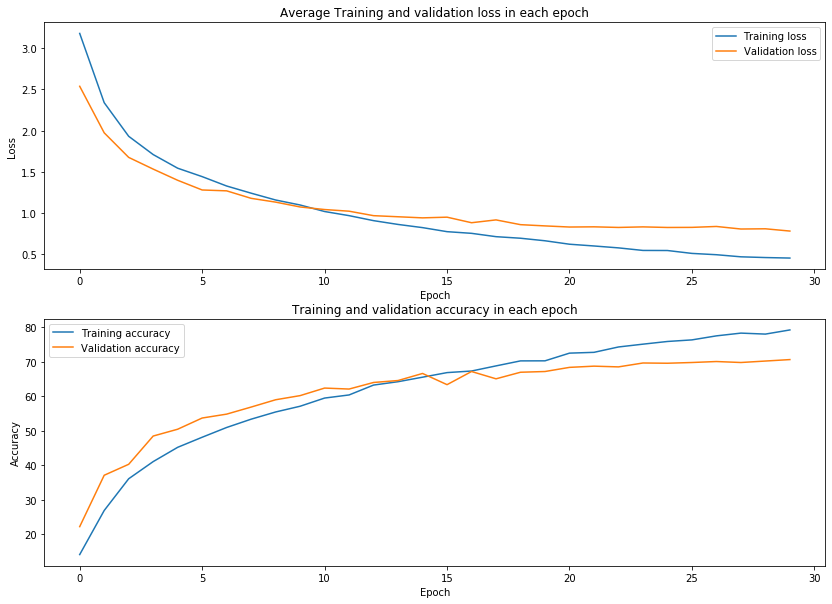

In [11]:
plt.figure(figsize=(14,10))

# Plot training and validation losses
plt.subplot(2, 1, 1)
plt.title("Average Training and validation loss in each epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(training_losses)
plt.plot(validation_losses)
plt.legend(["Training loss","Validation loss"])

# Plot training and validation accuracies
plt.subplot(2, 1, 2)
plt.title("Training and validation accuracy in each epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(training_accuracies)
plt.plot(validation_accuracies)
plt.legend(["Training accuracy","Validation accuracy"])

In [ ]:
# # Load saved checkpoint
# # checkpoint_path = RESULTS_DIR + "2020-04-05_20-52-22" + "/model_checkpoint.pth"
# checkpoint_path = RESULTS_DIR + "2020-04-06___13-52-31" + "/model_best.pth"

# checkpoint = torch.load(checkpoint_path)

# next_epoch_idx = checkpoint['next_epoch_idx']
# val_loss = checkpoint['val_loss']
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])

# print("=> loaded checkpoint '{}' (next_epoch_idx {})".format(checkpoint_path, next_epoch_idx))

# # # # Load saved model
# # # path = RESULTS_DIR + "2020-04-06_03-15-44" + "/bidirectional_video_model.pth"
# # # model.load_state_dict(torch.load(path))

# Evaluate model on validation set

In [12]:
model.eval()

try:
    val_f.close()    
except(NameError):
    ;   
val_f = open(VALIDATION_DATA, 'rb')

y = {'Actual': [], 'Predicted': []}

with torch.no_grad(): # Saves memory and faster computation
    is_file_end = False
    while not is_file_end:
        video, is_file_end = get_next_video_data(val_f)
        if is_file_end:
            break

        inputs, labels, segment_indices = transform_to_inputs(video)

        outputs = model(inputs, segment_indices)

        _, predicted = torch.max(outputs.data, 1)

        y['Actual'].extend(labels.tolist())
        y['Predicted'].extend(predicted.tolist())
    
y_df = pd.DataFrame(y)
path = RESULTS_DIR + model_time + "/val_results-best.csv" # -best
y_df.to_csv(path, encoding='utf-8', index=False)

print('Done predicting on validation set. Saved to', path)

Done predicting on validation set. Saved to ../results/2020-04-07___14-36-44/val_results-best.csv


In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

print('\nMacro f1 Score= %.4f' % f1_score(y['Actual'], y['Predicted'], average="macro"))
print('Macro Precision= %.4f' % precision_score(y['Actual'], y['Predicted'], zero_division=0, average="macro"))
print('Macro Recall= %.4f' % recall_score(y['Actual'], y['Predicted'], average="macro")) 

print('\nMicro f1 Score= %.4f' % f1_score(y['Actual'], y['Predicted'], average="micro"))
print('Micro Precision= %.4f' % precision_score(y['Actual'], y['Predicted'], zero_division=0, average="micro"))
print('Micro Recall= %.4f' % recall_score(y['Actual'], y['Predicted'], average="micro")) 

print('\nAccuracy: %.4f' % accuracy_score(y['Actual'], y['Predicted']))

# Computes the average AUC of all possible pairwise combinations of classes. 
# Insensitive to class imbalance when average == 'macro'.
# print(roc_auc_score(y['Actual'], y['Predicted'], multi_class='ovo', average='macro')) 


Macro f1 Score= 0.5885
Macro Precision= 0.6245
Macro Recall= 0.5883

Micro f1 Score= 0.7073
Micro Precision= 0.7073
Micro Recall= 0.7073

Accuracy: 0.7073


# Generate test data predictions for submission

In [14]:
NUM_TEST_SEGMENTS = 1284

model.eval()

try:
    test_f.close()    
except(NameError):
    pass   
test_f = open(TEST_DATA, 'rb')

y_pred = {'Id': np.arange(NUM_TEST_SEGMENTS), 'Category': []}

def transform_to_test_inputs(video):
    segments = [] # segments (list of frames) in the video
    segment_indices = []
    offset = 0
    for segment_num in range(len(video)):
        segments.append(video[segment_num])
        segment_indices.append((offset, offset + video[segment_num].shape[0]))

        offset += video[segment_num].shape[0]

    # Load frames as tensors with gradient accumulation abilities
    input_frames = torch.cat(segments, 0).unsqueeze(0).requires_grad_().cuda() # unsqueeze to add batch dim
    segment_indices = torch.IntTensor(segment_indices).cuda()
    
    return input_frames, segment_indices

with torch.no_grad(): # Saves memory and faster computation
    is_end_reached = False
    while not is_end_reached:
        video, is_end_reached = get_next_video_data(test_f)

        if is_end_reached:
            break

        inputs, segment_indices = transform_to_test_inputs(video)

        outputs = model(inputs, segment_indices)
        _, predicted = torch.max(outputs.data, 1)

        y_pred['Category'].extend(predicted.tolist())

y_pred_df = pd.DataFrame(y_pred)
path = RESULTS_DIR + model_time + "/" + model_time + "_predictions_submission-best.csv" # -best
y_pred_df.to_csv(path, encoding='utf-8', index=False)

print('Done predicting on test data. Saved to', path)

Done predicting on test data. Saved to ../results/2020-04-07___14-36-44/2020-04-07___14-36-44_predictions_submission-best.csv
